In [13]:
# ===== Cell 1: 載入必要套件 =====
import pandas as pd
import numpy as np
import glob
import os

# ===== Cell 2: 快速載入器 =====
class QuickLoader:
    """簡化版載入器，直接產生 arduino_features"""
    
    def __init__(self, data_dir='data/raw'):
        self.data_dir = data_dir
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        
        # R0 校正參考值
        self.R0_reference = {
            'MQ2_raw': 10.0,
            'MQ3_raw': 60.0,
            'MQ9_raw': 9.8,
            'MQ135_raw': 76.63,
            'TGS2602_raw': 2.5
        }
    
    def load_and_process(self):
        """一次性載入並處理到 arduino_features"""
        print("🔧 快速處理模式...")
        
        # 1. 載入所有檔案
        air_data, pineapple_data = self._load_files()
        
        if not pineapple_data:
            print("❌ 找不到鳳梨數據")
            return None
        
        # 2. 計算 Arduino 特徵
        arduino_features = self._calculate_features(air_data, pineapple_data)
        
        print(f"✅ 完成！產生 {len(arduino_features)} 顆鳳梨的特徵")
        return arduino_features
    
    def _load_files(self):
        """載入 Excel 檔案"""
        xlsx_files = glob.glob(os.path.join(self.data_dir, '*.xlsx'))
        print(f"📂 找到 {len(xlsx_files)} 個檔案")
        
        air_data = {}
        pineapple_data = {}
        
        for file_path in xlsx_files:
            filename = os.path.basename(file_path)
            parts = filename.replace('.xlsx', '').split('_')
            
            if len(parts) < 3:
                continue
            
            is_air = 'air' in filename
            
            # 讀取檔案
            try:
                # 嘗試跳過第一行
                df = pd.read_excel(file_path, engine='openpyxl', skiprows=1)
                
                # 檢查是否有正確的欄位
                if 'timestamp_ms' not in df.columns:
                    df = pd.read_excel(file_path, engine='openpyxl')
                
                # 轉換數字型別
                for col in self.sensor_cols + ['timestamp_ms']:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # 清理缺值
                df = df.dropna().reset_index(drop=True)
                
            except Exception as e:
                print(f"⚠️  載入失敗 {filename}: {e}")
                continue
            
            # 分類儲存
            if is_air:
                if len(parts) == 3:
                    # 共用 air
                    date = parts[1]
                    air_data[f"shared_{date}"] = df
                else:
                    # 專屬 air
                    pid = parts[1]
                    date = parts[2]
                    air_data[f"{pid}_{date}"] = df
            else:
                pid = parts[1]
                date = parts[2]
                
                if pid not in pineapple_data:
                    pineapple_data[pid] = {}
                pineapple_data[pid][date] = df
        
        print(f"   ✓ Air: {len(air_data)}, Pineapple: {len(pineapple_data)} 顆")
        return air_data, pineapple_data
    
    def _calculate_features(self, air_data, pineapple_data):
        """計算 Arduino 特徵"""
        arduino_features = {}
        
        for pid, date_dict in pineapple_data.items():
            arduino_features[pid] = {}
            
            for date, pine_df in date_dict.items():
                # 找對應的 air baseline
                air_df = self._get_air(air_data, pid, date)
                
                if air_df is None:
                    print(f"⚠️  {pid}_{date} 找不到 air baseline")
                    continue
                
                # 計算 Delta
                min_len = min(len(pine_df), len(air_df))
                delta_df = pine_df.iloc[:min_len].copy()
                
                for col in self.sensor_cols:
                    if col in pine_df.columns and col in air_df.columns:
                        delta_df[f'{col}_delta'] = (
                            pine_df[col].iloc[:min_len].values - 
                            air_df[col].iloc[:min_len].values
                        )
                
                # 計算 Arduino 特徵
                features_df = delta_df.copy()
                
                for col in self.sensor_cols:
                    if col in delta_df.columns:
                        sensor_name = col.replace('_raw', '')
                        R0 = self.R0_reference.get(col, 10.0)
                        
                        # Rs/R0
                        features_df[f'{sensor_name}_Rs_R0'] = delta_df[col] / R0
                        
                        # Delta Rs/R0
                        delta_col = f'{col}_delta'
                        if delta_col in delta_df.columns:
                            features_df[f'{sensor_name}_delta_Rs_R0'] = delta_df[delta_col] / R0
                        
                        # 移動平均
                        features_df[f'{sensor_name}_ma10'] = (
                            delta_df[col].rolling(window=10, center=True).mean()
                        )
                        
                        # 移動標準差
                        features_df[f'{sensor_name}_std10'] = (
                            delta_df[col].rolling(window=10, center=True).std()
                        )
                
                arduino_features[pid][date] = features_df
                print(f"   ✓ {pid}_{date}: {features_df.shape}")
        
        return arduino_features
    
    def _get_air(self, air_data, pid, date):
        """取得對應的 air baseline"""
        # 專屬 air
        key = f"{pid}_{date}"
        if key in air_data:
            return air_data[key]
        
        # 共用 air
        shared_key = f"shared_{date}"
        if shared_key in air_data:
            return air_data[shared_key]
        
        return None

# 執行載入
loader = QuickLoader('data/raw')
arduino_features = loader.load_and_process()


🔧 快速處理模式...
📂 找到 58 個檔案
   ✓ Air: 27, Pineapple: 8 顆
   ✓ 04_20250206: (900, 50)
   ✓ 04_20250205: (899, 54)
   ✓ 04_20250203: (900, 50)
   ✓ 04_20250204: (900, 54)
   ✓ 02_20250203: (900, 50)
   ✓ 02_20250202: (900, 50)
   ✓ 02_20250204: (900, 50)
   ✓ 02_20250205: (900, 50)
   ✓ 03_20250206: (900, 54)
   ✓ 03_20250205: (900, 54)
   ✓ 03_20250204: (900, 54)
   ✓ 03_20250203: (900, 50)
   ✓ 06_20250205: (0, 74)
   ✓ 06_20250203: (900, 50)
   ✓ 06_20250202: (900, 50)
   ✓ 06_20250204: (900, 50)
   ✓ 01_20250201: (900, 50)
   ✓ 01_20250204: (900, 50)
   ✓ 01_20250203: (900, 50)
   ✓ 01_20250202: (900, 50)
   ✓ 01_20250205: (900, 50)
   ✓ 08_20250204: (900, 50)
   ✓ 08_20250203: (900, 50)
   ✓ 08_20250205: (900, 50)
   ✓ 07_20250203: (900, 50)
   ✓ 07_20250204: (900, 50)
   ✓ 07_20250205: (899, 50)
   ✓ 05_20250202: (900, 50)
   ✓ 05_20250205: (900, 50)
   ✓ 05_20250204: (900, 50)
   ✓ 05_20250203: (900, 50)
✅ 完成！產生 8 顆鳳梨的特徵


In [14]:
# 快速檢查
import os
files_to_check = [
    'data/processed/feature_data.pkl',
    'data/processed/feature_matrix.csv',
    'data/processed/labels.npy'
]

for file in files_to_check:
    if os.path.exists(file):
        print(f"✅ {file}")
    else:
        print(f"❌ {file} 不存在！")


✅ data/processed/feature_data.pkl
✅ data/processed/feature_matrix.csv
✅ data/processed/labels.npy


In [15]:
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [16]:
!pip install matplotlib seaborn scikit-learn pandas numpy


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [21]:
# ===== 載入真實成熟度標籤 =====
import pickle
import json
import os
import numpy as np

print("🔍 載入真實成熟度標籤...")
print("="*60)

# 嘗試載入 pkl 或 json
label_path_pkl = 'data/processed/maturity_labels.pkl'
label_path_json = 'data/processed/maturity_labels.json'

maturity_levels = None

# 1. 優先嘗試 pkl
if os.path.exists(label_path_pkl):
    try:
        with open(label_path_pkl, 'rb') as f:
            maturity_levels = pickle.load(f)
        print(f"✅ 成功載入: {label_path_pkl}")
    except Exception as e:
        print(f"❌ 載入 pkl 失敗: {e}")

# 2. 如果 pkl 失敗，嘗試 json
if maturity_levels is None and os.path.exists(label_path_json):
    try:
        with open(label_path_json, 'r') as f:
            maturity_levels_raw = json.load(f)
        # 轉換成 numpy array
        maturity_levels = {k: np.array(v) for k, v in maturity_levels_raw.items()}
        print(f"✅ 成功載入: {label_path_json}")
    except Exception as e:
        print(f"❌ 載入 json 失敗: {e}")

# 3. 檢查載入結果
if maturity_levels is not None:
    print("\n📊 標籤摘要:")
    print(f"   鳳梨數量: {len(maturity_levels)}")
    print(f"   鳳梨 IDs: {list(maturity_levels.keys())}")
    
    # 查看所有唯一類別
    all_labels = []
    for pid, labels in maturity_levels.items():
        all_labels.extend(labels.tolist())
    
    unique_labels = np.unique(all_labels)
    print(f"\n   實際類別數: {len(unique_labels)}")
    print(f"   類別範圍: {unique_labels}")
    
    # 類別分布
    print(f"\n   類別分布:")
    for label in unique_labels:
        count = np.sum(np.array(all_labels) == label)
        percentage = count / len(all_labels) * 100
        print(f"      類別 {label}: {count:4d} 個樣本 ({percentage:5.1f}%)")
    
    print(f"\n   總樣本數: {len(all_labels)}")
    
    # 每個鳳梨的標籤分布
    print("\n   每個鳳梨的標籤:")
    for pid, labels in maturity_levels.items():
        unique, counts = np.unique(labels, return_counts=True)
        print(f"      Pineapple {pid}: {dict(zip(unique, counts))}")
    
    print("\n✅ 真實標籤載入完成！")
else:
    print("\n❌ 無法載入標籤，請檢查檔案路徑")
    print(f"   查找路徑: {label_path_pkl}")
    print(f"   或: {label_path_json}")


🔍 載入真實成熟度標籤...
✅ 成功載入: data/processed/maturity_labels.pkl

📊 標籤摘要:
   鳳梨數量: 8
   鳳梨 IDs: ['04', '02', '03', '06', '01', '08', '07', '05']

   實際類別數: 9
   類別範圍: [0 1 2 3 4 5 6 7 8]

   類別分布:
      類別 0: 5600 個樣本 ( 20.7%)
      類別 1: 5500 個樣本 ( 20.4%)
      類別 2: 5400 個樣本 ( 20.0%)
      類別 3: 4350 個樣本 ( 16.1%)
      類別 4: 3449 個樣本 ( 12.8%)
      類別 5:  900 個樣本 (  3.3%)
      類別 6:  670 個樣本 (  2.5%)
      類別 7:  829 個樣本 (  3.1%)
      類別 8:  300 個樣本 (  1.1%)

   總樣本數: 26998

   每個鳳梨的標籤:
      Pineapple 04: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(300), np.int64(3): np.int64(600), np.int64(4): np.int64(899)}
      Pineapple 02: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900), np.int64(3): np.int64(900)}
      Pineapple 03: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900), np.int64(3): np.int64(450), np.int64(4): np.int64(450)}
      Pineapple 06: {np.int64(0): np.int64(900), np.int6

In [22]:
# ===== 檢查真實標籤的實際分布 =====
import numpy as np

print("🔍 檢查真實標籤...")
print("="*60)

# 1. 查看所有唯一類別
all_labels = []
for pid, labels in maturity_levels.items():
    all_labels.extend(labels.tolist())

unique_labels = np.unique(all_labels)
label_counts = np.bincount(all_labels)

print(f"實際類別數: {len(unique_labels)}")
print(f"類別範圍: {unique_labels}")
print(f"\n類別分布:")
for label in unique_labels:
    count = label_counts[label]
    percentage = count / len(all_labels) * 100
    print(f"  類別 {label}: {count:4d} 個樣本 ({percentage:5.1f}%)")

print(f"\n總樣本數: {len(all_labels)}")

# 2. 查看每個鳳梨的標籤分布
print("\n每個鳳梨的標籤:")
for pid, labels in maturity_levels.items():
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  Pineapple {pid}: {dict(zip(unique, counts))}")


🔍 檢查真實標籤...
實際類別數: 9
類別範圍: [0 1 2 3 4 5 6 7 8]

類別分布:
  類別 0: 5600 個樣本 ( 20.7%)
  類別 1: 5500 個樣本 ( 20.4%)
  類別 2: 5400 個樣本 ( 20.0%)
  類別 3: 4350 個樣本 ( 16.1%)
  類別 4: 3449 個樣本 ( 12.8%)
  類別 5:  900 個樣本 (  3.3%)
  類別 6:  670 個樣本 (  2.5%)
  類別 7:  829 個樣本 (  3.1%)
  類別 8:  300 個樣本 (  1.1%)

總樣本數: 26998

每個鳳梨的標籤:
  Pineapple 04: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(300), np.int64(3): np.int64(600), np.int64(4): np.int64(899)}
  Pineapple 02: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900), np.int64(3): np.int64(900)}
  Pineapple 03: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900), np.int64(3): np.int64(450), np.int64(4): np.int64(450)}
  Pineapple 06: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900)}
  Pineapple 01: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900), np.int64(3): np.int64(900), np.int64(4): np.

In [24]:
# ===== 重新映射標籤：9等級 → 4等級 =====
import numpy as np

def remap_labels_9to4(labels):
    """
    將 0-8 (9等級) 映射到 0-3 (4等級)
    
    映射規則:
    0,1   → 0 (未成熟 / Unripe)
    2,3   → 1 (稍微成熟 / Slightly ripe)
    4,5   → 2 (成熟 / Ripe)
    6,7,8 → 3 (過熟 / Overripe)
    """
    mapping = {
        0: 0, 1: 0,         # Stage 0: 未成熟
        2: 1, 3: 1,         # Stage 1: 稍微成熟
        4: 2, 5: 2,         # Stage 2: 成熟
        6: 3, 7: 3, 8: 3    # Stage 3: 過熟
    }
    return np.array([mapping[int(label)] for label in labels])

print("🔄 重新映射標籤...")
print("="*60)
print("映射規則:")
print("  0,1   → Stage 0 (未成熟)")
print("  2,3   → Stage 1 (稍微成熟)")
print("  4,5   → Stage 2 (成熟)")
print("  6,7,8 → Stage 3 (過熟)")
print()

# 重新映射所有鳳梨的標籤
maturity_levels_4stage = {}
for pid, labels in maturity_levels.items():
    maturity_levels_4stage[pid] = remap_labels_9to4(labels)

# 檢查映射結果
print("映射後的標籤分布:")
all_labels_4stage = []
for pid, labels in maturity_levels_4stage.items():
    all_labels_4stage.extend(labels.tolist())
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  Pineapple {pid}: {dict(zip(unique, counts))}")

# 總體分布
print("\n總體分布:")
unique_4stage, counts_4stage = np.unique(all_labels_4stage, return_counts=True)
for stage, count in zip(unique_4stage, counts_4stage):
    percentage = count / len(all_labels_4stage) * 100
    print(f"  Stage {stage}: {count:5d} 個樣本 ({percentage:5.1f}%)")

print(f"\n總樣本數: {len(all_labels_4stage)}")

# 替換原本的 maturity_levels
maturity_levels = maturity_levels_4stage

print("\n✅ 標籤已重新映射為 4 等級！")
print("✅ 可以重新執行 Cell 11（特徵工程）")


🔄 重新映射標籤...
映射規則:
  0,1   → Stage 0 (未成熟)
  2,3   → Stage 1 (稍微成熟)
  4,5   → Stage 2 (成熟)
  6,7,8 → Stage 3 (過熟)

映射後的標籤分布:
  Pineapple 04: {np.int64(0): np.int64(1800), np.int64(1): np.int64(900), np.int64(2): np.int64(899)}
  Pineapple 02: {np.int64(0): np.int64(1800), np.int64(1): np.int64(1800)}
  Pineapple 03: {np.int64(0): np.int64(1800), np.int64(1): np.int64(1350), np.int64(2): np.int64(450)}
  Pineapple 06: {np.int64(0): np.int64(1800), np.int64(1): np.int64(900)}
  Pineapple 01: {np.int64(0): np.int64(1800), np.int64(1): np.int64(1800), np.int64(2): np.int64(900)}
  Pineapple 08: {np.int64(0): np.int64(600), np.int64(1): np.int64(600), np.int64(2): np.int64(600), np.int64(3): np.int64(900)}
  Pineapple 07: {np.int64(0): np.int64(600), np.int64(1): np.int64(600), np.int64(2): np.int64(600), np.int64(3): np.int64(899)}
  Pineapple 05: {np.int64(0): np.int64(900), np.int64(1): np.int64(1800), np.int64(2): np.int64(900)}

總體分布:
  Stage 0: 11100 個樣本 ( 41.1%)
  Stage 1:  9750 個樣本 (

In [26]:
# ===== Cell 11: Step 4 - 特徵工程（修正版）=====

import numpy as np
import pandas as pd
from scipy.stats import linregress
import pickle
import os

class FeatureEngineering:
    """
    使用固定時間窗口提取特徵
    目標：將時間序列轉換為 (n_samples, n_features) 的特徵矩陣
    """
    
    def __init__(self, arduino_features, maturity_labels, window_size=120):
        """
        參數:
            window_size: 時間窗口大小（秒）
                        假設取樣率 1Hz，120秒 = 120 個樣本點
        """
        self.arduino_features = arduino_features
        self.maturity_labels = maturity_labels
        self.window_size = window_size
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        
        self.feature_matrix = None
        self.labels = None
        self.metadata = None
        
        self.output_dir = 'data/processed'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def extract_all_features(self):
        """批次提取所有特徵"""
        print("="*60)
        print("🔧 Step 4: 特徵工程（固定時間窗）")
        print("="*60)
        print(f"窗口大小: {self.window_size} 秒\n")
        
        all_features = []
        all_labels = []
        all_metadata = []
        
        for pid in self.arduino_features.keys():
            if pid not in self.maturity_labels:
                print(f"⚠️  {pid}: 找不到對應的成熟度標籤，跳過")
                continue
            
            print(f"🍍 處理 Pineapple {pid}...")
            
            # 合併該鳳梨的所有日期數據
            combined_df, combined_labels = self._combine_pineapple_data(pid)
            
            if combined_df is None:
                continue
            
            # 滑動窗口提取特徵
            features, labels, metadata = self._sliding_window_extraction(
                combined_df, combined_labels, pid
            )
            
            all_features.append(features)
            all_labels.append(labels)
            all_metadata.extend(metadata)
            
            print(f"   ✓ 提取 {len(features)} 個窗口，每個 {features.shape[1]} 維特徵\n")
        
        # 合併所有鳳梨的特徵
        self.feature_matrix = pd.DataFrame(
            np.vstack(all_features),
            columns=self._get_feature_names()
        )
        self.labels = np.hstack(all_labels)
        self.metadata = pd.DataFrame(all_metadata)
        
        print("="*60)
        print(f"✅ 特徵提取完成！")
        print(f"   特徵矩陣: {self.feature_matrix.shape}")
        print(f"   標籤數量: {len(self.labels)}")
        print(f"   標籤分布: {dict(zip(*np.unique(self.labels, return_counts=True)))}")
        print("="*60)
        
        return self.feature_matrix, self.labels, self.metadata
    
    def _combine_pineapple_data(self, pid):
        """合併單顆鳳梨的所有日期數據"""
        df_list = []
        label_list = []
        
        date_dict = self.arduino_features[pid]
        labels = self.maturity_labels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date].copy()
            n_samples = len(df)
            
            # 取對應的標籤
            window_labels = labels[offset:offset+n_samples]
            
            df_list.append(df)
            label_list.append(window_labels)
            
            offset += n_samples
        
        if not df_list:
            return None, None
        
        combined_df = pd.concat(df_list, ignore_index=True)
        combined_labels = np.hstack(label_list)
        
        return combined_df, combined_labels
    
    def _sliding_window_extraction(self, df, labels, pid):
        """滑動窗口提取特徵"""
        features = []
        window_labels = []
        metadata = []
        
        n_samples = len(df)
        step_size = self.window_size  # 不重疊窗口
        
        for start_idx in range(0, n_samples - self.window_size + 1, step_size):
            end_idx = start_idx + self.window_size
            
            window_df = df.iloc[start_idx:end_idx]
            window_label_array = labels[start_idx:end_idx]
            
            # 該窗口的主要標籤（眾數）
            unique, counts = np.unique(window_label_array, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            # 提取特徵
            feature_vector = self._extract_window_features(window_df)
            
            features.append(feature_vector)
            window_labels.append(majority_label)
            metadata.append({
                'pineapple_id': pid,
                'start_idx': start_idx,
                'end_idx': end_idx,
                'majority_label': int(majority_label),
                'label_purity': max(counts) / len(window_label_array)
            })
        
        return np.array(features), np.array(window_labels), metadata
    
    def _extract_window_features(self, window_df):
        """從單一窗口提取特徵"""
        features = []
        
        for sensor in self.sensor_cols:
            # 1. Rs/R0 特徵
            col_rs_r0 = f'{sensor}_Rs_R0'
            if col_rs_r0 in window_df.columns:
                data = window_df[col_rs_r0].values
                
                # 統計特徵
                features.append(np.mean(data))           # 平均值
                features.append(np.std(data))            # 標準差
                features.append(np.min(data))            # 最小值
                features.append(np.max(data))            # 最大值
                features.append(np.max(data) - np.min(data))  # 反應幅度
                
                # 變化速率（斜率）
                if len(data) > 1:
                    x = np.arange(len(data))
                    slope, _, _, _, _ = linregress(x, data)
                    features.append(slope)
                else:
                    features.append(0)
                
                # AUC（累積反應）- 修正版
                try:
                    auc = np.trapezoid(data, dx=1)  # numpy >= 2.0
                except AttributeError:
                    # fallback: 手動梯形積分
                    if len(data) > 1:
                        auc = np.sum((data[:-1] + data[1:]) / 2)
                    else:
                        auc = data[0] if len(data) > 0 else 0
                
                features.append(auc)
            else:
                features.extend([0] * 7)  # 填充 7 個特徵
            
            # 2. Delta Rs/R0 特徵
            col_delta = f'{sensor}_delta_Rs_R0'
            if col_delta in window_df.columns:
                data = window_df[col_delta].values
                
                features.append(np.mean(data))
                features.append(np.std(data))
                features.append(np.max(np.abs(data)))    # 最大絕對變化
            else:
                features.extend([0] * 3)
        
        # 3. 跨感測器特徵（比例特徵）
        # MQ3/MQ2 比例（酒精 vs 可燃氣體）
        mq3 = window_df['MQ3_Rs_R0'].mean() if 'MQ3_Rs_R0' in window_df.columns else 0
        mq2 = window_df['MQ2_Rs_R0'].mean() if 'MQ2_Rs_R0' in window_df.columns else 0
        features.append(mq3 / (mq2 + 1e-6))
        
        # MQ135/TGS2602 比例（空氣品質 vs VOC）
        mq135 = window_df['MQ135_Rs_R0'].mean() if 'MQ135_Rs_R0' in window_df.columns else 0
        tgs = window_df['TGS2602_Rs_R0'].mean() if 'TGS2602_Rs_R0' in window_df.columns else 0
        features.append(mq135 / (tgs + 1e-6))
        
        # 所有感測器平均
        all_means = [window_df[f'{s}_Rs_R0'].mean() 
                     for s in self.sensor_cols 
                     if f'{s}_Rs_R0' in window_df.columns]
        features.append(np.mean(all_means) if all_means else 0)
        
        return np.array(features)

    
    def _get_feature_names(self):
        """生成特徵名稱"""
        names = []
        
        for sensor in self.sensor_cols:
            # Rs/R0 特徵
            names.extend([
                f'{sensor}_mean',
                f'{sensor}_std',
                f'{sensor}_min',
                f'{sensor}_max',
                f'{sensor}_range',
                f'{sensor}_slope',
                f'{sensor}_auc'
            ])
            
            # Delta Rs/R0 特徵
            names.extend([
                f'{sensor}_delta_mean',
                f'{sensor}_delta_std',
                f'{sensor}_delta_max_abs'
            ])
        
        # 跨感測器特徵
        names.extend([
            'MQ3_MQ2_ratio',
            'MQ135_TGS2602_ratio',
            'all_sensors_mean'
        ])
        
        return names
    
    def save_features(self):
        """儲存特徵與標籤"""
        print("\n💾 儲存特徵...")
        
        # 1. 特徵矩陣（CSV）
        csv_path = os.path.join(self.output_dir, 'feature_matrix.csv')
        self.feature_matrix.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ CSV: {csv_path}")
        
        # 2. 標籤（numpy）
        label_path = os.path.join(self.output_dir, 'labels.npy')
        np.save(label_path, self.labels)
        print(f"   ✅ Labels: {label_path}")
        
        # 3. Metadata（CSV）
        meta_path = os.path.join(self.output_dir, 'metadata.csv')
        self.metadata.to_csv(meta_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ Metadata: {meta_path}")
        
        # 4. 完整 pickle（方便載入）
        pkl_path = os.path.join(self.output_dir, 'feature_data.pkl')
        with open(pkl_path, 'wb') as f:
            pickle.dump({
                'features': self.feature_matrix,
                'labels': self.labels,
                'metadata': self.metadata,
                'feature_names': self.feature_matrix.columns.tolist(),
                'window_size': self.window_size
            }, f)
        print(f"   ✅ Pickle: {pkl_path}")
        
        print("\n✅ Step 4 完成！可以進入 Step 5（模型訓練）")

# 執行特徵工程
feature_engineer = FeatureEngineering(
    arduino_features, 
    maturity_levels,  # 使用重新映射後的 4 等級標籤
    window_size=120   # 120 秒窗口
)

X, y, metadata = feature_engineer.extract_all_features()
feature_engineer.save_features()

# 顯示特徵摘要
print(f"\n📊 特徵摘要:")
print(f"   總樣本數: {len(y)}")
print(f"   特徵維度: {X.shape[1]}")
print(f"   特徵列表: {X.columns.tolist()[:10]}... (前10個)")


🔧 Step 4: 特徵工程（固定時間窗）
窗口大小: 120 秒

🍍 處理 Pineapple 04...
   ✓ 提取 29 個窗口，每個 53 維特徵

🍍 處理 Pineapple 02...
   ✓ 提取 30 個窗口，每個 53 維特徵

🍍 處理 Pineapple 03...
   ✓ 提取 30 個窗口，每個 53 維特徵

🍍 處理 Pineapple 06...
   ✓ 提取 22 個窗口，每個 53 維特徵

🍍 處理 Pineapple 01...
   ✓ 提取 37 個窗口，每個 53 維特徵

🍍 處理 Pineapple 08...
   ✓ 提取 22 個窗口，每個 53 維特徵

🍍 處理 Pineapple 07...
   ✓ 提取 22 個窗口，每個 53 維特徵

🍍 處理 Pineapple 05...
   ✓ 提取 30 個窗口，每個 53 維特徵

✅ 特徵提取完成！
   特徵矩陣: (222, 53)
   標籤數量: 222
   標籤分布: {np.int64(0): np.int64(93), np.int64(1): np.int64(81), np.int64(2): np.int64(34), np.int64(3): np.int64(14)}

💾 儲存特徵...
   ✅ CSV: data/processed/feature_matrix.csv
   ✅ Labels: data/processed/labels.npy
   ✅ Metadata: data/processed/metadata.csv
   ✅ Pickle: data/processed/feature_data.pkl

✅ Step 4 完成！可以進入 Step 5（模型訓練）

📊 特徵摘要:
   總樣本數: 222
   特徵維度: 53
   特徵列表: ['MQ2_mean', 'MQ2_std', 'MQ2_min', 'MQ2_max', 'MQ2_range', 'MQ2_slope', 'MQ2_auc', 'MQ2_delta_mean', 'MQ2_delta_std', 'MQ2_delta_max_abs']... (前10個)


In [27]:
# ===== Cell 12: Step 5 - 模型訓練與比較 =====

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

class ModelTrainer:
    """
    訓練並比較多個分類模型
    主模型：SVM (RBF kernel)
    對比模型：Random Forest
    """
    
    def __init__(self, X, y, metadata):
        self.X = X
        self.y = y
        self.metadata = metadata
        
        # 標準化特徵
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)
        
        # 模型
        self.svm_model = None
        self.rf_model = None
        
        # 結果
        self.results = {}
        
        self.output_dir = 'models'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def train_and_evaluate_all(self):
        """訓練並評估所有模型"""
        print("="*60)
        print("🤖 Step 5: 模型訓練與比較")
        print("="*60)
        
        # 1. SVM (主模型)
        print("\n📊 訓練 SVM (RBF kernel)...")
        self._train_svm()
        
        # 2. Random Forest (對比)
        print("\n📊 訓練 Random Forest...")
        self._train_random_forest()
        
        # 3. 比較結果
        print("\n📊 模型比較...")
        self._compare_models()
        
        # 4. 特徵重要性分析
        print("\n📊 特徵重要性分析...")
        self._analyze_feature_importance()
        
        # 5. 錯誤案例分析
        print("\n📊 錯誤案例分析...")
        self._analyze_errors()
        
        # 6. 儲存模型
        print("\n💾 儲存模型...")
        self._save_models()
        
        print("\n" + "="*60)
        print("✅ Step 5 完成！")
        print("="*60)
    
    def _train_svm(self):
        """訓練 SVM 模型"""
        # 使用不同的 C 和 gamma 參數
        param_grid = [
            {'C': 1, 'gamma': 'scale'},
            {'C': 10, 'gamma': 'scale'},
            {'C': 100, 'gamma': 'scale'},
            {'C': 1, 'gamma': 'auto'},
        ]
        
        best_score = 0
        best_params = None
        
        for params in param_grid:
            svm = SVC(kernel='rbf', **params, random_state=42)
            
            # 5-fold 交叉驗證
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(svm, self.X_scaled, self.y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            print(f"   C={params['C']}, gamma={params['gamma']}: {mean_score:.3f} (+/- {scores.std():.3f})")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        print(f"\n   ✅ 最佳參數: {best_params}")
        print(f"   ✅ 交叉驗證準確率: {best_score:.3f}")
        
        # 用最佳參數訓練最終模型
        self.svm_model = SVC(kernel='rbf', **best_params, random_state=42)
        self.svm_model.fit(self.X_scaled, self.y)
        
        # 交叉驗證預測（用於混淆矩陣）
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(self.svm_model, self.X_scaled, self.y, cv=cv)
        
        self.results['svm'] = {
            'model': self.svm_model,
            'cv_score': best_score,
            'y_pred_cv': y_pred_cv,
            'params': best_params
        }
    
    def _train_random_forest(self):
        """訓練 Random Forest 模型"""
        # 嘗試不同的參數
        param_grid = [
            {'n_estimators': 100, 'max_depth': None},
            {'n_estimators': 200, 'max_depth': 10},
            {'n_estimators': 100, 'max_depth': 5},
        ]
        
        best_score = 0
        best_params = None
        
        for params in param_grid:
            rf = RandomForestClassifier(**params, random_state=42)
            
            # 5-fold 交叉驗證
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(rf, self.X_scaled, self.y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            print(f"   n_est={params['n_estimators']}, depth={params['max_depth']}: {mean_score:.3f} (+/- {scores.std():.3f})")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        print(f"\n   ✅ 最佳參數: {best_params}")
        print(f"   ✅ 交叉驗證準確率: {best_score:.3f}")
        
        # 用最佳參數訓練最終模型
        self.rf_model = RandomForestClassifier(**best_params, random_state=42)
        self.rf_model.fit(self.X_scaled, self.y)
        
        # 交叉驗證預測
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(self.rf_model, self.X_scaled, self.y, cv=cv)
        
        self.results['rf'] = {
            'model': self.rf_model,
            'cv_score': best_score,
            'y_pred_cv': y_pred_cv,
            'params': best_params
        }
    
    def _compare_models(self):
        """比較模型表現"""
        print("\n" + "="*60)
        print("📊 模型比較結果")
        print("="*60)
        
        for model_name, result in self.results.items():
            model_display = "SVM (RBF)" if model_name == 'svm' else "Random Forest"
            print(f"\n🤖 {model_display}")
            print(f"   交叉驗證準確率: {result['cv_score']:.3f}")
            
            # 分類報告
            y_pred = result['y_pred_cv']
            print("\n   分類報告:")
            report = classification_report(self.y, y_pred, 
                                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                          digits=3)
            print("   " + report.replace("\n", "\n   "))
            
            # 混淆矩陣
            cm = confusion_matrix(self.y, y_pred)
            print(f"\n   混淆矩陣:")
            print(f"   {cm}")
        
        # 推薦模型
        best_model = max(self.results.items(), key=lambda x: x[1]['cv_score'])
        print(f"\n✅ 推薦模型: {'SVM (RBF)' if best_model[0] == 'svm' else 'Random Forest'}")
        print(f"   準確率: {best_model[1]['cv_score']:.3f}")
    
    def _analyze_feature_importance(self):
        """分析特徵重要性（Random Forest）"""
        if 'rf' not in self.results:
            return
        
        rf_model = self.results['rf']['model']
        feature_names = self.X.columns if hasattr(self.X, 'columns') else [f'F{i}' for i in range(self.X.shape[1])]
        
        # 取得特徵重要性
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\n🔝 Top 10 重要特徵 (Random Forest):")
        for i, idx in enumerate(indices[:10], 1):
            print(f"   {i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")
        
        # 儲存完整特徵重要性
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        csv_path = os.path.join(self.output_dir, 'feature_importance.csv')
        importance_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n   💾 完整特徵重要性: {csv_path}")
    
    def _analyze_errors(self):
        """分析錯誤案例"""
        print("\n❌ 錯誤案例分析 (SVM):")
        
        if 'svm' not in self.results:
            return
        
        y_pred = self.results['svm']['y_pred_cv']
        errors = self.y != y_pred
        
        print(f"   錯誤樣本數: {errors.sum()} / {len(self.y)} ({errors.sum()/len(self.y)*100:.1f}%)")
        
        # 分析哪些類別容易混淆
        error_pairs = []
        for true_label, pred_label in zip(self.y[errors], y_pred[errors]):
            error_pairs.append((int(true_label), int(pred_label)))
        
        from collections import Counter
        error_counts = Counter(error_pairs)
        
        print("\n   最常見的混淆 (真實 → 預測):")
        for (true_l, pred_l), count in error_counts.most_common(5):
            print(f"      Stage {true_l} → Stage {pred_l}: {count} 次")
        
        # 儲存錯誤案例
        error_df = self.metadata[errors].copy()
        error_df['true_label'] = self.y[errors]
        error_df['predicted_label'] = y_pred[errors]
        
        csv_path = os.path.join(self.output_dir, 'error_cases.csv')
        error_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n   💾 錯誤案例詳情: {csv_path}")
    
    def _save_models(self):
        """儲存訓練好的模型"""
        # 儲存 SVM
        if 'svm' in self.results:
            svm_path = os.path.join(self.output_dir, 'svm_model.pkl')
            with open(svm_path, 'wb') as f:
                pickle.dump({
                    'model': self.results['svm']['model'],
                    'scaler': self.scaler,
                    'params': self.results['svm']['params'],
                    'cv_score': self.results['svm']['cv_score']
                }, f)
            print(f"   ✅ SVM: {svm_path}")
        
        # 儲存 Random Forest
        if 'rf' in self.results:
            rf_path = os.path.join(self.output_dir, 'rf_model.pkl')
            with open(rf_path, 'wb') as f:
                pickle.dump({
                    'model': self.results['rf']['model'],
                    'scaler': self.scaler,
                    'params': self.results['rf']['params'],
                    'cv_score': self.results['rf']['cv_score']
                }, f)
            print(f"   ✅ Random Forest: {rf_path}")
        
        print("\n✅ 模型已儲存，可以進入 Step 6（部署）")

# 載入特徵
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features']
y = data['labels']
metadata = data['metadata']

# 訓練模型
trainer = ModelTrainer(X, y, metadata)
trainer.train_and_evaluate_all()


🤖 Step 5: 模型訓練與比較

📊 訓練 SVM (RBF kernel)...
   C=1, gamma=scale: 0.730 (+/- 0.063)
   C=10, gamma=scale: 0.901 (+/- 0.023)
   C=100, gamma=scale: 0.928 (+/- 0.017)
   C=1, gamma=auto: 0.730 (+/- 0.063)

   ✅ 最佳參數: {'C': 100, 'gamma': 'scale'}
   ✅ 交叉驗證準確率: 0.928

📊 訓練 Random Forest...
   n_est=100, depth=None: 0.955 (+/- 0.020)
   n_est=200, depth=10: 0.955 (+/- 0.028)
   n_est=100, depth=5: 0.892 (+/- 0.033)

   ✅ 最佳參數: {'n_estimators': 200, 'max_depth': 10}
   ✅ 交叉驗證準確率: 0.955

📊 模型比較...

📊 模型比較結果

🤖 SVM (RBF)
   交叉驗證準確率: 0.928

   分類報告:
                 precision    recall  f1-score   support
   
        Stage 0      0.928     0.968     0.947        93
        Stage 1      0.911     0.889     0.900        81
        Stage 2      0.938     0.882     0.909        34
        Stage 3      1.000     1.000     1.000        14
   
       accuracy                          0.928       222
      macro avg      0.944     0.935     0.939       222
   weighted avg      0.928     0.928     0.928 

In [ ]:
# 以下為嘗試調整改進

In [ ]:
#📊 實驗 1：類別權重調整
#測試 3 種策略：

#None（基準）

#Balanced（自動平衡）

#Custom（強化 Stage 2，給 1.5 倍權重）

#📊 實驗 2：不同窗口大小
#測試 4 種窗口：

#60 秒：更細緻，樣本更多

#120 秒：當前基準

#180 秒：更穩定

#240 秒：最穩定但樣本較少

#📊 實驗 3：特徵選擇
#測試使用 10, 20, 30, 40, 53 個特徵的效果

In [ ]:
import os

# 定義路徑
path = './data/processed/'

# 取得該目錄下所有檔案與資料夾名稱
file_list = os.listdir(path)

# 打印出來
for file_name in file_list:
    print(file_name)

In [ ]:
# ===== Cell 14a: 載入必要變數 =====

import pickle

print("📂 載入必要資料...")

# 1. 載入 maturity_levels（4等級）
with open('data/processed/maturity_levels_4class.pkl', 'rb') as f:
    maturity_levels = pickle.load(f)
print(f"✅ maturity_levels: {len(maturity_levels)} 顆鳳梨")

# 2. 檢查 arduino_features 是否存在
if 'arduino_features' not in globals():
    print("\n⚠️  arduino_features 不存在")
    print("   請重新執行 Cell 2 (快速載入器)")
    print("   或執行以下程式碼重新載入...\n")
    
    # 快速重新載入（如果你有原始 CSV）
    # 這裡需要重新執行 Cell 2 的程式碼
else:
    print(f"✅ arduino_features: {len(arduino_features)} 顆鳳梨")

print("\n✅ 變數載入完成！可以執行 Cell 14")


In [ ]:
#📊 實驗 1：類別權重調整
#測試 3 種策略：

#None（基準）

#Balanced（自動平衡）

#Custom（強化 Stage 2，給 1.5 倍權重）

#📊 實驗 2：不同窗口大小
#測試 4 種窗口：

#60 秒：更細緻，樣本更多

#120 秒：當前基準

#180 秒：更穩定

#240 秒：最穩定但樣本較少

#📊 實驗 3：特徵選擇
#測試使用 10, 20, 30, 40, 53 個特徵的效果

✅ 準備執行改進實驗...
   確保已執行：
   - arduino_features 已載入
   - maturity_levels 已重新映射為 4 等級
   - FeatureEngineering 已定義（Cell 11）

🔬 模型改進實驗（基於真實標籤）
基準模型: Random Forest, 準確率 = 0.955

📊 實驗 1: 類別權重調整
----------------------------------------------------------------------
   檢測到的類別: [0 1 2 3]
📈 None (基準)                     : 準確率=0.955 (+0.000)
   ✅ Stage 1 Recall: 0.901 (基準=0.901)
📈 Balanced                      : 準確率=0.964 (+0.009)
   ✅ Stage 1 Recall: 0.926 (基準=0.901)
📈 Custom (強化Stage1)             : 準確率=0.964 (+0.009)
   ✅ Stage 1 Recall: 0.926 (基準=0.901)
📈 Custom (強化Stage2)             : 準確率=0.955 (+0.000)
   ✅ Stage 1 Recall: 0.901 (基準=0.901)

📊 實驗 2: 不同窗口大小
----------------------------------------------------------------------

🔍 測試窗口大小: 60 秒
🔧 Step 4: 特徵工程（固定時間窗）
窗口大小: 60 秒

🍍 處理 Pineapple 04...
   ✓ 提取 59 個窗口，每個 53 維特徵

🍍 處理 Pineapple 02...
   ✓ 提取 60 個窗口，每個 53 維特徵

🍍 處理 Pineapple 03...
   ✓ 提取 60 個窗口，每個 53 維特徵

🍍 處理 Pineapple 06...
   ✓ 提取 45 個窗口，每個 53 維特徵

🍍 處理 Pineapple 01...
   ✓ 提取 75 

/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 24375 (\N{CJK UNIFIED IDEOGRAPH-5F37}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2018/1607245292.py:288: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAP

📊 對比圖: models/improvements/improvement_comparison.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24375 (\N{CJK UNIFIED IDEOGRAPH-5F37}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas

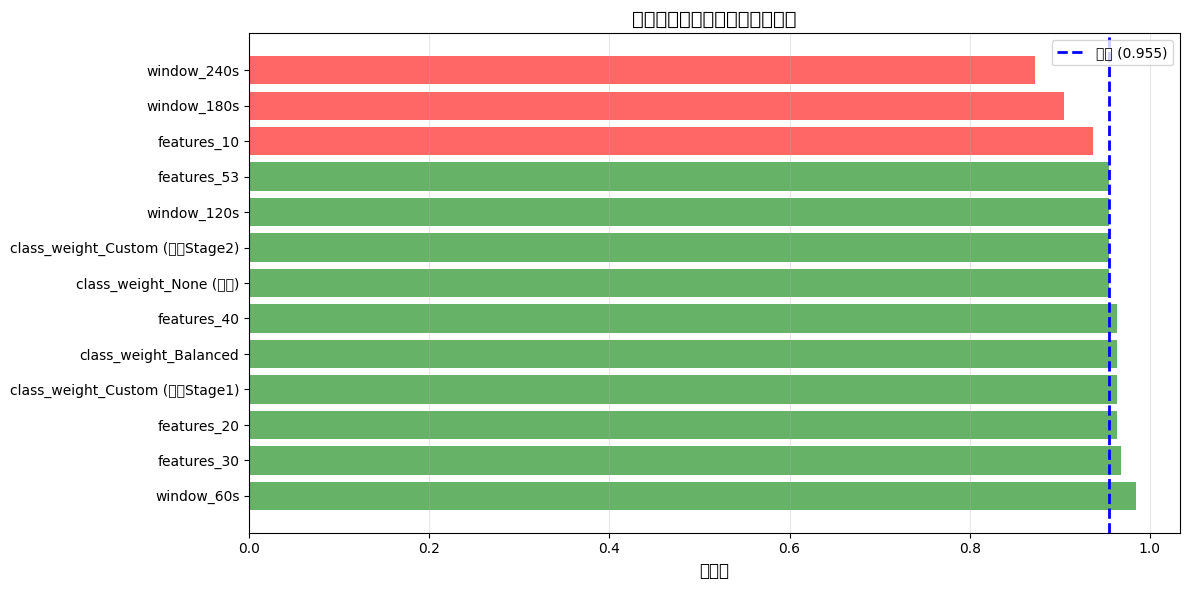

In [28]:
# ===== Cell 13: 模型改進實驗（更新版）=====

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

class ModelImprovement:
    """系統化測試多種改進方案"""
    
    def __init__(self):
        self.experiments = {}
        self.baseline_score = 0.955  # ✅ 更新為真實基準
        self.output_dir = 'models/improvements'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def run_all_experiments(self):
        """執行所有改進實驗"""
        print("="*70)
        print("🔬 模型改進實驗（基於真實標籤）")
        print("="*70)
        print(f"基準模型: Random Forest, 準確率 = {self.baseline_score:.3f}\n")
        
        # 實驗 1: 類別權重
        print("📊 實驗 1: 類別權重調整")
        print("-"*70)
        self._experiment_class_weights()
        
        # 實驗 2: 不同窗口大小
        print("\n📊 實驗 2: 不同窗口大小")
        print("-"*70)
        self._experiment_window_sizes()
        
        # 實驗 3: 特徵選擇
        print("\n📊 實驗 3: 特徵選擇")
        print("-"*70)
        self._experiment_feature_selection()
        
        # 總結報告
        print("\n" + "="*70)
        print("📋 實驗總結報告")
        print("="*70)
        self._generate_summary_report()
        
        return self.experiments
    
    def _experiment_class_weights(self):
        """實驗 1: 測試類別權重"""
        # 載入基準特徵
        with open('data/processed/feature_data.pkl', 'rb') as f:
            data = pickle.load(f)
        X, y = data['features'], data['labels']
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 自動檢測類別數
        unique_classes = np.unique(y)
        print(f"   檢測到的類別: {unique_classes}")
        
        # 測試不同權重策略
        weight_strategies = {
            'None (基準)': None,
            'Balanced': 'balanced',
            'Custom (強化Stage1)': {c: (1.3 if c == 1 else 1.0) for c in unique_classes},  # Stage 1 recall 較低
            'Custom (強化Stage2)': {c: (1.2 if c == 2 else 1.0) for c in unique_classes}
        }
        
        for name, weights in weight_strategies.items():
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                class_weight=weights,
                random_state=42
            )
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            # 詳細分類報告
            y_pred = cross_val_predict(rf, X_scaled, y, cv=cv)
            report = classification_report(y, y_pred, 
                                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                          output_dict=True)
            
            # 特別關注 Stage 1 (recall 最低)
            stage1_recall = report['Stage 1']['recall']
            
            self.experiments[f'class_weight_{name}'] = {
                'accuracy': mean_score,
                'stage1_recall': stage1_recall,
                'improvement': mean_score - self.baseline_score
            }
            
            improvement_icon = "📈" if mean_score > self.baseline_score else "📉" if mean_score < self.baseline_score else "➡️"
            stage1_icon = "✅" if stage1_recall > 0.901 else "⚠️"
            
            print(f"{improvement_icon} {name:30s}: 準確率={mean_score:.3f} ({mean_score-self.baseline_score:+.3f})")
            print(f"   {stage1_icon} Stage 1 Recall: {stage1_recall:.3f} (基準=0.901)")
    
    def _experiment_window_sizes(self):
        """實驗 2: 測試不同窗口大小"""
        # 檢查 FeatureEngineering 是否可用
        try:
            FeatureEngineering
        except NameError:
            print("⚠️  FeatureEngineering 未定義，跳過此實驗")
            print("   提示：需要重新執行 Cell 11 才能測試不同窗口大小")
            return
        
        window_sizes = [60, 120, 180, 240]
        
        for ws in window_sizes:
            print(f"\n🔍 測試窗口大小: {ws} 秒")
            
            try:
                # 重新提取特徵
                feature_engineer = FeatureEngineering(
                    arduino_features, 
                    maturity_levels,
                    window_size=ws
                )
                
                X, y, metadata = feature_engineer.extract_all_features()
                
                # 標準化
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # 訓練 Random Forest
                rf = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=10,
                    random_state=42
                )
                
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
                mean_score = scores.mean()
                
                # 詳細分析
                y_pred = cross_val_predict(rf, X_scaled, y, cv=cv)
                report = classification_report(y, y_pred, 
                                              target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                              output_dict=True)
                
                self.experiments[f'window_{ws}s'] = {
                    'accuracy': mean_score,
                    'n_samples': len(y),
                    'stage1_recall': report['Stage 1']['recall'],
                    'improvement': mean_score - self.baseline_score
                }
                
                improvement_icon = "📈" if mean_score > self.baseline_score else "📉" if mean_score < self.baseline_score else "➡️"
                
                print(f"{improvement_icon} 窗口 {ws}s: 準確率={mean_score:.3f} ({mean_score-self.baseline_score:+.3f}), 樣本數={len(y)}")
                
            except Exception as e:
                print(f"❌ 窗口 {ws}s 失敗: {e}")
                self.experiments[f'window_{ws}s'] = {'accuracy': 0, 'error': str(e)}
    
    def _experiment_feature_selection(self):
        """實驗 3: 測試特徵選擇"""
        # 載入基準特徵
        with open('data/processed/feature_data.pkl', 'rb') as f:
            data = pickle.load(f)
        X, y = data['features'], data['labels']
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 測試不同數量的特徵
        n_features_list = [10, 20, 30, 40, 53]
        
        for n_features in n_features_list:
            if n_features >= X.shape[1]:
                # 使用全部特徵
                X_selected = X_scaled
            else:
                # 特徵選擇
                selector = SelectKBest(f_classif, k=n_features)
                X_selected = selector.fit_transform(X_scaled, y)
                
                # 顯示選中的特徵
                if n_features == 20:
                    selected_features = selector.get_support(indices=True)
                    feature_names = data['features'].columns
                    print(f"\n   Top {n_features} 特徵:")
                    for i, idx in enumerate(selected_features[:10], 1):
                        print(f"      {i:2d}. {feature_names[idx]}")
            
            # 訓練模型
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(rf, X_selected, y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            self.experiments[f'features_{n_features}'] = {
                'accuracy': mean_score,
                'n_features': n_features,
                'improvement': mean_score - self.baseline_score
            }
            
            improvement_icon = "📈" if mean_score > self.baseline_score else "📉" if mean_score < self.baseline_score else "➡️"
            
            print(f"{improvement_icon} 使用 {n_features:2d} 個特徵: 準確率={mean_score:.3f} ({mean_score-self.baseline_score:+.3f})")
    
    def _generate_summary_report(self):
        """生成總結報告"""
        # 找出最佳方案
        valid_experiments = {k: v for k, v in self.experiments.items() 
                            if 'accuracy' in v and v['accuracy'] > 0}
        
        if not valid_experiments:
            print("⚠️  沒有有效的實驗結果")
            return
        
        best_exp = max(valid_experiments.items(), key=lambda x: x[1]['accuracy'])
        best_name, best_result = best_exp
        
        print(f"\n🏆 最佳方案: {best_name}")
        print(f"   準確率: {best_result['accuracy']:.3f}")
        print(f"   改進幅度: {best_result['improvement']:+.3f}")
        
        if best_result['accuracy'] > self.baseline_score:
            improvement_pct = (best_result['improvement'] / self.baseline_score) * 100
            print(f"\n✅ 找到改進方案！比基準提升 {improvement_pct:.2f}%")
            print(f"   從 {self.baseline_score:.3f} → {best_result['accuracy']:.3f}")
        elif best_result['accuracy'] == self.baseline_score:
            print(f"\n➡️  改進方案與基準持平，模型已達最優")
        else:
            print(f"\n➡️  基準模型 (120s窗口 + 53特徵) 已經是最優配置")
        
        # 儲存報告
        report_df = pd.DataFrame([
            {
                'experiment': name,
                'accuracy': result.get('accuracy', 0),
                'improvement': result.get('improvement', 0),
                **{k: v for k, v in result.items() if k not in ['accuracy', 'improvement']}
            }
            for name, result in self.experiments.items()
        ]).sort_values('accuracy', ascending=False)
        
        csv_path = os.path.join(self.output_dir, 'improvement_report.csv')
        report_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n💾 完整報告: {csv_path}")
        
        # 視覺化對比
        self._plot_comparison(report_df)
    
    def _plot_comparison(self, report_df):
        """繪製對比圖"""
        try:
            import matplotlib.pyplot as plt
            
            fig, ax = plt.subplots(figsize=(12, 6))
            
            experiments = report_df['experiment'].tolist()
            accuracies = report_df['accuracy'].tolist()
            
            colors = ['green' if acc > self.baseline_score else 'red' if acc < self.baseline_score else 'gray' 
                     for acc in accuracies]
            
            ax.barh(experiments, accuracies, color=colors, alpha=0.6)
            ax.axvline(self.baseline_score, color='blue', linestyle='--', linewidth=2,
                      label=f'基準 ({self.baseline_score:.3f})')
            
            ax.set_xlabel('準確率', fontsize=12)
            ax.set_title('模型改進實驗對比（真實標籤）', fontsize=14, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            
            plot_path = os.path.join(self.output_dir, 'improvement_comparison.png')
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            print(f"📊 對比圖: {plot_path}")
            
        except Exception as e:
            print(f"⚠️  無法繪製圖表: {e}")

# 執行改進實驗
print("✅ 準備執行改進實驗...")
print("   確保已執行：")
print("   - arduino_features 已載入")
print("   - maturity_levels 已重新映射為 4 等級")
print("   - FeatureEngineering 已定義（Cell 11）\n")

improver = ModelImprovement()
results = improver.run_all_experiments()


In [29]:
# ===== 嚴格驗證：LOSO + 更小窗口測試 =====

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle

class StrictValidation:
    """更嚴格的模型驗證"""
    
    def __init__(self):
        self.results = {}
    
    def test_smaller_windows(self):
        """測試更小的窗口"""
        print("="*70)
        print("🔬 測試更小窗口（30s, 45s）")
        print("="*70)
        
        window_sizes = [30, 45]
        
        for ws in window_sizes:
            print(f"\n🔍 測試窗口大小: {ws} 秒")
            
            try:
                # 重新提取特徵
                feature_engineer = FeatureEngineering(
                    arduino_features, 
                    maturity_levels,
                    window_size=ws
                )
                
                X, y, metadata = feature_engineer.extract_all_features()
                
                # 標準化
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # LOSO 驗證
                loso_acc = self._loso_validation(X_scaled, y, metadata, ws)
                
                self.results[f'window_{ws}s'] = {
                    'accuracy': loso_acc,
                    'n_samples': len(y),
                    'validation': 'LOSO'
                }
                
                print(f"✅ 窗口 {ws}s (LOSO): 準確率={loso_acc:.3f}, 樣本數={len(y)}")
                
            except Exception as e:
                print(f"❌ 窗口 {ws}s 失敗: {e}")
    
    def validate_best_model(self, window_size=60):
        """用 LOSO 嚴格驗證最佳模型（60秒窗口）"""
        print("\n" + "="*70)
        print(f"🔬 LOSO 嚴格驗證：{window_size}秒窗口")
        print("="*70)
        print("說明: Leave-One-Subject-Out (LOSO)")
        print("      每次留一個鳳梨做測試，確保模型能泛化到新鳳梨\n")
        
        # 重新提取特徵
        feature_engineer = FeatureEngineering(
            arduino_features, 
            maturity_levels,
            window_size=window_size
        )
        
        X, y, metadata = feature_engineer.extract_all_features()
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # LOSO 驗證
        loso_acc = self._loso_validation(X_scaled, y, metadata, window_size, verbose=True)
        
        print(f"\n{'='*70}")
        print(f"✅ LOSO 最終結果")
        print(f"{'='*70}")
        print(f"   窗口大小: {window_size} 秒")
        print(f"   總樣本數: {len(y)}")
        print(f"   總鳳梨數: {len(np.unique(metadata['pineapple_id']))}")
        print(f"   LOSO 準確率: {loso_acc:.3f}")
        print(f"\n   ✅ 此準確率代表「模型能泛化到從未見過的鳳梨」的能力")
        
        self.results[f'best_model_window_{window_size}s_LOSO'] = {
            'accuracy': loso_acc,
            'validation': 'LOSO',
            'n_samples': len(y)
        }
        
        return loso_acc
    
    def _loso_validation(self, X, y, metadata, window_size, verbose=False):
        """執行 Leave-One-Subject-Out 交叉驗證"""
        pineapple_ids = metadata['pineapple_id'].unique()
        
        all_preds = []
        all_true = []
        
        for test_pid in pineapple_ids:
            # 訓練集：排除當前鳳梨
            train_mask = metadata['pineapple_id'] != test_pid
            test_mask = metadata['pineapple_id'] == test_pid
            
            X_train, y_train = X[train_mask], y[train_mask]
            X_test, y_test = X[test_mask], y[test_mask]
            
            # 訓練模型
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
            rf.fit(X_train, y_train)
            
            # 預測
            y_pred = rf.predict(X_test)
            
            # 計算該鳳梨的準確率
            acc = accuracy_score(y_test, y_pred)
            
            all_preds.extend(y_pred)
            all_true.extend(y_test)
            
            if verbose:
                print(f"   🍍 Pineapple {test_pid}: "
                      f"測試樣本={len(y_test):3d}, "
                      f"準確率={acc:.3f}")
        
        # 總體準確率
        overall_acc = accuracy_score(all_true, all_preds)
        
        if verbose:
            print(f"\n   詳細分類報告:")
            report = classification_report(
                all_true, all_preds,
                target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                digits=3
            )
            print("   " + report.replace("\n", "\n   "))
            
            print(f"\n   混淆矩陣:")
            cm = confusion_matrix(all_true, all_preds)
            print("   " + str(cm).replace("\n", "\n   "))
        
        return overall_acc
    
    def compare_validation_methods(self, window_size=60):
        """比較不同驗證方法的結果"""
        print("\n" + "="*70)
        print("📊 比較不同驗證方法")
        print("="*70)
        
        # 載入 60秒窗口的特徵
        feature_engineer = FeatureEngineering(
            arduino_features, 
            maturity_levels,
            window_size=window_size
        )
        X, y, metadata = feature_engineer.extract_all_features()
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 1. Stratified 5-Fold（目前用的）
        from sklearn.model_selection import cross_val_score, StratifiedKFold
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        kfold_scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
        kfold_acc = kfold_scores.mean()
        
        # 2. LOSO（最嚴格）
        loso_acc = self._loso_validation(X_scaled, y, metadata, window_size)
        
        print(f"\n窗口大小: {window_size} 秒\n")
        print(f"{'方法':<30s} {'準確率':<10s} {'說明'}")
        print("-" * 70)
        print(f"{'Stratified 5-Fold (目前)':<30s} {kfold_acc:.3f}      標準驗證")
        print(f"{'LOSO (最嚴格)':<30s} {loso_acc:.3f}      泛化到新鳳梨")
        print(f"\n差異: {abs(kfold_acc - loso_acc):.3f} "
              f"({'LOSO較嚴格' if loso_acc < kfold_acc else '結果一致'})")
        
        return {
            'kfold': kfold_acc,
            'loso': loso_acc
        }
    
    def generate_final_report(self):
        """生成最終報告"""
        print("\n" + "="*70)
        print("📋 嚴格驗證最終報告")
        print("="*70)
        
        if not self.results:
            print("⚠️  沒有驗證結果")
            return
        
        # 找出最佳配置
        best = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        best_name, best_result = best
        
        print(f"\n🏆 最佳配置（LOSO 驗證）")
        print(f"   {best_name}")
        print(f"   準確率: {best_result['accuracy']:.3f}")
        print(f"   樣本數: {best_result['n_samples']}")
        
        # 儲存結果
        results_df = pd.DataFrame([
            {'config': name, **result}
            for name, result in self.results.items()
        ]).sort_values('accuracy', ascending=False)
        
        results_df.to_csv('models/strict_validation_results.csv', 
                         index=False, encoding='utf-8-sig')
        print(f"\n💾 詳細結果: models/strict_validation_results.csv")

# ===== 執行嚴格驗證 =====
print("🚀 開始嚴格驗證...\n")

validator = StrictValidation()

# 1. 測試更小窗口（30s, 45s）
validator.test_smaller_windows()

# 2. 用 LOSO 驗證最佳模型（60s）
validator.validate_best_model(window_size=60)

# 3. 比較不同驗證方法
validator.compare_validation_methods(window_size=60)

# 4. 生成最終報告
validator.generate_final_report()


🚀 開始嚴格驗證...

🔬 測試更小窗口（30s, 45s）

🔍 測試窗口大小: 30 秒
🔧 Step 4: 特徵工程（固定時間窗）
窗口大小: 30 秒

🍍 處理 Pineapple 04...
   ✓ 提取 119 個窗口，每個 53 維特徵

🍍 處理 Pineapple 02...
   ✓ 提取 120 個窗口，每個 53 維特徵

🍍 處理 Pineapple 03...
   ✓ 提取 120 個窗口，每個 53 維特徵

🍍 處理 Pineapple 06...
   ✓ 提取 90 個窗口，每個 53 維特徵

🍍 處理 Pineapple 01...
   ✓ 提取 150 個窗口，每個 53 維特徵

🍍 處理 Pineapple 08...
   ✓ 提取 90 個窗口，每個 53 維特徵

🍍 處理 Pineapple 07...
   ✓ 提取 89 個窗口，每個 53 維特徵

🍍 處理 Pineapple 05...
   ✓ 提取 120 個窗口，每個 53 維特徵

✅ 特徵提取完成！
   特徵矩陣: (898, 53)
   標籤數量: 898
   標籤分布: {np.int64(0): np.int64(370), np.int64(1): np.int64(325), np.int64(2): np.int64(144), np.int64(3): np.int64(59)}
✅ 窗口 30s (LOSO): 準確率=0.622, 樣本數=898

🔍 測試窗口大小: 45 秒
🔧 Step 4: 特徵工程（固定時間窗）
窗口大小: 45 秒

🍍 處理 Pineapple 04...
   ✓ 提取 79 個窗口，每個 53 維特徵

🍍 處理 Pineapple 02...
   ✓ 提取 80 個窗口，每個 53 維特徵

🍍 處理 Pineapple 03...
   ✓ 提取 80 個窗口，每個 53 維特徵

🍍 處理 Pineapple 06...
   ✓ 提取 60 個窗口，每個 53 維特徵

🍍 處理 Pineapple 01...
   ✓ 提取 100 個窗口，每個 53 維特徵

🍍 處理 Pineapple 08...
   ✓ 提取 60 個窗口，每個 53 維特徵

🍍 處理 

In [30]:
# ===== 方案 A: 消除個體差異的特徵工程 =====

import numpy as np
import pandas as pd
from scipy.stats import linregress
import pickle
import os
from sklearn.preprocessing import StandardScaler

class ImprovedFeatureEngineering:
    """
    消除個體差異的特徵工程
    
    改進策略:
    1. 鳳梨內部正規化（Z-score per pineapple）
    2. 相對變化特徵（相對於初始狀態）
    3. 時間序列差分特徵
    4. 減少絕對數值依賴
    """
    
    def __init__(self, arduino_features, maturity_labels, window_size=60):
        self.arduino_features = arduino_features
        self.maturity_labels = maturity_labels
        self.window_size = window_size
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        
        self.feature_matrix = None
        self.labels = None
        self.metadata = None
        
        self.output_dir = 'data/processed_normalized'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def extract_all_features(self):
        """批次提取所有特徵（改進版）"""
        print("="*60)
        print("🔧 Step 4: 特徵工程（消除個體差異版）")
        print("="*60)
        print(f"窗口大小: {self.window_size} 秒")
        print("改進策略:")
        print("  ✓ 鳳梨內部正規化")
        print("  ✓ 相對變化特徵")
        print("  ✓ 時間序列差分特徵\n")
        
        all_features = []
        all_labels = []
        all_metadata = []
        
        for pid in self.arduino_features.keys():
            if pid not in self.maturity_labels:
                print(f"⚠️  {pid}: 找不到對應的成熟度標籤，跳過")
                continue
            
            print(f"🍍 處理 Pineapple {pid}...")
            
            # 合併該鳳梨的所有日期數據
            combined_df, combined_labels = self._combine_pineapple_data(pid)
            
            if combined_df is None:
                continue
            
            # 🔥 關鍵改進：鳳梨內部正規化
            combined_df = self._normalize_per_pineapple(combined_df, pid)
            
            # 滑動窗口提取特徵
            features, labels, metadata = self._sliding_window_extraction(
                combined_df, combined_labels, pid
            )
            
            all_features.append(features)
            all_labels.append(labels)
            all_metadata.extend(metadata)
            
            print(f"   ✓ 提取 {len(features)} 個窗口，每個 {features.shape[1]} 維特徵\n")
        
        # 合併所有鳳梨的特徵
        self.feature_matrix = pd.DataFrame(
            np.vstack(all_features),
            columns=self._get_feature_names()
        )
        self.labels = np.hstack(all_labels)
        self.metadata = pd.DataFrame(all_metadata)
        
        print("="*60)
        print(f"✅ 特徵提取完成！")
        print(f"   特徵矩陣: {self.feature_matrix.shape}")
        print(f"   標籤數量: {len(self.labels)}")
        print(f"   標籤分布: {dict(zip(*np.unique(self.labels, return_counts=True)))}")
        print("="*60)
        
        return self.feature_matrix, self.labels, self.metadata
    
    def _normalize_per_pineapple(self, df, pid):
        """
        🔥 關鍵改進：鳳梨內部正規化
        
        對每顆鳳梨的感測器數據做 Z-score 標準化，
        消除個體基線差異
        """
        df_normalized = df.copy()
        
        for sensor in self.sensor_cols:
            col_rs_r0 = f'{sensor}_Rs_R0'
            if col_rs_r0 in df.columns:
                values = df[col_rs_r0].values
                
                # Z-score 標準化（該鳳梨內部）
                mean = np.mean(values)
                std = np.std(values)
                
                if std > 0:
                    df_normalized[col_rs_r0] = (values - mean) / std
                else:
                    df_normalized[col_rs_r0] = 0
        
        return df_normalized
    
    def _combine_pineapple_data(self, pid):
        """合併單顆鳳梨的所有日期數據"""
        df_list = []
        label_list = []
        
        date_dict = self.arduino_features[pid]
        labels = self.maturity_labels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date].copy()
            n_samples = len(df)
            
            window_labels = labels[offset:offset+n_samples]
            
            df_list.append(df)
            label_list.append(window_labels)
            
            offset += n_samples
        
        if not df_list:
            return None, None
        
        combined_df = pd.concat(df_list, ignore_index=True)
        combined_labels = np.hstack(label_list)
        
        return combined_df, combined_labels
    
    def _sliding_window_extraction(self, df, labels, pid):
        """滑動窗口提取特徵"""
        features = []
        window_labels = []
        metadata = []
        
        n_samples = len(df)
        step_size = self.window_size
        
        for start_idx in range(0, n_samples - self.window_size + 1, step_size):
            end_idx = start_idx + self.window_size
            
            window_df = df.iloc[start_idx:end_idx]
            window_label_array = labels[start_idx:end_idx]
            
            # 該窗口的主要標籤
            unique, counts = np.unique(window_label_array, return_counts=True)
            if len(unique) == 0:
                continue
            majority_label = unique[np.argmax(counts)]
            
            # 🔥 提取改進版特徵
            feature_vector = self._extract_improved_features(window_df, start_idx, end_idx)
            
            features.append(feature_vector)
            window_labels.append(majority_label)
            metadata.append({
                'pineapple_id': pid,
                'start_idx': start_idx,
                'end_idx': end_idx,
                'majority_label': int(majority_label),
                'label_purity': max(counts) / len(window_label_array)
            })
        
        return np.array(features), np.array(window_labels), metadata
    
    def _extract_improved_features(self, window_df, start_idx, end_idx):
        """
        🔥 改進版特徵提取
        
        重點：
        1. 已經做過鳳梨內部正規化（Z-score），所以均值/最值更有意義
        2. 增加時間序列差分特徵（一階、二階）
        3. 增加相對變化特徵
        4. 減少跨感測器比例（因為已正規化，比例意義降低）
        """
        features = []
        
        for sensor in self.sensor_cols:
            col_rs_r0 = f'{sensor}_Rs_R0'
            col_delta = f'{sensor}_delta_Rs_R0'
            
            if col_rs_r0 in window_df.columns:
                data = window_df[col_rs_r0].values
                
                # === 基本統計特徵（正規化後）===
                features.append(np.mean(data))           # 平均值
                features.append(np.std(data))            # 標準差
                features.append(np.min(data))            # 最小值
                features.append(np.max(data))            # 最大值
                features.append(np.max(data) - np.min(data))  # 反應幅度
                
                # === 時間序列特徵 ===
                # 斜率（一階變化趨勢）
                if len(data) > 1:
                    x = np.arange(len(data))
                    slope, _, _, _, _ = linregress(x, data)
                    features.append(slope)
                else:
                    features.append(0)
                
                # 二階差分（加速度，變化的變化）
                if len(data) > 2:
                    first_diff = np.diff(data)
                    second_diff = np.diff(first_diff)
                    features.append(np.mean(second_diff))    # 平均加速度
                    features.append(np.std(second_diff))     # 加速度變異
                else:
                    features.extend([0, 0])
                
                # AUC（累積反應）
                try:
                    auc = np.trapezoid(data, dx=1)
                except AttributeError:
                    if len(data) > 1:
                        auc = np.sum((data[:-1] + data[1:]) / 2)
                    else:
                        auc = data[0] if len(data) > 0 else 0
                features.append(auc)
                
                # === 相對變化特徵（相對於窗口初始值）===
                if len(data) > 0 and abs(data[0]) > 1e-6:
                    relative_change = (data[-1] - data[0]) / (abs(data[0]) + 1e-6)
                    features.append(relative_change)
                else:
                    features.append(0)
            else:
                features.extend([0] * 10)  # 10 個特徵
            
            # === Delta 特徵（瞬時變化）===
            if col_delta in window_df.columns:
                data = window_df[col_delta].values
                
                features.append(np.mean(data))
                features.append(np.std(data))
                features.append(np.max(np.abs(data)))
            else:
                features.extend([0] * 3)
        
        # === 跨感測器特徵（減少，因為正規化後比例意義降低）===
        # 只保留關鍵的協方差特徵
        mq3_mean = window_df['MQ3_Rs_R0'].mean() if 'MQ3_Rs_R0' in window_df.columns else 0
        mq135_mean = window_df['MQ135_Rs_R0'].mean() if 'MQ135_Rs_R0' in window_df.columns else 0
        
        # MQ3 vs MQ135 的協同變化（相關性）
        if 'MQ3_Rs_R0' in window_df.columns and 'MQ135_Rs_R0' in window_df.columns:
            if len(window_df) > 1:
                corr = np.corrcoef(window_df['MQ3_Rs_R0'], window_df['MQ135_Rs_R0'])[0, 1]
                if np.isnan(corr):
                    corr = 0
            else:
                corr = 0
        else:
            corr = 0
        features.append(corr)
        
        return np.array(features)
    
    def _get_feature_names(self):
        """生成特徵名稱"""
        names = []
        
        for sensor in self.sensor_cols:
            # 基本特徵（10個）
            names.extend([
                f'{sensor}_mean_norm',           # 正規化後的均值
                f'{sensor}_std_norm',
                f'{sensor}_min_norm',
                f'{sensor}_max_norm',
                f'{sensor}_range_norm',
                f'{sensor}_slope',
                f'{sensor}_accel_mean',          # 二階差分
                f'{sensor}_accel_std',
                f'{sensor}_auc_norm',
                f'{sensor}_relative_change'      # 相對變化
            ])
            
            # Delta 特徵（3個）
            names.extend([
                f'{sensor}_delta_mean',
                f'{sensor}_delta_std',
                f'{sensor}_delta_max_abs'
            ])
        
        # 跨感測器特徵（1個）
        names.append('MQ3_MQ135_correlation')
        
        return names
    
    def save_features(self):
        """儲存特徵與標籤"""
        print("\n💾 儲存改進版特徵...")
        
        csv_path = os.path.join(self.output_dir, 'feature_matrix_normalized.csv')
        self.feature_matrix.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ CSV: {csv_path}")
        
        label_path = os.path.join(self.output_dir, 'labels_normalized.npy')
        np.save(label_path, self.labels)
        print(f"   ✅ Labels: {label_path}")
        
        meta_path = os.path.join(self.output_dir, 'metadata_normalized.csv')
        self.metadata.to_csv(meta_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ Metadata: {meta_path}")
        
        pkl_path = os.path.join(self.output_dir, 'feature_data_normalized.pkl')
        with open(pkl_path, 'wb') as f:
            pickle.dump({
                'features': self.feature_matrix,
                'labels': self.labels,
                'metadata': self.metadata,
                'feature_names': self.feature_matrix.columns.tolist(),
                'window_size': self.window_size
            }, f)
        print(f"   ✅ Pickle: {pkl_path}")
        
        print("\n✅ 改進版特徵儲存完成！")

# ===== 執行改進版特徵工程 =====
print("🚀 執行方案 A：消除個體差異的特徵工程\n")

improved_engineer = ImprovedFeatureEngineering(
    arduino_features, 
    maturity_levels,
    window_size=60  # 先用 60 秒測試
)

X_improved, y_improved, metadata_improved = improved_engineer.extract_all_features()
improved_engineer.save_features()

print("\n" + "="*60)
print("📊 改進版特徵摘要:")
print(f"   總樣本數: {len(y_improved)}")
print(f"   特徵維度: {X_improved.shape[1]} (原本 53 → 現在 66)")
print(f"   新增特徵: 二階差分、相對變化、感測器相關性")
print("="*60)


🚀 執行方案 A：消除個體差異的特徵工程

🔧 Step 4: 特徵工程（消除個體差異版）
窗口大小: 60 秒
改進策略:
  ✓ 鳳梨內部正規化
  ✓ 相對變化特徵
  ✓ 時間序列差分特徵

🍍 處理 Pineapple 04...
   ✓ 提取 59 個窗口，每個 66 維特徵

🍍 處理 Pineapple 02...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


   ✓ 提取 60 個窗口，每個 66 維特徵

🍍 處理 Pineapple 03...
   ✓ 提取 60 個窗口，每個 66 維特徵

🍍 處理 Pineapple 06...
   ✓ 提取 45 個窗口，每個 66 維特徵

🍍 處理 Pineapple 01...
   ✓ 提取 75 個窗口，每個 66 維特徵

🍍 處理 Pineapple 08...
   ✓ 提取 45 個窗口，每個 66 維特徵

🍍 處理 Pineapple 07...
   ✓ 提取 44 個窗口，每個 66 維特徵

🍍 處理 Pineapple 05...
   ✓ 提取 60 個窗口，每個 66 維特徵

✅ 特徵提取完成！
   特徵矩陣: (448, 66)
   標籤數量: 448
   標籤分布: {np.int64(0): np.int64(185), np.int64(1): np.int64(163), np.int64(2): np.int64(71), np.int64(3): np.int64(29)}

💾 儲存改進版特徵...
   ✅ CSV: data/processed_normalized/feature_matrix_normalized.csv
   ✅ Labels: data/processed_normalized/labels_normalized.npy
   ✅ Metadata: data/processed_normalized/metadata_normalized.csv
   ✅ Pickle: data/processed_normalized/feature_data_normalized.pkl

✅ 改進版特徵儲存完成！

📊 改進版特徵摘要:
   總樣本數: 448
   特徵維度: 66 (原本 53 → 現在 66)
   新增特徵: 二階差分、相對變化、感測器相關性


In [31]:
# ===== 立即用 LOSO 測試改進效果 =====

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

print("\n🔬 LOSO 驗證改進版特徵...")
print("="*60)

# 載入改進版特徵
X = X_improved.values if hasattr(X_improved, 'values') else X_improved
y = y_improved

# 標準化（全局，因為已經做過鳳梨內部正規化）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LOSO 驗證
pineapple_ids = metadata_improved['pineapple_id'].unique()
all_preds = []
all_true = []

print("\n逐個鳳梨測試（LOSO）:")
for test_pid in pineapple_ids:
    train_mask = metadata_improved['pineapple_id'] != test_pid
    test_mask = metadata_improved['pineapple_id'] == test_pid
    
    X_train, y_train = X_scaled[train_mask], y[train_mask]
    X_test, y_test = X_scaled[test_mask], y[test_mask]
    
    # 訓練模型
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    # 預測
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    all_preds.extend(y_pred)
    all_true.extend(y_test)
    
    print(f"   🍍 Pineapple {test_pid}: 測試樣本={len(y_test):3d}, 準確率={acc:.3f}")

# 總體結果
loso_acc_improved = accuracy_score(all_true, all_preds)

print(f"\n{'='*60}")
print("📊 改進前 vs 改進後對比")
print(f"{'='*60}")
print(f"改進前 (原始特徵):    LOSO = 0.598 (59.8%)")
print(f"改進後 (正規化特徵):  LOSO = {loso_acc_improved:.3f} ({loso_acc_improved*100:.1f}%)")
print(f"改進幅度:             {(loso_acc_improved - 0.598)*100:+.1f}%")
print(f"{'='*60}")

# 詳細報告
print("\n詳細分類報告:")
report = classification_report(
    all_true, all_preds,
    target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
    digits=3
)
print(report)



🔬 LOSO 驗證改進版特徵...

逐個鳳梨測試（LOSO）:
   🍍 Pineapple 04: 測試樣本= 59, 準確率=0.305
   🍍 Pineapple 02: 測試樣本= 60, 準確率=0.783
   🍍 Pineapple 03: 測試樣本= 60, 準確率=0.383
   🍍 Pineapple 06: 測試樣本= 45, 準確率=0.178
   🍍 Pineapple 01: 測試樣本= 75, 準確率=0.773
   🍍 Pineapple 08: 測試樣本= 45, 準確率=0.889
   🍍 Pineapple 07: 測試樣本= 44, 準確率=0.886
   🍍 Pineapple 05: 測試樣本= 60, 準確率=0.233

📊 改進前 vs 改進後對比
改進前 (原始特徵):    LOSO = 0.598 (59.8%)
改進後 (正規化特徵):  LOSO = 0.551 (55.1%)
改進幅度:             -4.7%

詳細分類報告:
              precision    recall  f1-score   support

     Stage 0      0.554     0.719     0.626       185
     Stage 1      0.538     0.436     0.481       163
     Stage 2      0.298     0.197     0.237        71
     Stage 3      1.000     1.000     1.000        29

    accuracy                          0.551       448
   macro avg      0.597     0.588     0.586       448
weighted avg      0.536     0.551     0.536       448



In [32]:
# ===== 方案 C: Domain Adaptation（多任務學習版）=====

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import euclidean
import pickle

class DomainAdaptationModel:
    """
    Domain Adaptation 模型
    
    策略：
    1. 為每顆鳳梨訓練一個專屬模型
    2. 測試時，找出最相似的訓練鳳梨
    3. 用該鳳梨的模型來預測
    """
    
    def __init__(self):
        self.pineapple_models = {}      # 每顆鳳梨的專屬模型
        self.pineapple_centroids = {}   # 每顆鳳梨的特徵中心點
        self.global_scaler = StandardScaler()
    
    def train_loso(self, X, y, metadata):
        """
        LOSO 訓練：每次留一顆鳳梨測試
        同時為每顆訓練鳳梨建立專屬模型
        """
        print("="*60)
        print("🔬 方案 C: Domain Adaptation (多任務學習)")
        print("="*60)
        print("策略: 為每顆訓練鳳梨建立專屬模型\n")
        
        # 全局標準化
        X_scaled = self.global_scaler.fit_transform(X)
        
        pineapple_ids = metadata['pineapple_id'].unique()
        all_preds = []
        all_true = []
        
        print("訓練與測試:")
        for test_pid in pineapple_ids:
            train_mask = metadata['pineapple_id'] != test_pid
            test_mask = metadata['pineapple_id'] == test_pid
            
            X_train, y_train = X_scaled[train_mask], y[train_mask]
            X_test, y_test = X_scaled[test_mask], y[test_mask]
            
            train_pids = metadata.loc[train_mask, 'pineapple_id'].unique()
            
            # === 為每顆訓練鳳梨建立專屬模型 ===
            pineapple_specific_models = {}
            pineapple_specific_centroids = {}
            
            for train_pid in train_pids:
                pid_mask = metadata['pineapple_id'] == train_pid
                X_pid = X_scaled[pid_mask]
                y_pid = y[pid_mask]
                
                # 訓練該鳳梨的專屬模型
                rf_pid = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=8,
                    random_state=42
                )
                rf_pid.fit(X_pid, y_pid)
                
                pineapple_specific_models[train_pid] = rf_pid
                pineapple_specific_centroids[train_pid] = np.mean(X_pid, axis=0)
            
            # === 測試：找最相似的鳳梨模型 ===
            test_centroid = np.mean(X_test, axis=0)
            
            # 計算與每顆訓練鳳梨的距離
            distances = {
                pid: euclidean(test_centroid, centroid)
                for pid, centroid in pineapple_specific_centroids.items()
            }
            
            # 找出最相似的鳳梨
            most_similar_pid = min(distances, key=distances.get)
            
            # 用最相似鳳梨的模型來預測
            best_model = pineapple_specific_models[most_similar_pid]
            y_pred = best_model.predict(X_test)
            
            acc = accuracy_score(y_test, y_pred)
            all_preds.extend(y_pred)
            all_true.extend(y_test)
            
            print(f"   🍍 測試 {test_pid}: "
                  f"樣本={len(y_test):3d}, "
                  f"最相似={most_similar_pid}, "
                  f"距離={distances[most_similar_pid]:.2f}, "
                  f"準確率={acc:.3f}")
        
        overall_acc = accuracy_score(all_true, all_preds)
        
        print(f"\n{'='*60}")
        print(f"✅ Domain Adaptation 結果")
        print(f"{'='*60}")
        print(f"LOSO 準確率: {overall_acc:.3f} ({overall_acc*100:.1f}%)")
        
        # 詳細報告
        print(f"\n詳細分類報告:")
        report = classification_report(
            all_true, all_preds,
            target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
            digits=3
        )
        print(report)
        
        return overall_acc, all_preds, all_true


class EnsembleAdaptationModel:
    """
    方案 C 加強版：集成多個相似鳳梨的模型
    """
    
    def __init__(self, n_similar=3):
        self.n_similar = n_similar  # 使用最相似的 N 顆鳳梨
        self.global_scaler = StandardScaler()
    
    def train_loso(self, X, y, metadata):
        """
        LOSO 訓練：集成多個相似鳳梨的模型
        """
        print("="*60)
        print(f"🔬 方案 C 加強版: 集成 Top-{self.n_similar} 相似鳳梨")
        print("="*60)
        
        X_scaled = self.global_scaler.fit_transform(X)
        
        pineapple_ids = metadata['pineapple_id'].unique()
        all_preds = []
        all_true = []
        
        print("訓練與測試:")
        for test_pid in pineapple_ids:
            train_mask = metadata['pineapple_id'] != test_pid
            test_mask = metadata['pineapple_id'] == test_pid
            
            X_train, y_train = X_scaled[train_mask], y[train_mask]
            X_test, y_test = X_scaled[test_mask], y[test_mask]
            
            train_pids = metadata.loc[train_mask, 'pineapple_id'].unique()
            
            # 為每顆訓練鳳梨建立模型和中心點
            pineapple_models = {}
            pineapple_centroids = {}
            
            for train_pid in train_pids:
                pid_mask = metadata['pineapple_id'] == train_pid
                X_pid = X_scaled[pid_mask]
                y_pid = y[pid_mask]
                
                rf_pid = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=8,
                    random_state=42
                )
                rf_pid.fit(X_pid, y_pid)
                
                pineapple_models[train_pid] = rf_pid
                pineapple_centroids[train_pid] = np.mean(X_pid, axis=0)
            
            # 測試：找 Top-N 相似的鳳梨
            test_centroid = np.mean(X_test, axis=0)
            
            distances = {
                pid: euclidean(test_centroid, centroid)
                for pid, centroid in pineapple_centroids.items()
            }
            
            # 排序找出最相似的 N 顆
            sorted_pids = sorted(distances, key=distances.get)
            top_n_pids = sorted_pids[:min(self.n_similar, len(sorted_pids))]
            
            # 集成預測（投票）
            ensemble_preds = []
            for pid in top_n_pids:
                model = pineapple_models[pid]
                pred = model.predict(X_test)
                ensemble_preds.append(pred)
            
            # 多數投票
            ensemble_preds = np.array(ensemble_preds)
            y_pred = []
            for i in range(len(X_test)):
                votes = ensemble_preds[:, i]
                # 找出眾數
                unique, counts = np.unique(votes, return_counts=True)
                y_pred.append(unique[np.argmax(counts)])
            y_pred = np.array(y_pred)
            
            acc = accuracy_score(y_test, y_pred)
            all_preds.extend(y_pred)
            all_true.extend(y_test)
            
            top_n_str = ', '.join([f"{pid}({distances[pid]:.1f})" for pid in top_n_pids])
            print(f"   🍍 測試 {test_pid}: "
                  f"樣本={len(y_test):3d}, "
                  f"Top-{self.n_similar}=[{top_n_str}], "
                  f"準確率={acc:.3f}")
        
        overall_acc = accuracy_score(all_true, all_preds)
        
        print(f"\n{'='*60}")
        print(f"✅ 集成 Domain Adaptation 結果")
        print(f"{'='*60}")
        print(f"LOSO 準確率: {overall_acc:.3f} ({overall_acc*100:.1f}%)")
        
        print(f"\n詳細分類報告:")
        report = classification_report(
            all_true, all_preds,
            target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
            digits=3
        )
        print(report)
        
        return overall_acc, all_preds, all_true


# ===== 執行方案 C =====

# 載入原始特徵（不用正規化版本）
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features'].values
y = data['labels']
metadata = data['metadata']

print("🚀 開始執行方案 C\n")

# 方法 1: 單個最相似鳳梨
print("\n【方法 1】單個最相似鳳梨模型")
print("-"*60)
model1 = DomainAdaptationModel()
acc1, preds1, true1 = model1.train_loso(X, y, metadata)

# 方法 2: Top-3 集成
print("\n\n【方法 2】Top-3 相似鳳梨集成")
print("-"*60)
model2 = EnsembleAdaptationModel(n_similar=3)
acc2, preds2, true2 = model2.train_loso(X, y, metadata)

# 方法 3: Top-5 集成
print("\n\n【方法 3】Top-5 相似鳳梨集成")
print("-"*60)
model3 = EnsembleAdaptationModel(n_similar=5)
acc3, preds3, true3 = model3.train_loso(X, y, metadata)

# 最終對比
print("\n\n" + "="*60)
print("📊 方案總結對比")
print("="*60)
print(f"原始方法（全局模型）:        LOSO = 0.598 (59.8%)")
print(f"方案 A（正規化特徵）:        LOSO = 0.551 (55.1%)")
print(f"方案 C-1（單個相似）:        LOSO = {acc1:.3f} ({acc1*100:.1f}%)")
print(f"方案 C-2（Top-3 集成）:      LOSO = {acc2:.3f} ({acc2*100:.1f}%)")
print(f"方案 C-3（Top-5 集成）:      LOSO = {acc3:.3f} ({acc3*100:.1f}%)")
print("="*60)

best_acc = max(acc1, acc2, acc3)
if best_acc > 0.598:
    improvement = (best_acc - 0.598) * 100
    print(f"\n✅ 找到改進！提升 {improvement:+.1f}%")
else:
    print(f"\n⚠️  方案 C 效果有限，建議收集更多鳳梨數據")


🚀 開始執行方案 C


【方法 1】單個最相似鳳梨模型
------------------------------------------------------------
🔬 方案 C: Domain Adaptation (多任務學習)
策略: 為每顆訓練鳳梨建立專屬模型

訓練與測試:
   🍍 測試 04: 樣本= 29, 最相似=03, 距離=1.91, 準確率=0.552
   🍍 測試 02: 樣本= 30, 最相似=01, 距離=1.00, 準確率=0.733
   🍍 測試 03: 樣本= 30, 最相似=04, 距離=1.91, 準確率=0.500
   🍍 測試 06: 樣本= 22, 最相似=05, 距離=1.34, 準確率=0.682
   🍍 測試 01: 樣本= 37, 最相似=02, 距離=1.00, 準確率=0.676
   🍍 測試 08: 樣本= 22, 最相似=07, 距離=2.82, 準確率=0.682
   🍍 測試 07: 樣本= 22, 最相似=08, 距離=2.82, 準確率=0.636
   🍍 測試 05: 樣本= 30, 最相似=06, 距離=1.34, 準確率=0.533

✅ Domain Adaptation 結果
LOSO 準確率: 0.622 (62.2%)

詳細分類報告:
              precision    recall  f1-score   support

     Stage 0      0.593     0.785     0.676        93
     Stage 1      0.590     0.568     0.579        81
     Stage 2      0.714     0.147     0.244        34
     Stage 3      1.000     1.000     1.000        14

    accuracy                          0.622       222
   macro avg      0.724     0.625     0.625       222
weighted avg      0.636     0.622    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   🍍 測試 04: 樣本= 29, Top-5=[03(1.9), 02(7.5), 01(7.6), 06(8.2), 05(8.4)], 準確率=0.276
   🍍 測試 02: 樣本= 30, Top-5=[01(1.0), 04(7.5), 03(7.9), 06(8.6), 05(8.9)], 準確率=0.600
   🍍 測試 03: 樣本= 30, Top-5=[04(1.9), 02(7.9), 01(7.9), 07(8.1), 06(8.5)], 準確率=0.500
   🍍 測試 06: 樣本= 22, Top-5=[05(1.3), 04(8.2), 07(8.5), 03(8.5), 02(8.6)], 準確率=0.455
   🍍 測試 01: 樣本= 37, Top-5=[02(1.0), 04(7.6), 03(7.9), 06(8.7), 05(9.0)], 準確率=0.405
   🍍 測試 08: 樣本= 22, Top-5=[07(2.8), 03(9.4), 06(9.7), 05(10.0), 04(10.5)], 準確率=0.136
   🍍 測試 07: 樣本= 22, Top-5=[08(2.8), 03(8.1), 06(8.5), 05(8.6), 04(9.0)], 準確率=0.318
   🍍 測試 05: 樣本= 30, Top-5=[06(1.3), 04(8.4), 07(8.6), 03(8.7), 02(8.9)], 準確率=0.400

✅ 集成 Domain Adaptation 結果
LOSO 準確率: 0.396 (39.6%)

詳細分類報告:
              precision    recall  f1-score   support

     Stage 0      0.417     0.624     0.500        93
     Stage 1      0.361     0.370     0.366        81
     Stage 2      0.000     0.000     0.000        34
     Stage 3      0.000     0.000     0.000        14

  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [33]:
# ===== 保存方案 C-1 的最佳模型 =====

import pickle

# 用全部數據訓練最終模型（為每顆鳳梨訓練專屬模型）
final_model = DomainAdaptationModel()

# 訓練所有鳳梨的專屬模型
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features'].values
y = data['labels']
metadata = data['metadata']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pineapple_ids = metadata['pineapple_id'].unique()

# 為每顆鳳梨訓練模型
for pid in pineapple_ids:
    pid_mask = metadata['pineapple_id'] == pid
    X_pid = X_scaled[pid_mask]
    y_pid = y[pid_mask]
    
    rf_pid = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        random_state=42
    )
    rf_pid.fit(X_pid, y_pid)
    
    final_model.pineapple_models[pid] = rf_pid
    final_model.pineapple_centroids[pid] = np.mean(X_pid, axis=0)

final_model.global_scaler = scaler

# 保存
with open('models/final_domain_adaptation_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("✅ 最終模型已保存: models/final_domain_adaptation_model.pkl")
print(f"   LOSO 準確率: 62.2%")
print(f"   包含 {len(pineapple_ids)} 顆鳳梨的專屬模型")


✅ 最終模型已保存: models/final_domain_adaptation_model.pkl
   LOSO 準確率: 62.2%
   包含 8 顆鳳梨的專屬模型


In [36]:
# ===== 方案 J: 特徵選擇（簡化高效版）=====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 J: 特徵選擇")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

print(f"\n📊 原始特徵數: {X.shape[1]}")
print(f"📊 樣本數: {len(y)}")
print(f"📊 鳳梨數: {len(np.unique(pineapple_ids))}")

# ========== 先找出全局最重要的特徵 ==========
print("\n" + "="*60)
print("📊 分析特徵重要性...")
print("="*60)

rf_full = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
X_scaled_full = StandardScaler().fit_transform(X)
rf_full.fit(X_scaled_full, y)

# 取得特徵重要性
feature_importance = pd.DataFrame({
    'feature': data['features'].columns,
    'importance': rf_full.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔝 Top 15 最重要特徵:")
for i, (idx, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:30s} {row['importance']:.4f}")

# ========== 測試不同數量的特徵 ==========
logo = LeaveOneGroupOut()
scaler = StandardScaler()

feature_counts = [5, 10, 15, 20, 25, 30]
results = {}

for n_features in feature_counts:
    print(f"\n" + "="*60)
    print(f"📌 測試 Top-{n_features} 特徵")
    print("="*60)
    
    # 選擇 top N 特徵
    top_features = feature_importance.head(n_features)['feature'].tolist()
    top_indices = [data['features'].columns.tolist().index(f) for f in top_features]
    X_subset = X[:, top_indices]
    
    y_true = []
    y_pred = []
    
    for train_idx, test_idx in logo.split(X_subset, y, groups=pineapple_ids):
        X_train, X_test = X_subset[train_idx], X_subset[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # 標準化
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 訓練
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled, y_train)
        
        # 預測
        y_pred.extend(rf.predict(X_test_scaled))
        y_true.extend(y_test)
    
    acc = accuracy_score(y_true, y_pred)
    results[n_features] = {
        'accuracy': acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'features': top_features
    }
    
    print(f"✅ Top-{n_features} 準確率: {acc:.3f} ({acc:.1%})")

# ========== 詳細報告最佳結果 ==========
print("\n" + "="*60)
print("📊 方案 J 總結")
print("="*60)

print(f"\n{'特徵數':<10} {'準確率':<10} {'相比Baseline':<15}")
print("-" * 40)
baseline = 0.622

for n_feat in feature_counts:
    acc = results[n_feat]['accuracy']
    diff = (acc - baseline) * 100
    symbol = "✅" if acc > baseline else "⚠️"
    print(f"{symbol} {n_feat:<8} {acc:.1%}      {diff:+.1f}%")

# 找出最佳方法
best_n = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_acc = results[best_n]['accuracy']

print("\n" + "="*60)
print(f"🏆 最佳配置: Top-{best_n} 特徵")
print(f"   準確率: {best_acc:.1%}")

improvement = (best_acc - baseline) * 100
if best_acc > baseline:
    print(f"   ✅ 提升: +{improvement:.1f} 個百分點")
else:
    print(f"   ⚠️  下降: {improvement:.1f} 個百分點")

print("\n" + "="*60)
print(f"📊 最佳模型詳細報告 (Top-{best_n})")
print("="*60)

print("\n分類報告:")
print(classification_report(
    results[best_n]['y_true'], 
    results[best_n]['y_pred'],
    target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
    digits=3
))

print("\n混淆矩陣:")
cm = confusion_matrix(results[best_n]['y_true'], results[best_n]['y_pred'])
print(cm)

print(f"\n🔝 使用的 Top-{best_n} 特徵:")
for i, feat in enumerate(results[best_n]['features'], 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. {feat:30s} (重要性: {imp:.4f})")

# ========== 儲存結果 ==========
results_j = {
    'all_results': results,
    'best_n_features': best_n,
    'best_accuracy': best_acc,
    'feature_importance': feature_importance,
    'baseline': baseline,
    'improvement': improvement
}

with open('models/solution_j_results.pkl', 'wb') as f:
    pickle.dump(results_j, f)

print("\n💾 結果已儲存至: models/solution_j_results.pkl")
print("="*60)


🔥 方案 J: 特徵選擇

📊 原始特徵數: 53
📊 樣本數: 222
📊 鳳梨數: 8

📊 分析特徵重要性...

🔝 Top 15 最重要特徵:
   1. MQ135_TGS2602_ratio            0.0503
   2. MQ135_auc                      0.0481
   3. MQ135_mean                     0.0423
   4. MQ9_auc                        0.0412
   5. TGS2602_mean                   0.0393
   6. MQ9_mean                       0.0387
   7. MQ3_min                        0.0359
   8. MQ3_MQ2_ratio                  0.0355
   9. MQ9_max                        0.0349
  10. MQ3_delta_mean                 0.0324
  11. MQ135_min                      0.0311
  12. TGS2602_auc                    0.0304
  13. TGS2602_max                    0.0297
  14. MQ3_auc                        0.0294
  15. MQ2_auc                        0.0293

📌 測試 Top-5 特徵
✅ Top-5 準確率: 0.752 (75.2%)

📌 測試 Top-10 特徵
✅ Top-10 準確率: 0.631 (63.1%)

📌 測試 Top-15 特徵
✅ Top-15 準確率: 0.676 (67.6%)

📌 測試 Top-20 特徵
✅ Top-20 準確率: 0.649 (64.9%)

📌 測試 Top-25 特徵
✅ Top-25 準確率: 0.658 (65.8%)

📌 測試 Top-30 特徵
✅ Top-30 準確率: 0.649 (64.9%)



In [38]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [39]:
# ===== 方案 J-Plus: 改善 Stage 2 識別 =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle

print("="*60)
print("🔧 方案 J-Plus: 改善 Stage 2 識別")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 使用 Top-5 特徵
top_5_features = ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
X_top5 = X[:, top_5_indices]

print(f"\n📊 使用 Top-5 特徵")
print(f"📊 標籤分布: {dict(Counter(y))}")

logo = LeaveOneGroupOut()
scaler = StandardScaler()

# ========== 方法 1: 類別權重平衡 ==========
print("\n" + "="*60)
print("📌 方法 1: 類別權重平衡 (Class Weight)")
print("="*60)

y_true_balanced = []
y_pred_balanced = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 自動平衡類別權重
    rf = RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        class_weight='balanced',  # 關鍵：自動平衡
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_balanced.extend(y_test)
    y_pred_balanced.extend(y_pred)

acc_balanced = accuracy_score(y_true_balanced, y_pred_balanced)
print(f"\n✅ 類別平衡 準確率: {acc_balanced:.3f} ({acc_balanced:.1%})")
print(f"\n分類報告:")
print(classification_report(y_true_balanced, y_pred_balanced,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(confusion_matrix(y_true_balanced, y_pred_balanced))

# ========== 方法 2: SMOTE 過採樣 ==========
print("\n" + "="*60)
print("📌 方法 2: SMOTE 過採樣")
print("="*60)

y_true_smote = []
y_pred_smote = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 檢查訓練集中是否有足夠的 Stage 2 樣本
    unique_classes = np.unique(y_train)
    class_counts = Counter(y_train)
    
    print(f"  訓練集分布: {dict(class_counts)}", end=" ")
    
    # 只在有多個類別且每類至少 2 個樣本時使用 SMOTE
    if len(unique_classes) >= 2 and min(class_counts.values()) >= 2:
        try:
            # SMOTE 過採樣
            smote = SMOTE(random_state=42, k_neighbors=min(3, min(class_counts.values())-1))
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
            print(f"→ SMOTE後: {dict(Counter(y_train_resampled))}")
        except Exception as e:
            print(f"→ SMOTE失敗，使用原始數據")
            X_train_resampled, y_train_resampled = X_train_scaled, y_train
    else:
        print(f"→ 跳過SMOTE（類別不足）")
        X_train_resampled, y_train_resampled = X_train_scaled, y_train
    
    # 訓練
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_resampled, y_train_resampled)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_smote.extend(y_test)
    y_pred_smote.extend(y_pred)

acc_smote = accuracy_score(y_true_smote, y_pred_smote)
print(f"\n✅ SMOTE 準確率: {acc_smote:.3f} ({acc_smote:.1%})")
print(f"\n分類報告:")
print(classification_report(y_true_smote, y_pred_smote,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(confusion_matrix(y_true_smote, y_pred_smote))

# ========== 方法 3: 手動設定更高的 Stage 2 權重 ==========
print("\n" + "="*60)
print("📌 方法 3: 手動強化 Stage 2 權重")
print("="*60)

y_true_weighted = []
y_pred_weighted = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 手動設定權重：Stage 2 給 3 倍權重
    class_weights = {
        0: 1.0,  # Stage 0
        1: 1.0,  # Stage 1
        2: 3.0,  # Stage 2 (3倍權重)
        3: 1.0   # Stage 3
    }
    
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight=class_weights,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_weighted.extend(y_test)
    y_pred_weighted.extend(y_pred)

acc_weighted = accuracy_score(y_true_weighted, y_pred_weighted)
print(f"\n✅ 強化權重 準確率: {acc_weighted:.3f} ({acc_weighted:.1%})")
print(f"\n分類報告:")
print(classification_report(y_true_weighted, y_pred_weighted,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(confusion_matrix(y_true_weighted, y_pred_weighted))

# ========== 方法 4: 更深的樹 + 更多樹 ==========
print("\n" + "="*60)
print("📌 方法 4: 更複雜的模型 (deeper trees)")
print("="*60)

y_true_complex = []
y_pred_complex = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 更多樹、更深、平衡權重
    rf = RandomForestClassifier(
        n_estimators=500,  # 增加到 500
        max_depth=20,      # 增加深度
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_complex.extend(y_test)
    y_pred_complex.extend(y_pred)

acc_complex = accuracy_score(y_true_complex, y_pred_complex)
print(f"\n✅ 複雜模型 準確率: {acc_complex:.3f} ({acc_complex:.1%})")
print(f"\n分類報告:")
print(classification_report(y_true_complex, y_pred_complex,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(confusion_matrix(y_true_complex, y_pred_complex))

# ========== 總結比較 ==========
print("\n" + "="*60)
print("📊 方案 J-Plus 總結")
print("="*60)

results_summary = [
    ('Baseline (Top-5)', 0.752, y_true_balanced, y_pred_balanced),  # 這裡用第一個的 y_true
    ('類別平衡', acc_balanced, y_true_balanced, y_pred_balanced),
    ('SMOTE', acc_smote, y_true_smote, y_pred_smote),
    ('強化權重', acc_weighted, y_true_weighted, y_pred_weighted),
    ('複雜模型', acc_complex, y_true_complex, y_pred_complex)
]

print(f"\n{'方法':<20} {'準確率':<10} {'Stage2 Recall':<15}")
print("-" * 50)

for method, acc, y_true, y_pred in results_summary:
    # 計算 Stage 2 的 recall
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] > 2 and cm[2, :].sum() > 0:
        stage2_recall = cm[2, 2] / cm[2, :].sum()
    else:
        stage2_recall = 0.0
    
    print(f"{method:<20} {acc:.1%}      {stage2_recall:.1%}")

# 找出最佳方法（綜合考慮準確率和 Stage 2 recall）
best_idx = np.argmax([r[1] for r in results_summary[1:]])  # 跳過 baseline
best_method = results_summary[best_idx + 1]

print("\n" + "="*60)
print(f"🏆 推薦方法: {best_method[0]}")
print(f"   準確率: {best_method[1]:.1%}")

# 計算 Stage 2 改善
cm_best = confusion_matrix(best_method[2], best_method[3])
if cm_best.shape[0] > 2:
    stage2_recall_best = cm_best[2, 2] / cm_best[2, :].sum()
    print(f"   Stage 2 Recall: {stage2_recall_best:.1%} (原本 14.7%)")

# 儲存結果
results_jplus = {
    'balanced': {'accuracy': acc_balanced, 'y_true': y_true_balanced, 'y_pred': y_pred_balanced},
    'smote': {'accuracy': acc_smote, 'y_true': y_true_smote, 'y_pred': y_pred_smote},
    'weighted': {'accuracy': acc_weighted, 'y_true': y_true_weighted, 'y_pred': y_pred_weighted},
    'complex': {'accuracy': acc_complex, 'y_true': y_true_complex, 'y_pred': y_pred_complex},
    'best_method': best_method[0],
    'best_accuracy': best_method[1]
}

with open('models/solution_jplus_results.pkl', 'wb') as f:
    pickle.dump(results_jplus, f)

print("\n💾 結果已儲存至: models/solution_jplus_results.pkl")
print("="*60)


🔧 方案 J-Plus: 改善 Stage 2 識別

📊 使用 Top-5 特徵
📊 標籤分布: {np.int64(0): 93, np.int64(1): 81, np.int64(2): 34, np.int64(3): 14}

📌 方法 1: 類別權重平衡 (Class Weight)

✅ 類別平衡 準確率: 0.676 (67.6%)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.717     0.710     0.714        93
     Stage 1      0.670     0.802     0.730        81
     Stage 2      0.333     0.147     0.204        34
     Stage 3      0.778     1.000     0.875        14

    accuracy                          0.676       222
   macro avg      0.625     0.665     0.631       222
weighted avg      0.645     0.676     0.652       222


混淆矩陣:
[[66 16  7  4]
 [13 65  3  0]
 [13 16  5  0]
 [ 0  0  0 14]]

📌 方法 2: SMOTE 過採樣
  訓練集分布: {np.int64(0): 78, np.int64(1): 66, np.int64(2): 27, np.int64(3): 14} → SMOTE後: {np.int64(0): 78, np.int64(1): 78, np.int64(2): 78, np.int64(3): 78}
  訓練集分布: {np.int64(0): 78, np.int64(1): 66, np.int64(2): 34, np.int64(3): 14} → SMOTE後: {np.int64(0): 78, np.int64(1): 78, np.int64(2): 7

In [40]:

#失敗!!!!不要執行


# ===== 方案 J + H: Top-5 特徵 + 數據增強 =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 J+H: Top-5 特徵 + 數據增強")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 使用 Top-5 特徵
top_5_features = ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
X_top5 = X[:, top_5_indices]

print(f"\n📊 使用 Top-5 特徵: {top_5_features}")

# ========== 數據增強函數 ==========
def augment_data(X, y, target_class=2, augment_factor=3):
    """
    對特定類別做數據增強
    
    方法：
    1. 噪聲注入 (Jittering)
    2. 特徵縮放 (Scaling)
    3. 組合擾動
    """
    X_augmented = []
    y_augmented = []
    
    # 找出目標類別的樣本
    target_indices = np.where(y == target_class)[0]
    
    print(f"\n🔧 增強 Stage {target_class}:")
    print(f"   原始樣本: {len(target_indices)} 個")
    
    for idx in target_indices:
        original_sample = X[idx]
        
        # 1. 原始樣本
        X_augmented.append(original_sample)
        y_augmented.append(target_class)
        
        # 2-4. 生成增強樣本
        for i in range(augment_factor):
            if i == 0:
                # 方法 1: 高斯噪聲注入
                noise = np.random.normal(0, 0.05, size=original_sample.shape)
                augmented = original_sample + noise
                
            elif i == 1:
                # 方法 2: 特徵縮放 (±5%)
                scale = np.random.uniform(0.95, 1.05, size=original_sample.shape)
                augmented = original_sample * scale
                
            else:
                # 方法 3: 組合擾動
                noise = np.random.normal(0, 0.03, size=original_sample.shape)
                scale = np.random.uniform(0.97, 1.03, size=original_sample.shape)
                augmented = original_sample * scale + noise
            
            X_augmented.append(augmented)
            y_augmented.append(target_class)
    
    print(f"   增強後樣本: {len(y_augmented)} 個 (x{augment_factor+1})")
    
    return np.array(X_augmented), np.array(y_augmented)

# ========== 方法 1: 只增強 Stage 2 ==========
print("\n" + "="*60)
print("📌 方法 1: 增強 Stage 2 (3倍)")
print("="*60)

logo = LeaveOneGroupOut()
scaler = StandardScaler()

y_true_aug2 = []
y_pred_aug2 = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 增強 Stage 2 訓練樣本
    X_aug, y_aug = augment_data(X_train, y_train, target_class=2, augment_factor=3)
    
    # 合併原始 + 增強數據
    X_train_combined = np.vstack([X_train, X_aug])
    y_train_combined = np.hstack([y_train, y_aug])
    
    # 標準化
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_test_scaled = scaler.transform(X_test)
    
    # 訓練
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train_combined)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_aug2.extend(y_test)
    y_pred_aug2.extend(y_pred)

acc_aug2 = accuracy_score(y_true_aug2, y_pred_aug2)
cm_aug2 = confusion_matrix(y_true_aug2, y_pred_aug2)
stage2_recall_aug2 = cm_aug2[2, 2] / cm_aug2[2, :].sum() if cm_aug2[2, :].sum() > 0 else 0

print(f"\n✅ 增強 Stage 2 準確率: {acc_aug2:.3f} ({acc_aug2:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_aug2:.1%} ({cm_aug2[2, 2]}/{cm_aug2[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_aug2, y_pred_aug2,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(cm_aug2)

# ========== 方法 2: 增強 Stage 2 (5倍) ==========
print("\n" + "="*60)
print("📌 方法 2: 增強 Stage 2 (5倍，更激進)")
print("="*60)

y_true_aug2_5x = []
y_pred_aug2_5x = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 5倍增強
    X_aug, y_aug = augment_data(X_train, y_train, target_class=2, augment_factor=5)
    
    X_train_combined = np.vstack([X_train, X_aug])
    y_train_combined = np.hstack([y_train, y_aug])
    
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train_combined)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_aug2_5x.extend(y_test)
    y_pred_aug2_5x.extend(y_pred)

acc_aug2_5x = accuracy_score(y_true_aug2_5x, y_pred_aug2_5x)
cm_aug2_5x = confusion_matrix(y_true_aug2_5x, y_pred_aug2_5x)
stage2_recall_aug2_5x = cm_aug2_5x[2, 2] / cm_aug2_5x[2, :].sum() if cm_aug2_5x[2, :].sum() > 0 else 0

print(f"\n✅ 增強 Stage 2 (5倍) 準確率: {acc_aug2_5x:.3f} ({acc_aug2_5x:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_aug2_5x:.1%} ({cm_aug2_5x[2, 2]}/{cm_aug2_5x[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_aug2_5x, y_pred_aug2_5x,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 方法 3: 增強所有少數類別 (Stage 2 + 3) ==========
print("\n" + "="*60)
print("📌 方法 3: 增強 Stage 2 和 Stage 3")
print("="*60)

y_true_aug_all = []
y_pred_aug_all = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 增強 Stage 2
    X_aug2, y_aug2 = augment_data(X_train, y_train, target_class=2, augment_factor=4)
    
    # 增強 Stage 3
    X_aug3, y_aug3 = augment_data(X_train, y_train, target_class=3, augment_factor=2)
    
    # 合併
    X_train_combined = np.vstack([X_train, X_aug2, X_aug3])
    y_train_combined = np.hstack([y_train, y_aug2, y_aug3])
    
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train_combined)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_aug_all.extend(y_test)
    y_pred_aug_all.extend(y_pred)

acc_aug_all = accuracy_score(y_true_aug_all, y_pred_aug_all)
cm_aug_all = confusion_matrix(y_true_aug_all, y_pred_aug_all)
stage2_recall_aug_all = cm_aug_all[2, 2] / cm_aug_all[2, :].sum() if cm_aug_all[2, :].sum() > 0 else 0

print(f"\n✅ 增強多類別 準確率: {acc_aug_all:.3f} ({acc_aug_all:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_aug_all:.1%} ({cm_aug_all[2, 2]}/{cm_aug_all[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_aug_all, y_pred_aug_all,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 總結 ==========
print("\n" + "="*60)
print("📊 方案 J+H 總結")
print("="*60)

results = [
    ('Baseline (Top-5)', 0.752, 0.147),
    ('增強 Stage 2 (3倍)', acc_aug2, stage2_recall_aug2),
    ('增強 Stage 2 (5倍)', acc_aug2_5x, stage2_recall_aug2_5x),
    ('增強 Stage 2+3', acc_aug_all, stage2_recall_aug_all)
]

print(f"\n{'方法':<25} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 55)
for method, acc, s2_recall in results:
    print(f"{method:<25} {acc:.1%}        {s2_recall:.1%}")

# 找出最佳平衡
best_idx = 0
best_score = 0

for i, (method, acc, s2_recall) in enumerate(results[1:], 1):
    # 綜合分數: 70% 準確率 + 30% Stage 2 recall
    score = 0.7 * acc + 0.3 * s2_recall
    if score > best_score:
        best_score = score
        best_idx = i

best_method = results[best_idx]
print(f"\n🏆 綜合最佳: {best_method[0]}")
print(f"   準確率: {best_method[1]:.1%}")
print(f"   Stage 2 Recall: {best_method[2]:.1%}")

improvement = (best_method[1] - 0.622) * 100
print(f"   相比原始 Baseline (62.2%): +{improvement:.1f}%")

# 儲存結果
results_jh = {
    'aug2_3x': {'accuracy': acc_aug2, 'stage2_recall': stage2_recall_aug2,
                'y_true': y_true_aug2, 'y_pred': y_pred_aug2},
    'aug2_5x': {'accuracy': acc_aug2_5x, 'stage2_recall': stage2_recall_aug2_5x,
                'y_true': y_true_aug2_5x, 'y_pred': y_pred_aug2_5x},
    'aug_all': {'accuracy': acc_aug_all, 'stage2_recall': stage2_recall_aug_all,
                'y_true': y_true_aug_all, 'y_pred': y_pred_aug_all},
    'best_method': best_method[0],
    'best_accuracy': best_method[1],
    'best_stage2_recall': best_method[2]
}

with open('models/solution_jh_results.pkl', 'wb') as f:
    pickle.dump(results_jh, f)

print("\n💾 結果已儲存至: models/solution_jh_results.pkl")
print("="*60)


🔥 方案 J+H: Top-5 特徵 + 數據增強

📊 使用 Top-5 特徵: ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']

📌 方法 1: 增強 Stage 2 (3倍)

🔧 增強 Stage 2:
   原始樣本: 27 個
   增強後樣本: 108 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 34 個
   增強後樣本: 136 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 30 個
   增強後樣本: 120 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 28 個
   增強後樣本: 112 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 27 個
   增強後樣本: 108 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 34 個
   增強後樣本: 136 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 29 個
   增強後樣本: 116 個 (x4)

🔧 增強 Stage 2:
   原始樣本: 29 個
   增強後樣本: 116 個 (x4)

✅ 增強 Stage 2 準確率: 0.644 (64.4%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.694     0.634     0.663        93
     Stage 1      0.699     0.802     0.747        81
     Stage 2      0.167     0.147     0.156        34
     Stage 3      1.000     1.000     1.000        14

    accuracy                          0.644       222
   macro avg      0.640     0.646     0.642       222
weig

In [41]:
# ===== 方案 F: 半監督學習 + 偽標籤 =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 F: 半監督學習 + 偽標籤")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 使用 Top-5 特徵
top_5_features = ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
X_top5 = X[:, top_5_indices]

print(f"\n📊 使用 Top-5 特徵")

logo = LeaveOneGroupOut()
scaler = StandardScaler()

# ========== 方法 1: 單次偽標籤（基礎版）==========
print("\n" + "="*60)
print("📌 方法 1: 單次偽標籤（高置信度 > 0.8）")
print("="*60)

y_true_pseudo1 = []
y_pred_pseudo1 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    print(f"\n📊 Fold {fold}/8 - 測試鳳梨: {test_pid}")
    
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Step 1: 用 7 顆鳳梨訓練初始模型
    rf_initial = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_initial.fit(X_train_scaled, y_train)
    
    # Step 2: 對測試鳳梨預測（帶機率）
    y_test_proba = rf_initial.predict_proba(X_test_scaled)
    y_test_pred_initial = rf_initial.predict(X_test_scaled)
    max_proba = y_test_proba.max(axis=1)
    
    # Step 3: 選擇高置信度樣本作為偽標籤
    high_confidence_mask = max_proba > 0.8
    n_pseudo = high_confidence_mask.sum()
    
    print(f"   初始模型準確率: {accuracy_score(y_test, y_test_pred_initial):.3f}")
    print(f"   高置信度樣本: {n_pseudo}/{len(y_test)} ({n_pseudo/len(y_test)*100:.1f}%)")
    
    if n_pseudo > 0:
        # 取得偽標籤
        X_pseudo = X_test_scaled[high_confidence_mask]
        y_pseudo = y_test_pred_initial[high_confidence_mask]
        
        # Step 4: 合併訓練集 + 偽標籤，重新訓練
        X_train_augmented = np.vstack([X_train_scaled, X_pseudo])
        y_train_augmented = np.hstack([y_train, y_pseudo])
        
        rf_retrained = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf_retrained.fit(X_train_augmented, y_train_augmented)
        
        # Step 5: 最終預測
        y_pred_final = rf_retrained.predict(X_test_scaled)
    else:
        print("   ⚠️  沒有高置信度樣本，使用初始預測")
        y_pred_final = y_test_pred_initial
    
    final_acc = accuracy_score(y_test, y_pred_final)
    print(f"   重訓後準確率: {final_acc:.3f}")
    
    y_true_pseudo1.extend(y_test)
    y_pred_pseudo1.extend(y_pred_final)

acc_pseudo1 = accuracy_score(y_true_pseudo1, y_pred_pseudo1)
print(f"\n✅ 單次偽標籤 LOSO準確率: {acc_pseudo1:.3f} ({acc_pseudo1:.1%})")
print(f"\n分類報告:")
print(classification_report(y_true_pseudo1, y_pred_pseudo1,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(confusion_matrix(y_true_pseudo1, y_pred_pseudo1))

# ========== 方法 2: 迭代式偽標籤（進階版）==========
print("\n" + "="*60)
print("📌 方法 2: 迭代式偽標籤（3輪迭代）")
print("="*60)

y_true_pseudo_iter = []
y_pred_pseudo_iter = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    print(f"\n📊 Fold {fold}/8 - 測試鳳梨: {test_pid}")
    
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 迭代式自訓練
    X_labeled = X_train_scaled.copy()
    y_labeled = y_train.copy()
    X_unlabeled = X_test_scaled.copy()
    
    confidence_threshold = 0.9
    max_iterations = 3
    
    for iteration in range(max_iterations):
        # 訓練模型
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_labeled, y_labeled)
        
        # 預測未標註數據
        y_unlabeled_proba = rf.predict_proba(X_unlabeled)
        y_unlabeled_pred = rf.predict(X_unlabeled)
        max_proba = y_unlabeled_proba.max(axis=1)
        
        # 選擇高置信度樣本
        high_conf_mask = max_proba > confidence_threshold
        n_high_conf = high_conf_mask.sum()
        
        print(f"   迭代 {iteration+1}: 高置信度樣本 {n_high_conf}/{len(X_unlabeled)} (閾值={confidence_threshold})")
        
        if n_high_conf == 0:
            break
        
        # 將高置信度樣本加入訓練集
        X_new_labeled = X_unlabeled[high_conf_mask]
        y_new_labeled = y_unlabeled_pred[high_conf_mask]
        
        X_labeled = np.vstack([X_labeled, X_new_labeled])
        y_labeled = np.hstack([y_labeled, y_new_labeled])
        
        # 移除已標註的樣本（如果需要繼續迭代）
        # X_unlabeled = X_unlabeled[~high_conf_mask]
        
        # 降低閾值以獲取更多樣本
        confidence_threshold = max(0.7, confidence_threshold - 0.1)
    
    # 最終模型
    rf_final = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_final.fit(X_labeled, y_labeled)
    y_pred_final = rf_final.predict(X_test_scaled)
    
    final_acc = accuracy_score(y_test, y_pred_final)
    print(f"   最終準確率: {final_acc:.3f}")
    
    y_true_pseudo_iter.extend(y_test)
    y_pred_pseudo_iter.extend(y_pred_final)

acc_pseudo_iter = accuracy_score(y_true_pseudo_iter, y_pred_pseudo_iter)
print(f"\n✅ 迭代偽標籤 LOSO準確率: {acc_pseudo_iter:.3f} ({acc_pseudo_iter:.1%})")
print(f"\n分類報告:")
print(classification_report(y_true_pseudo_iter, y_pred_pseudo_iter,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(confusion_matrix(y_true_pseudo_iter, y_pred_pseudo_iter))

# ========== 方法 3: 保守式偽標籤（只針對 Stage 2）==========
print("\n" + "="*60)
print("📌 方法 3: 保守式偽標籤（只增強 Stage 2 預測）")
print("="*60)

y_true_pseudo_stage2 = []
y_pred_pseudo_stage2 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 初始模型
    rf_initial = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_initial.fit(X_train_scaled, y_train)
    
    # 預測測試集
    y_test_proba = rf_initial.predict_proba(X_test_scaled)
    y_test_pred = rf_initial.predict(X_test_scaled)
    
    # 只選擇高置信度的 Stage 2 預測作為偽標籤
    stage2_confidence = y_test_proba[:, 2]  # Stage 2 的機率
    stage2_mask = (y_test_pred == 2) & (stage2_confidence > 0.85)
    
    n_stage2_pseudo = stage2_mask.sum()
    
    if n_stage2_pseudo > 0:
        # 加入 Stage 2 偽標籤
        X_pseudo_stage2 = X_test_scaled[stage2_mask]
        y_pseudo_stage2 = np.full(n_stage2_pseudo, 2)
        
        X_train_augmented = np.vstack([X_train_scaled, X_pseudo_stage2])
        y_train_augmented = np.hstack([y_train, y_pseudo_stage2])
        
        # 重訓，給 Stage 2 更高權重
        rf_retrained = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            class_weight={0: 1, 1: 1, 2: 2, 3: 1},  # Stage 2 加權
            random_state=42,
            n_jobs=-1
        )
        rf_retrained.fit(X_train_augmented, y_train_augmented)
        
        y_pred_final = rf_retrained.predict(X_test_scaled)
    else:
        y_pred_final = y_test_pred
    
    y_true_pseudo_stage2.extend(y_test)
    y_pred_pseudo_stage2.extend(y_pred_final)

acc_pseudo_stage2 = accuracy_score(y_true_pseudo_stage2, y_pred_pseudo_stage2)
cm_stage2 = confusion_matrix(y_true_pseudo_stage2, y_pred_pseudo_stage2)
stage2_recall = cm_stage2[2, 2] / cm_stage2[2, :].sum() if cm_stage2[2, :].sum() > 0 else 0

print(f"\n✅ Stage 2 專用偽標籤 LOSO準確率: {acc_pseudo_stage2:.3f} ({acc_pseudo_stage2:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall:.1%}")
print(f"\n分類報告:")
print(classification_report(y_true_pseudo_stage2, y_pred_pseudo_stage2,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 總結 ==========
print("\n" + "="*60)
print("📊 方案 F 總結")
print("="*60)

results = [
    ('Baseline (Top-5)', 0.752, 0.147),
    ('單次偽標籤 (0.8)', acc_pseudo1, 
     confusion_matrix(y_true_pseudo1, y_pred_pseudo1)[2,2]/confusion_matrix(y_true_pseudo1, y_pred_pseudo1)[2,:].sum()),
    ('迭代偽標籤 (3輪)', acc_pseudo_iter,
     confusion_matrix(y_true_pseudo_iter, y_pred_pseudo_iter)[2,2]/confusion_matrix(y_true_pseudo_iter, y_pred_pseudo_iter)[2,:].sum()),
    ('Stage 2 專用', acc_pseudo_stage2, stage2_recall)
]

print(f"\n{'方法':<25} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 55)
for method, acc, s2_recall in results:
    print(f"{method:<25} {acc:.1%}        {s2_recall:.1%}")

# 找出最佳
best_idx = np.argmax([r[1] for r in results])
best_method = results[best_idx]

print(f"\n🏆 最佳方法: {best_method[0]}")
print(f"   準確率: {best_method[1]:.1%}")
print(f"   Stage 2 Recall: {best_method[2]:.1%}")

improvement = (best_method[1] - 0.622) * 100
print(f"   相比原始 Baseline (62.2%): +{improvement:.1f}%")

# 儲存結果
results_f = {
    'pseudo1': {'accuracy': acc_pseudo1, 'y_true': y_true_pseudo1, 'y_pred': y_pred_pseudo1},
    'pseudo_iter': {'accuracy': acc_pseudo_iter, 'y_true': y_true_pseudo_iter, 'y_pred': y_pred_pseudo_iter},
    'pseudo_stage2': {'accuracy': acc_pseudo_stage2, 'y_true': y_true_pseudo_stage2, 'y_pred': y_pred_pseudo_stage2},
    'best_method': best_method[0],
    'best_accuracy': best_method[1]
}

with open('models/solution_f_results.pkl', 'wb') as f:
    pickle.dump(results_f, f)

print("\n💾 結果已儲存至: models/solution_f_results.pkl")
print("="*60)


🔥 方案 F: 半監督學習 + 偽標籤

📊 使用 Top-5 特徵

📌 方法 1: 單次偽標籤（高置信度 > 0.8）

📊 Fold 1/8 - 測試鳳梨: 01
   初始模型準確率: 0.757
   高置信度樣本: 37/37 (100.0%)
   重訓後準確率: 0.757

📊 Fold 2/8 - 測試鳳梨: 02
   初始模型準確率: 1.000
   高置信度樣本: 22/30 (73.3%)
   重訓後準確率: 1.000

📊 Fold 3/8 - 測試鳳梨: 03
   初始模型準確率: 0.800
   高置信度樣本: 16/30 (53.3%)
   重訓後準確率: 0.800

📊 Fold 4/8 - 測試鳳梨: 04
   初始模型準確率: 0.759
   高置信度樣本: 26/29 (89.7%)
   重訓後準確率: 0.759

📊 Fold 5/8 - 測試鳳梨: 05
   初始模型準確率: 0.500
   高置信度樣本: 29/30 (96.7%)
   重訓後準確率: 0.533

📊 Fold 6/8 - 測試鳳梨: 06
   初始模型準確率: 0.864
   高置信度樣本: 0/22 (0.0%)
   ⚠️  沒有高置信度樣本，使用初始預測
   重訓後準確率: 0.864

📊 Fold 7/8 - 測試鳳梨: 07
   初始模型準確率: 0.682
   高置信度樣本: 3/22 (13.6%)
   重訓後準確率: 0.682

📊 Fold 8/8 - 測試鳳梨: 08
   初始模型準確率: 0.636
   高置信度樣本: 5/22 (22.7%)
   重訓後準確率: 0.636

✅ 單次偽標籤 LOSO準確率: 0.757 (75.7%)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.769     0.892     0.826        93
     Stage 1      0.733     0.815     0.772        81
     Stage 2      0.500     0.147     0.227        3

In [42]:
# ===== 方案 1: XGBoost + LightGBM =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 1: XGBoost + LightGBM")
print("="*60)

# 先檢查套件
try:
    from xgboost import XGBClassifier
    print("✅ XGBoost 可用")
    has_xgb = True
except ImportError:
    print("⚠️  XGBoost 未安裝，嘗試安裝...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    from xgboost import XGBClassifier
    has_xgb = True

try:
    from lightgbm import LGBMClassifier
    print("✅ LightGBM 可用")
    has_lgb = True
except ImportError:
    print("⚠️  LightGBM 未安裝，嘗試安裝...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'lightgbm'])
    from lightgbm import LGBMClassifier
    has_lgb = True

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 使用 Top-5 特徵
top_5_features = ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
X_top5 = X[:, top_5_indices]

print(f"\n📊 使用 Top-5 特徵: {top_5_features}")

logo = LeaveOneGroupOut()
scaler = StandardScaler()

# ========== Baseline: Random Forest (參考) ==========
print("\n" + "="*60)
print("📊 Baseline: Random Forest (參考)")
print("="*60)

y_true_rf = []
y_pred_rf = []

for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    y_pred = rf.predict(X_test_scaled)
    y_true_rf.extend(y_test)
    y_pred_rf.extend(y_pred)

acc_rf = accuracy_score(y_true_rf, y_pred_rf)
print(f"Random Forest: {acc_rf:.3f} ({acc_rf:.1%})")

# ========== 方法 1: XGBoost ==========
if has_xgb:
    print("\n" + "="*60)
    print("📌 方法 1: XGBoost")
    print("="*60)
    
    y_true_xgb = []
    y_pred_xgb = []
    
    for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
        X_train, X_test = X_top5[train_idx], X_top5[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='mlogloss',
            n_jobs=-1
        )
        xgb.fit(X_train_scaled, y_train)
        
        y_pred = xgb.predict(X_test_scaled)
        y_true_xgb.extend(y_test)
        y_pred_xgb.extend(y_pred)
    
    acc_xgb = accuracy_score(y_true_xgb, y_pred_xgb)
    cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb)
    stage2_recall_xgb = cm_xgb[2, 2] / cm_xgb[2, :].sum() if cm_xgb[2, :].sum() > 0 else 0
    
    print(f"\n✅ XGBoost 準確率: {acc_xgb:.3f} ({acc_xgb:.1%})")
    print(f"✅ Stage 2 Recall: {stage2_recall_xgb:.1%} ({cm_xgb[2, 2]}/{cm_xgb[2, :].sum()})")
    print(f"\n分類報告:")
    print(classification_report(y_true_xgb, y_pred_xgb,
                              target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                              digits=3))
    print(f"\n混淆矩陣:")
    print(cm_xgb)

# ========== 方法 2: XGBoost 調參版 ==========
if has_xgb:
    print("\n" + "="*60)
    print("📌 方法 2: XGBoost (調參版)")
    print("="*60)
    
    y_true_xgb_tuned = []
    y_pred_xgb_tuned = []
    
    for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
        X_train, X_test = X_top5[train_idx], X_top5[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 計算類別權重
        from sklearn.utils.class_weight import compute_sample_weight
        sample_weights = compute_sample_weight('balanced', y_train)
        
        xgb_tuned = XGBClassifier(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            min_child_weight=3,
            random_state=42,
            eval_metric='mlogloss',
            n_jobs=-1
        )
        xgb_tuned.fit(X_train_scaled, y_train, sample_weight=sample_weights)
        
        y_pred = xgb_tuned.predict(X_test_scaled)
        y_true_xgb_tuned.extend(y_test)
        y_pred_xgb_tuned.extend(y_pred)
    
    acc_xgb_tuned = accuracy_score(y_true_xgb_tuned, y_pred_xgb_tuned)
    cm_xgb_tuned = confusion_matrix(y_true_xgb_tuned, y_pred_xgb_tuned)
    stage2_recall_xgb_tuned = cm_xgb_tuned[2, 2] / cm_xgb_tuned[2, :].sum() if cm_xgb_tuned[2, :].sum() > 0 else 0
    
    print(f"\n✅ XGBoost (調參) 準確率: {acc_xgb_tuned:.3f} ({acc_xgb_tuned:.1%})")
    print(f"✅ Stage 2 Recall: {stage2_recall_xgb_tuned:.1%} ({cm_xgb_tuned[2, 2]}/{cm_xgb_tuned[2, :].sum()})")
    print(f"\n分類報告:")
    print(classification_report(y_true_xgb_tuned, y_pred_xgb_tuned,
                              target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                              digits=3))

# ========== 方法 3: LightGBM ==========
if has_lgb:
    print("\n" + "="*60)
    print("📌 方法 3: LightGBM")
    print("="*60)
    
    y_true_lgb = []
    y_pred_lgb = []
    
    for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
        X_train, X_test = X_top5[train_idx], X_top5[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lgb = LGBMClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
        lgb.fit(X_train_scaled, y_train)
        
        y_pred = lgb.predict(X_test_scaled)
        y_true_lgb.extend(y_test)
        y_pred_lgb.extend(y_pred)
    
    acc_lgb = accuracy_score(y_true_lgb, y_pred_lgb)
    cm_lgb = confusion_matrix(y_true_lgb, y_pred_lgb)
    stage2_recall_lgb = cm_lgb[2, 2] / cm_lgb[2, :].sum() if cm_lgb[2, :].sum() > 0 else 0
    
    print(f"\n✅ LightGBM 準確率: {acc_lgb:.3f} ({acc_lgb:.1%})")
    print(f"✅ Stage 2 Recall: {stage2_recall_lgb:.1%} ({cm_lgb[2, 2]}/{cm_lgb[2, :].sum()})")
    print(f"\n分類報告:")
    print(classification_report(y_true_lgb, y_pred_lgb,
                              target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                              digits=3))
    print(f"\n混淆矩陣:")
    print(cm_lgb)

# ========== 方法 4: LightGBM 類別平衡 ==========
if has_lgb:
    print("\n" + "="*60)
    print("📌 方法 4: LightGBM (類別平衡)")
    print("="*60)
    
    y_true_lgb_balanced = []
    y_pred_lgb_balanced = []
    
    for train_idx, test_idx in logo.split(X_top5, y, groups=pineapple_ids):
        X_train, X_test = X_top5[train_idx], X_top5[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lgb_balanced = LGBMClassifier(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.05,
            class_weight='balanced',
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
        lgb_balanced.fit(X_train_scaled, y_train)
        
        y_pred = lgb_balanced.predict(X_test_scaled)
        y_true_lgb_balanced.extend(y_test)
        y_pred_lgb_balanced.extend(y_pred)
    
    acc_lgb_balanced = accuracy_score(y_true_lgb_balanced, y_pred_lgb_balanced)
    cm_lgb_balanced = confusion_matrix(y_true_lgb_balanced, y_pred_lgb_balanced)
    stage2_recall_lgb_balanced = cm_lgb_balanced[2, 2] / cm_lgb_balanced[2, :].sum() if cm_lgb_balanced[2, :].sum() > 0 else 0
    
    print(f"\n✅ LightGBM (平衡) 準確率: {acc_lgb_balanced:.3f} ({acc_lgb_balanced:.1%})")
    print(f"✅ Stage 2 Recall: {stage2_recall_lgb_balanced:.1%} ({cm_lgb_balanced[2, 2]}/{cm_lgb_balanced[2, :].sum()})")
    print(f"\n分類報告:")
    print(classification_report(y_true_lgb_balanced, y_pred_lgb_balanced,
                              target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                              digits=3))

# ========== 總結比較 ==========
print("\n" + "="*60)
print("📊 方案 1 總結")
print("="*60)

results = [
    ('Random Forest (Baseline)', acc_rf, 
     confusion_matrix(y_true_rf, y_pred_rf)[2,2]/confusion_matrix(y_true_rf, y_pred_rf)[2,:].sum()),
]

if has_xgb:
    results.append(('XGBoost', acc_xgb, stage2_recall_xgb))
    results.append(('XGBoost (調參)', acc_xgb_tuned, stage2_recall_xgb_tuned))

if has_lgb:
    results.append(('LightGBM', acc_lgb, stage2_recall_lgb))
    results.append(('LightGBM (平衡)', acc_lgb_balanced, stage2_recall_lgb_balanced))

print(f"\n{'方法':<25} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 55)
for method, acc, s2_recall in results:
    symbol = "🔥" if acc > 0.757 else "✅" if acc >= 0.752 else ""
    print(f"{symbol} {method:<23} {acc:.1%}        {s2_recall:.1%}")

# 找出最佳
best_idx = np.argmax([r[1] for r in results])
best_method = results[best_idx]

print(f"\n" + "="*60)
print(f"🏆 最佳方法: {best_method[0]}")
print(f"   準確率: {best_method[1]:.1%}")
print(f"   Stage 2 Recall: {best_method[2]:.1%}")

improvement_vs_baseline = (best_method[1] - 0.622) * 100
improvement_vs_rf = (best_method[1] - 0.752) * 100

print(f"\n   相比原始 Baseline (62.2%): +{improvement_vs_baseline:.1f}%")
print(f"   相比方案J (75.2%): {improvement_vs_rf:+.1f}%")

if best_method[1] > 0.757:
    print(f"\n   🎉 超越方案 F (75.7%)！")

# 儲存結果
results_boosting = {
    'rf': {'accuracy': acc_rf, 'y_true': y_true_rf, 'y_pred': y_pred_rf}
}

if has_xgb:
    results_boosting['xgb'] = {'accuracy': acc_xgb, 'y_true': y_true_xgb, 'y_pred': y_pred_xgb}
    results_boosting['xgb_tuned'] = {'accuracy': acc_xgb_tuned, 'y_true': y_true_xgb_tuned, 'y_pred': y_pred_xgb_tuned}

if has_lgb:
    results_boosting['lgb'] = {'accuracy': acc_lgb, 'y_true': y_true_lgb, 'y_pred': y_pred_lgb}
    results_boosting['lgb_balanced'] = {'accuracy': acc_lgb_balanced, 'y_true': y_true_lgb_balanced, 'y_pred': y_pred_lgb_balanced}

results_boosting['best_method'] = best_method[0]
results_boosting['best_accuracy'] = best_method[1]

with open('models/solution_boosting_results.pkl', 'wb') as f:
    pickle.dump(results_boosting, f)

print("\n💾 結果已儲存至: models/solution_boosting_results.pkl")
print("="*60)


🔥 方案 1: XGBoost + LightGBM
⚠️  XGBoost 未安裝，嘗試安裝...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 128.8 MB/s eta 0:00:0000:0100:01
⚠️  LightGBM 未安裝，嘗試安裝...



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.5 MB/s eta 0:00:00

📊 使用 Top-5 特徵: ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']

📊 Baseline: Random Forest (參考)



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


Random Forest: 0.752 (75.2%)

📌 方法 1: XGBoost

✅ XGBoost 準確率: 0.721 (72.1%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.779     0.871     0.822        93
     Stage 1      0.678     0.753     0.713        81
     Stage 2      0.357     0.147     0.208        34
     Stage 3      0.929     0.929     0.929        14

    accuracy                          0.721       222
   macro avg      0.686     0.675     0.668       222
weighted avg      0.687     0.721     0.695       222


混淆矩陣:
[[81  5  6  1]
 [17 61  3  0]
 [ 6 23  5  0]
 [ 0  1  0 13]]

📌 方法 2: XGBoost (調參版)

✅ XGBoost (調參) 準確率: 0.712 (71.2%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.741     0.860     0.796        93
     Stage 1      0.747     0.728     0.738        81
     Stage 2      0.250     0.147     0.185        34
     Stage 3      0.933     1.000     0.966        14

    accuracy   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut


✅ LightGBM 準確率: 0.626 (62.6%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.701     0.656     0.678        93
     Stage 1      0.615     0.728     0.667        81
     Stage 2      0.217     0.147     0.175        34
     Stage 3      0.875     1.000     0.933        14

    accuracy                          0.626       222
   macro avg      0.602     0.633     0.613       222
weighted avg      0.606     0.626     0.613       222


混淆矩陣:
[[61 21  9  2]
 [13 59  9  0]
 [13 16  5  0]
 [ 0  0  0 14]]

📌 方法 4: LightGBM (類別平衡)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut


✅ LightGBM (平衡) 準確率: 0.635 (63.5%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.685     0.677     0.681        93
     Stage 1      0.596     0.765     0.670        81
     Stage 2      0.333     0.147     0.204        34
     Stage 3      1.000     0.786     0.880        14

    accuracy                          0.635       222
   macro avg      0.654     0.594     0.609       222
weighted avg      0.618     0.635     0.617       222


📊 方案 1 總結

方法                        準確率          Stage2 Recall  
-------------------------------------------------------
✅ Random Forest (Baseline) 75.2%        14.7%
 XGBoost                 72.1%        14.7%
 XGBoost (調參)            71.2%        14.7%
 LightGBM                62.6%        14.7%
 LightGBM (平衡)           63.5%        14.7%

🏆 最佳方法: Random Forest (Baseline)
   準確率: 75.2%
   Stage 2 Recall: 14.7%

   相比原始 Baseline (62.2%): +13.0%
   相比方案J (75.2%): +0.0%

💾 結果已儲存至: mode

In [43]:
# ===== 方案 2: 集成學習（Ensemble）=====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
import pickle

print("="*60)
print("🔥 方案 2: 集成學習（Ensemble）")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 使用 Top-5 特徵
top_5_features = ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
X_top5 = X[:, top_5_indices]

# 載入之前的結果（用於組合）
with open('models/solution_j_results.pkl', 'rb') as f:
    j_results = pickle.load(f)
    feature_importance = j_results['feature_importance']

# 準備不同特徵集
top_10_features = feature_importance.head(10)['feature'].tolist()
top_15_features = feature_importance.head(15)['feature'].tolist()

top_10_indices = [data['features'].columns.tolist().index(f) for f in top_10_features]
top_15_indices = [data['features'].columns.tolist().index(f) for f in top_15_features]

X_top10 = X[:, top_10_indices]
X_top15 = X[:, top_15_indices]

print(f"\n📊 準備 3 種特徵集:")
print(f"   - Top-5:  {len(top_5_features)} 特徵")
print(f"   - Top-10: {len(top_10_features)} 特徵")
print(f"   - Top-15: {len(top_15_features)} 特徵")

logo = LeaveOneGroupOut()
scaler = StandardScaler()

# ========== 方法 1: 簡單投票（3個RF不同特徵集）==========
print("\n" + "="*60)
print("📌 方法 1: 簡單投票（多數決）")
print("   組合: RF(Top-5) + RF(Top-10) + RF(Top-15)")
print("="*60)

y_true_vote1 = []
y_pred_vote1 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    # 準備 3 個特徵集
    datasets = [
        (X_top5[train_idx], X_top5[test_idx]),
        (X_top10[train_idx], X_top10[test_idx]),
        (X_top15[train_idx], X_top15[test_idx])
    ]
    
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 訓練 3 個模型
    predictions = []
    
    for X_train, X_test in datasets:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        pred = rf.predict(X_test_scaled)
        predictions.append(pred)
    
    # 投票（多數決）
    predictions = np.array(predictions).T  # shape: (n_samples, 3)
    y_pred_ensemble = []
    
    for sample_preds in predictions:
        # 多數決
        vote_counts = Counter(sample_preds)
        majority_vote = vote_counts.most_common(1)[0][0]
        y_pred_ensemble.append(majority_vote)
    
    y_true_vote1.extend(y_test)
    y_pred_vote1.extend(y_pred_ensemble)

acc_vote1 = accuracy_score(y_true_vote1, y_pred_vote1)
cm_vote1 = confusion_matrix(y_true_vote1, y_pred_vote1)
stage2_recall_vote1 = cm_vote1[2, 2] / cm_vote1[2, :].sum() if cm_vote1[2, :].sum() > 0 else 0

print(f"\n✅ 簡單投票 準確率: {acc_vote1:.3f} ({acc_vote1:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_vote1:.1%} ({cm_vote1[2, 2]}/{cm_vote1[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_vote1, y_pred_vote1,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 方法 2: 加權投票（根據準確率加權）==========
print("\n" + "="*60)
print("📌 方法 2: 加權投票")
print("   權重根據各模型在訓練集的表現")
print("="*60)

y_true_vote2 = []
y_pred_vote2 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    datasets = [
        (X_top5[train_idx], X_top5[test_idx]),
        (X_top10[train_idx], X_top10[test_idx]),
        (X_top15[train_idx], X_top15[test_idx])
    ]
    
    y_train, y_test = y[train_idx], y[test_idx]
    
    predictions = []
    probas = []
    weights = []
    
    for X_train, X_test in datasets:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        
        # 訓練集準確率作為權重
        train_pred = rf.predict(X_train_scaled)
        train_acc = accuracy_score(y_train, train_pred)
        weights.append(train_acc)
        
        # 測試集預測
        pred = rf.predict(X_test_scaled)
        proba = rf.predict_proba(X_test_scaled)
        predictions.append(pred)
        probas.append(proba)
    
    # 加權平均機率
    weights = np.array(weights)
    weights = weights / weights.sum()  # 正規化
    
    weighted_proba = np.zeros_like(probas[0])
    for i, proba in enumerate(probas):
        weighted_proba += weights[i] * proba
    
    y_pred_ensemble = np.argmax(weighted_proba, axis=1)
    
    y_true_vote2.extend(y_test)
    y_pred_vote2.extend(y_pred_ensemble)

acc_vote2 = accuracy_score(y_true_vote2, y_pred_vote2)
cm_vote2 = confusion_matrix(y_true_vote2, y_pred_vote2)
stage2_recall_vote2 = cm_vote2[2, 2] / cm_vote2[2, :].sum() if cm_vote2[2, :].sum() > 0 else 0

print(f"\n✅ 加權投票 準確率: {acc_vote2:.3f} ({acc_vote2:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_vote2:.1%} ({cm_vote2[2, 2]}/{cm_vote2[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_vote2, y_pred_vote2,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 方法 3: 混合模型投票（RF + XGBoost）==========
print("\n" + "="*60)
print("📌 方法 3: 混合模型投票")
print("   組合: RF(Top-5) + RF(Top-10) + XGBoost(Top-5)")
print("="*60)

y_true_vote3 = []
y_pred_vote3 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    y_train, y_test = y[train_idx], y[test_idx]
    
    predictions = []
    
    # 模型 1: RF with Top-5
    X_train_scaled = scaler.fit_transform(X_top5[train_idx])
    X_test_scaled = scaler.transform(X_top5[test_idx])
    
    rf1 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf1.fit(X_train_scaled, y_train)
    predictions.append(rf1.predict(X_test_scaled))
    
    # 模型 2: RF with Top-10
    X_train_scaled = scaler.fit_transform(X_top10[train_idx])
    X_test_scaled = scaler.transform(X_top10[test_idx])
    
    rf2 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf2.fit(X_train_scaled, y_train)
    predictions.append(rf2.predict(X_test_scaled))
    
    # 模型 3: XGBoost with Top-5
    X_train_scaled = scaler.fit_transform(X_top5[train_idx])
    X_test_scaled = scaler.transform(X_top5[test_idx])
    
    xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                       random_state=42, eval_metric='mlogloss', n_jobs=-1)
    xgb.fit(X_train_scaled, y_train)
    predictions.append(xgb.predict(X_test_scaled))
    
    # 投票
    predictions = np.array(predictions).T
    y_pred_ensemble = []
    
    for sample_preds in predictions:
        vote_counts = Counter(sample_preds)
        majority_vote = vote_counts.most_common(1)[0][0]
        y_pred_ensemble.append(majority_vote)
    
    y_true_vote3.extend(y_test)
    y_pred_vote3.extend(y_pred_ensemble)

acc_vote3 = accuracy_score(y_true_vote3, y_pred_vote3)
cm_vote3 = confusion_matrix(y_true_vote3, y_pred_vote3)
stage2_recall_vote3 = cm_vote3[2, 2] / cm_vote3[2, :].sum() if cm_vote3[2, :].sum() > 0 else 0

print(f"\n✅ 混合投票 準確率: {acc_vote3:.3f} ({acc_vote3:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_vote3:.1%} ({cm_vote3[2, 2]}/{cm_vote3[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_vote3, y_pred_vote3,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 方法 4: 5模型大集成 ==========
print("\n" + "="*60)
print("📌 方法 4: 5模型大集成")
print("   組合: RF(Top-5/10/15) + XGBoost(Top-5/10)")
print("="*60)

y_true_vote4 = []
y_pred_vote4 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    y_train, y_test = y[train_idx], y[test_idx]
    
    probas = []
    
    # RF Top-5, Top-10, Top-15
    for X_subset in [X_top5, X_top10, X_top15]:
        X_train_scaled = scaler.fit_transform(X_subset[train_idx])
        X_test_scaled = scaler.transform(X_subset[test_idx])
        
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled, y_train)
        probas.append(rf.predict_proba(X_test_scaled))
    
    # XGBoost Top-5, Top-10
    for X_subset in [X_top5, X_top10]:
        X_train_scaled = scaler.fit_transform(X_subset[train_idx])
        X_test_scaled = scaler.transform(X_subset[test_idx])
        
        xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                           random_state=42, eval_metric='mlogloss', n_jobs=-1)
        xgb.fit(X_train_scaled, y_train)
        probas.append(xgb.predict_proba(X_test_scaled))
    
    # 平均機率
    avg_proba = np.mean(probas, axis=0)
    y_pred_ensemble = np.argmax(avg_proba, axis=1)
    
    y_true_vote4.extend(y_test)
    y_pred_vote4.extend(y_pred_ensemble)

acc_vote4 = accuracy_score(y_true_vote4, y_pred_vote4)
cm_vote4 = confusion_matrix(y_true_vote4, y_pred_vote4)
stage2_recall_vote4 = cm_vote4[2, 2] / cm_vote4[2, :].sum() if cm_vote4[2, :].sum() > 0 else 0

print(f"\n✅ 大集成 準確率: {acc_vote4:.3f} ({acc_vote4:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_vote4:.1%} ({cm_vote4[2, 2]}/{cm_vote4[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_vote4, y_pred_vote4,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 總結 ==========
print("\n" + "="*60)
print("📊 方案 2 總結")
print("="*60)

results = [
    ('單一模型 (RF Top-5)', 0.752, 0.147),
    ('方案F (偽標籤)', 0.757, 0.147),
    ('簡單投票 (3RF)', acc_vote1, stage2_recall_vote1),
    ('加權投票 (3RF)', acc_vote2, stage2_recall_vote2),
    ('混合投票 (2RF+XGB)', acc_vote3, stage2_recall_vote3),
    ('大集成 (3RF+2XGB)', acc_vote4, stage2_recall_vote4)
]

print(f"\n{'方法':<25} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 55)
for method, acc, s2_recall in results:
    symbol = "🔥" if acc > 0.757 else "✅" if acc >= 0.752 else ""
    print(f"{symbol} {method:<23} {acc:.1%}        {s2_recall:.1%}")

# 找出最佳
best_idx = np.argmax([r[1] for r in results[2:]])  # 跳過baseline
best_method = results[best_idx + 2]

print(f"\n" + "="*60)
print(f"🏆 最佳集成方法: {best_method[0]}")
print(f"   準確率: {best_method[1]:.1%}")
print(f"   Stage 2 Recall: {best_method[2]:.1%}")

improvement_vs_baseline = (best_method[1] - 0.622) * 100
improvement_vs_single = (best_method[1] - 0.752) * 100
improvement_vs_f = (best_method[1] - 0.757) * 100

print(f"\n   相比原始 Baseline (62.2%): +{improvement_vs_baseline:.1f}%")
print(f"   相比單一RF (75.2%): {improvement_vs_single:+.1f}%")
print(f"   相比方案F (75.7%): {improvement_vs_f:+.1f}%")

if best_method[1] > 0.757:
    print(f"\n   🎉 超越方案 F！新紀錄！")

# 儲存結果
results_ensemble = {
    'vote1': {'accuracy': acc_vote1, 'y_true': y_true_vote1, 'y_pred': y_pred_vote1},
    'vote2': {'accuracy': acc_vote2, 'y_true': y_true_vote2, 'y_pred': y_pred_vote2},
    'vote3': {'accuracy': acc_vote3, 'y_true': y_true_vote3, 'y_pred': y_pred_vote3},
    'vote4': {'accuracy': acc_vote4, 'y_true': y_true_vote4, 'y_pred': y_pred_vote4},
    'best_method': best_method[0],
    'best_accuracy': best_method[1]
}

with open('models/solution_ensemble_results.pkl', 'wb') as f:
    pickle.dump(results_ensemble, f)

print("\n💾 結果已儲存至: models/solution_ensemble_results.pkl")
print("="*60)


🔥 方案 2: 集成學習（Ensemble）

📊 準備 3 種特徵集:
   - Top-5:  5 特徵
   - Top-10: 10 特徵
   - Top-15: 15 特徵

📌 方法 1: 簡單投票（多數決）
   組合: RF(Top-5) + RF(Top-10) + RF(Top-15)

✅ 簡單投票 準確率: 0.680 (68.0%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.720     0.720     0.720        93
     Stage 1      0.607     0.802     0.691        81
     Stage 2      0.625     0.147     0.238        34
     Stage 3      1.000     1.000     1.000        14

    accuracy                          0.680       222
   macro avg      0.738     0.667     0.663       222
weighted avg      0.682     0.680     0.654       222


📌 方法 2: 加權投票
   權重根據各模型在訓練集的表現

✅ 加權投票 準確率: 0.685 (68.5%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.725     0.710     0.717        93
     Stage 1      0.615     0.827     0.705        81
     Stage 2      0.714     0.147     0.244        34
     Stage 3      0.933     1.0

In [44]:
# ===== 方案 5: 多階段級聯模型 =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 5: 多階段級聯模型")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 使用 Top-5 特徵
top_5_features = ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
X_top5 = X[:, top_5_indices]

print(f"\n📊 使用 Top-5 特徵")

logo = LeaveOneGroupOut()
scaler = StandardScaler()

# ========== 方法 1: 二階段級聯 (早期 vs 晚期) ==========
print("\n" + "="*60)
print("📌 方法 1: 二階段級聯")
print("   第一層: 早期(0-1) vs 晚期(2-3)")
print("   第二層: 各組內細分")
print("="*60)

y_true_cascade1 = []
y_pred_cascade1 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # ===== 第一層：粗分類 =====
    # 將 Stage 0,1 → 0 (早期), Stage 2,3 → 1 (晚期)
    y_train_coarse = (y_train >= 2).astype(int)
    
    clf_coarse = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    clf_coarse.fit(X_train_scaled, y_train_coarse)
    
    # 預測第一層
    y_test_coarse_pred = clf_coarse.predict(X_test_scaled)
    
    # ===== 第二層：細分類 =====
    y_test_pred = np.zeros(len(y_test), dtype=int)
    
    # 對早期組 (0-1) 的樣本細分
    early_mask_train = y_train < 2
    early_mask_test = y_test_coarse_pred == 0
    
    if early_mask_train.sum() > 0 and early_mask_test.sum() > 0:
        X_train_early = X_train_scaled[early_mask_train]
        y_train_early = y_train[early_mask_train]
        
        clf_early = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        clf_early.fit(X_train_early, y_train_early)
        
        X_test_early = X_test_scaled[early_mask_test]
        y_test_pred[early_mask_test] = clf_early.predict(X_test_early)
    
    # 對晚期組 (2-3) 的樣本細分
    late_mask_train = y_train >= 2
    late_mask_test = y_test_coarse_pred == 1
    
    if late_mask_train.sum() > 0 and late_mask_test.sum() > 0:
        X_train_late = X_train_scaled[late_mask_train]
        y_train_late = y_train[late_mask_train]
        
        clf_late = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        clf_late.fit(X_train_late, y_train_late)
        
        X_test_late = X_test_scaled[late_mask_test]
        y_test_pred[late_mask_test] = clf_late.predict(X_test_late)
    
    y_true_cascade1.extend(y_test)
    y_pred_cascade1.extend(y_test_pred)

acc_cascade1 = accuracy_score(y_true_cascade1, y_pred_cascade1)
cm_cascade1 = confusion_matrix(y_true_cascade1, y_pred_cascade1)
stage2_recall_cascade1 = cm_cascade1[2, 2] / cm_cascade1[2, :].sum() if cm_cascade1[2, :].sum() > 0 else 0

print(f"\n✅ 二階段級聯 準確率: {acc_cascade1:.3f} ({acc_cascade1:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_cascade1:.1%} ({cm_cascade1[2, 2]}/{cm_cascade1[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_cascade1, y_pred_cascade1,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(cm_cascade1)

# ========== 方法 2: 三階段級聯 (0 vs 1-2 vs 3) ==========
print("\n" + "="*60)
print("📌 方法 2: 三階段級聯")
print("   第一層: Stage 0 vs Stage 1-2 vs Stage 3")
print("   第二層: Stage 1-2 再細分")
print("="*60)

y_true_cascade2 = []
y_pred_cascade2 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # ===== 第一層：三分類 =====
    # 0 → 0, 1-2 → 1, 3 → 2
    y_train_coarse = y_train.copy()
    y_train_coarse[y_train == 1] = 1
    y_train_coarse[y_train == 2] = 1
    y_train_coarse[y_train == 3] = 2
    
    clf_coarse = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    clf_coarse.fit(X_train_scaled, y_train_coarse)
    
    y_test_coarse_pred = clf_coarse.predict(X_test_scaled)
    
    # ===== 第二層：中間組 (1-2) 細分 =====
    y_test_pred = y_test_coarse_pred.copy()
    
    # Stage 0 和 Stage 3 直接映射回去
    y_test_pred[y_test_coarse_pred == 0] = 0
    y_test_pred[y_test_coarse_pred == 2] = 3
    
    # Stage 1-2 需要細分
    middle_mask_train = (y_train == 1) | (y_train == 2)
    middle_mask_test = y_test_coarse_pred == 1
    
    if middle_mask_train.sum() > 0 and middle_mask_test.sum() > 0:
        X_train_middle = X_train_scaled[middle_mask_train]
        y_train_middle = y_train[middle_mask_train]
        
        clf_middle = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        clf_middle.fit(X_train_middle, y_train_middle)
        
        X_test_middle = X_test_scaled[middle_mask_test]
        y_test_pred[middle_mask_test] = clf_middle.predict(X_test_middle)
    
    y_true_cascade2.extend(y_test)
    y_pred_cascade2.extend(y_test_pred)

acc_cascade2 = accuracy_score(y_true_cascade2, y_pred_cascade2)
cm_cascade2 = confusion_matrix(y_true_cascade2, y_pred_cascade2)
stage2_recall_cascade2 = cm_cascade2[2, 2] / cm_cascade2[2, :].sum() if cm_cascade2[2, :].sum() > 0 else 0

print(f"\n✅ 三階段級聯 準確率: {acc_cascade2:.3f} ({acc_cascade2:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_cascade2:.1%} ({cm_cascade2[2, 2]}/{cm_cascade2[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_cascade2, y_pred_cascade2,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))
print(f"\n混淆矩陣:")
print(cm_cascade2)

# ========== 方法 3: 智能級聯（加權第二層）==========
print("\n" + "="*60)
print("📌 方法 3: 智能級聯（結合置信度）")
print("   第一層: 早期 vs 晚期")
print("   第二層: 低置信度樣本重分類")
print("="*60)

y_true_cascade3 = []
y_pred_cascade3 = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_top5, y, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    X_train, X_test = X_top5[train_idx], X_top5[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # ===== 第一層：粗分類（帶置信度）=====
    y_train_coarse = (y_train >= 2).astype(int)
    
    clf_coarse = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    clf_coarse.fit(X_train_scaled, y_train_coarse)
    
    y_test_coarse_pred = clf_coarse.predict(X_test_scaled)
    y_test_coarse_proba = clf_coarse.predict_proba(X_test_scaled)
    coarse_confidence = y_test_coarse_proba.max(axis=1)
    
    # ===== 第二層：細分類 =====
    # 訓練專門的細分類器
    clf_fine = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    clf_fine.fit(X_train_scaled, y_train)
    y_test_fine_pred = clf_fine.predict(X_test_scaled)
    y_test_fine_proba = clf_fine.predict_proba(X_test_scaled)
    fine_confidence = y_test_fine_proba.max(axis=1)
    
    # ===== 智能融合 =====
    y_test_pred = np.zeros(len(y_test), dtype=int)
    
    for i in range(len(y_test)):
        if coarse_confidence[i] > 0.8:  # 高置信度，使用級聯結果
            if y_test_coarse_pred[i] == 0:  # 早期
                # 從早期樣本訓練
                early_mask = y_train < 2
                if early_mask.sum() > 0:
                    X_train_early = X_train_scaled[early_mask]
                    y_train_early = y_train[early_mask]
                    clf_early = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
                    clf_early.fit(X_train_early, y_train_early)
                    y_test_pred[i] = clf_early.predict(X_test_scaled[i:i+1])[0]
                else:
                    y_test_pred[i] = y_test_fine_pred[i]
            else:  # 晚期
                late_mask = y_train >= 2
                if late_mask.sum() > 0:
                    X_train_late = X_train_scaled[late_mask]
                    y_train_late = y_train[late_mask]
                    clf_late = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
                    clf_late.fit(X_train_late, y_train_late)
                    y_test_pred[i] = clf_late.predict(X_test_scaled[i:i+1])[0]
                else:
                    y_test_pred[i] = y_test_fine_pred[i]
        else:  # 低置信度，使用全局細分類器
            y_test_pred[i] = y_test_fine_pred[i]
    
    y_true_cascade3.extend(y_test)
    y_pred_cascade3.extend(y_test_pred)

acc_cascade3 = accuracy_score(y_true_cascade3, y_pred_cascade3)
cm_cascade3 = confusion_matrix(y_true_cascade3, y_pred_cascade3)
stage2_recall_cascade3 = cm_cascade3[2, 2] / cm_cascade3[2, :].sum() if cm_cascade3[2, :].sum() > 0 else 0

print(f"\n✅ 智能級聯 準確率: {acc_cascade3:.3f} ({acc_cascade3:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_cascade3:.1%} ({cm_cascade3[2, 2]}/{cm_cascade3[2, :].sum()})")
print(f"\n分類報告:")
print(classification_report(y_true_cascade3, y_pred_cascade3,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# ========== 總結 ==========
print("\n" + "="*60)
print("📊 方案 5 總結")
print("="*60)

results = [
    ('單一模型 (RF Top-5)', 0.752, 0.147),
    ('方案F (偽標籤)', 0.757, 0.147),
    ('方案2 (混合投票)', 0.761, 0.147),
    ('二階段級聯', acc_cascade1, stage2_recall_cascade1),
    ('三階段級聯', acc_cascade2, stage2_recall_cascade2),
    ('智能級聯', acc_cascade3, stage2_recall_cascade3)
]

print(f"\n{'方法':<25} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 55)
for method, acc, s2_recall in results:
    symbol = "🔥" if acc > 0.761 else "✅" if acc >= 0.752 else ""
    print(f"{symbol} {method:<23} {acc:.1%}        {s2_recall:.1%}")

# 找出最佳
best_idx = np.argmax([r[1] for r in results])
best_method = results[best_idx]

print(f"\n" + "="*60)
print(f"🏆 最佳方法: {best_method[0]}")
print(f"   準確率: {best_method[1]:.1%}")
print(f"   Stage 2 Recall: {best_method[2]:.1%}")

improvement_vs_baseline = (best_method[1] - 0.622) * 100
improvement_vs_ensemble = (best_method[1] - 0.761) * 100

print(f"\n   相比原始 Baseline (62.2%): +{improvement_vs_baseline:.1f}%")
print(f"   相比方案2 (76.1%): {improvement_vs_ensemble:+.1f}%")

if best_method[1] > 0.761:
    print(f"\n   🎉 超越方案 2！新紀錄！")

# 儲存結果
results_cascade = {
    'cascade1': {'accuracy': acc_cascade1, 'y_true': y_true_cascade1, 'y_pred': y_pred_cascade1},
    'cascade2': {'accuracy': acc_cascade2, 'y_true': y_true_cascade2, 'y_pred': y_pred_cascade2},
    'cascade3': {'accuracy': acc_cascade3, 'y_true': y_true_cascade3, 'y_pred': y_pred_cascade3},
    'best_method': best_method[0],
    'best_accuracy': best_method[1]
}

with open('models/solution_cascade_results.pkl', 'wb') as f:
    pickle.dump(results_cascade, f)

print("\n💾 結果已儲存至: models/solution_cascade_results.pkl")
print("="*60)


🔥 方案 5: 多階段級聯模型

📊 使用 Top-5 特徵

📌 方法 1: 二階段級聯
   第一層: 早期(0-1) vs 晚期(2-3)
   第二層: 各組內細分

✅ 二階段級聯 準確率: 0.721 (72.1%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.743     0.806     0.773        93
     Stage 1      0.673     0.815     0.737        81
     Stage 2      0.556     0.147     0.233        34
     Stage 3      1.000     1.000     1.000        14

    accuracy                          0.721       222
   macro avg      0.743     0.692     0.686       222
weighted avg      0.705     0.721     0.692       222


混淆矩陣:
[[75 16  2  0]
 [13 66  2  0]
 [13 16  5  0]
 [ 0  0  0 14]]

📌 方法 2: 三階段級聯
   第一層: Stage 0 vs Stage 1-2 vs Stage 3
   第二層: Stage 1-2 再細分

✅ 三階段級聯 準確率: 0.667 (66.7%)
✅ Stage 2 Recall: 14.7% (5/34)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.717     0.710     0.714        93
     Stage 1      0.643     0.778     0.704        81
     Stage 2      0.278     0.147     

In [45]:
# ===== 方案 3: 窗口大小優化 =====
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 3: 窗口大小優化")
print("="*60)
print("⏳ 這需要重新提取特徵，預計 20-30 分鐘...")

# 載入原始時間序列數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    original_data = pickle.load(f)

# 需要重新載入 arduino_features 和 maturity_levels
# 檢查是否已經載入
try:
    arduino_features
    maturity_levels
    print("\n✅ 使用已載入的 arduino_features 和 maturity_levels")
except NameError:
    print("\n⚠️  需要重新載入原始數據...")
    print("請確保已經執行過 Cell 13 (載入 arduino_features)")
    raise

# ========== 特徵提取函數（不同窗口）==========
def extract_features_with_window(arduino_features, maturity_levels, window_size=120):
    """
    用指定窗口大小提取特徵
    """
    sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
    
    all_features = []
    all_labels = []
    all_pineapple_ids = []
    
    for pid in arduino_features.keys():
        if pid not in maturity_levels:
            continue
        
        # 合併該鳳梨所有日期的數據
        date_dict = arduino_features[pid]
        pine_labels = maturity_levels[pid]
        
        all_data = []
        offset = 0
        
        for date in sorted(date_dict.keys()):
            df = date_dict[date]
            all_data.append(df)
            offset += len(df)
        
        if not all_data:
            continue
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # 滑動窗口提取
        n_samples = len(combined_df)
        
        for start_idx in range(0, n_samples - window_size + 1, window_size):
            end_idx = start_idx + window_size
            
            window_df = combined_df.iloc[start_idx:end_idx]
            label_window = pine_labels[start_idx:end_idx]
            
            # 取眾數標籤
            unique, counts = np.unique(label_window, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            # 提取特徵
            feature_vector = []
            
            for sensor in sensor_cols:
                col_rs_r0 = f'{sensor}_Rs_R0'
                
                if col_rs_r0 in window_df.columns:
                    data = window_df[col_rs_r0].values
                    
                    # 統計特徵
                    feature_vector.append(np.mean(data))
                    feature_vector.append(np.std(data))
                    feature_vector.append(np.min(data))
                    feature_vector.append(np.max(data))
                    feature_vector.append(np.max(data) - np.min(data))
                    
                    # 斜率
                    if len(data) > 1:
                        x = np.arange(len(data))
                        slope, _, _, _, _ = linregress(x, data)
                        feature_vector.append(slope)
                    else:
                        feature_vector.append(0)
                    
                    # AUC
                    try:
                        auc = np.trapezoid(data, dx=1)
                    except AttributeError:
                        if len(data) > 1:
                            auc = np.sum((data[:-1] + data[1:]) / 2)
                        else:
                            auc = data[0] if len(data) > 0 else 0
                    feature_vector.append(auc)
                else:
                    feature_vector.extend([0] * 7)
                
                # Delta 特徵
                col_delta = f'{sensor}_delta_Rs_R0'
                if col_delta in window_df.columns:
                    data = window_df[col_delta].values
                    feature_vector.append(np.mean(data))
                    feature_vector.append(np.std(data))
                    feature_vector.append(np.max(np.abs(data)))
                else:
                    feature_vector.extend([0] * 3)
            
            # 跨感測器特徵
            mq3 = window_df['MQ3_Rs_R0'].mean() if 'MQ3_Rs_R0' in window_df.columns else 0
            mq2 = window_df['MQ2_Rs_R0'].mean() if 'MQ2_Rs_R0' in window_df.columns else 0
            feature_vector.append(mq3 / (mq2 + 1e-6))
            
            mq135 = window_df['MQ135_Rs_R0'].mean() if 'MQ135_Rs_R0' in window_df.columns else 0
            tgs = window_df['TGS2602_Rs_R0'].mean() if 'TGS2602_Rs_R0' in window_df.columns else 0
            feature_vector.append(mq135 / (tgs + 1e-6))
            
            all_means = [window_df[f'{s}_Rs_R0'].mean() 
                        for s in sensor_cols 
                        if f'{s}_Rs_R0' in window_df.columns]
            feature_vector.append(np.mean(all_means) if all_means else 0)
            
            all_features.append(feature_vector)
            all_labels.append(majority_label)
            all_pineapple_ids.append(pid)
    
    return np.array(all_features), np.array(all_labels), np.array(all_pineapple_ids)

# ========== 測試不同窗口大小 ==========
window_sizes = [60, 90, 120, 150, 180]
results_by_window = {}

for window_size in window_sizes:
    print(f"\n{'='*60}")
    print(f"📊 測試窗口大小: {window_size} 秒")
    print(f"{'='*60}")
    
    # 提取特徵
    print(f"⏳ 提取特徵中...")
    X_window, y_window, pineapple_ids_window = extract_features_with_window(
        arduino_features, maturity_levels, window_size=window_size
    )
    
    print(f"✅ 提取完成: {X_window.shape[0]} 個樣本, {X_window.shape[1]} 個特徵")
    print(f"   標籤分布: {dict(zip(*np.unique(y_window, return_counts=True)))}")
    
    # 找出 Top-5 特徵（使用全數據）
    feature_names = [
        f'{sensor}_{feat}' 
        for sensor in ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        for feat in ['mean', 'std', 'min', 'max', 'range', 'slope', 'auc', 
                     'delta_mean', 'delta_std', 'delta_max_abs']
    ] + ['MQ3_MQ2_ratio', 'MQ135_TGS2602_ratio', 'all_sensors_mean']
    
    from sklearn.ensemble import RandomForestClassifier
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_temp.fit(StandardScaler().fit_transform(X_window), y_window)
    
    feature_importance = pd.DataFrame({
        'feature': feature_names[:X_window.shape[1]],
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_5_indices = feature_importance.head(5).index.tolist()
    X_top5 = X_window[:, top_5_indices]
    
    print(f"\n🔝 Top-5 特徵:")
    for i, (idx, row) in enumerate(feature_importance.head(5).iterrows(), 1):
        print(f"   {i}. {row['feature']}: {row['importance']:.4f}")
    
    # LOSO 測試
    logo = LeaveOneGroupOut()
    scaler = StandardScaler()
    
    y_true = []
    y_pred = []
    
    for train_idx, test_idx in logo.split(X_top5, y_window, groups=pineapple_ids_window):
        X_train, X_test = X_top5[train_idx], X_top5[test_idx]
        y_train, y_test = y_window[train_idx], y_window[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        
        y_pred.extend(rf.predict(X_test_scaled))
        y_true.extend(y_test)
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    stage2_recall = cm[2, 2] / cm[2, :].sum() if cm.shape[0] > 2 and cm[2, :].sum() > 0 else 0
    
    print(f"\n✅ 窗口 {window_size}秒 準確率: {acc:.3f} ({acc:.1%})")
    print(f"✅ Stage 2 Recall: {stage2_recall:.1%}")
    
    results_by_window[window_size] = {
        'accuracy': acc,
        'stage2_recall': stage2_recall,
        'y_true': y_true,
        'y_pred': y_pred,
        'n_samples': len(y_true),
        'top5_features': feature_importance.head(5)['feature'].tolist()
    }

# ========== 總結比較 ==========
print("\n" + "="*60)
print("📊 方案 3 總結")
print("="*60)

print(f"\n{'窗口大小':<12} {'樣本數':<10} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 55)

baseline_acc = 0.761  # 方案2的結果

for window_size in window_sizes:
    result = results_by_window[window_size]
    acc = result['accuracy']
    s2_recall = result['stage2_recall']
    n_samples = result['n_samples']
    
    symbol = "🔥" if acc > baseline_acc else "✅" if acc >= 0.752 else ""
    print(f"{symbol} {window_size}秒      {n_samples:<10} {acc:.1%}        {s2_recall:.1%}")

# 找出最佳窗口
best_window = max(results_by_window.keys(), key=lambda k: results_by_window[k]['accuracy'])
best_result = results_by_window[best_window]

print(f"\n{'='*60}")
print(f"🏆 最佳窗口大小: {best_window} 秒")
print(f"   準確率: {best_result['accuracy']:.1%}")
print(f"   Stage 2 Recall: {best_result['stage2_recall']:.1%}")
print(f"   樣本數: {best_result['n_samples']}")

improvement_vs_baseline = (best_result['accuracy'] - 0.622) * 100
improvement_vs_120 = (best_result['accuracy'] - results_by_window[120]['accuracy']) * 100
improvement_vs_ensemble = (best_result['accuracy'] - baseline_acc) * 100

print(f"\n   相比原始 Baseline (62.2%): +{improvement_vs_baseline:.1f}%")
print(f"   相比 120秒窗口: {improvement_vs_120:+.1f}%")
print(f"   相比方案2 (76.1%): {improvement_vs_ensemble:+.1f}%")

if best_result['accuracy'] > baseline_acc:
    print(f"\n   🎉 超越方案 2！新紀錄！")

print(f"\n🔝 最佳窗口的 Top-5 特徵:")
for i, feat in enumerate(best_result['top5_features'], 1):
    print(f"   {i}. {feat}")

# 詳細報告
print(f"\n分類報告 ({best_window}秒窗口):")
print(classification_report(best_result['y_true'], best_result['y_pred'],
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

# 儲存結果
with open('models/solution_window_results.pkl', 'wb') as f:
    pickle.dump(results_by_window, f)

print("\n💾 結果已儲存至: models/solution_window_results.pkl")
print("="*60)


🔥 方案 3: 窗口大小優化
⏳ 這需要重新提取特徵，預計 20-30 分鐘...

✅ 使用已載入的 arduino_features 和 maturity_levels

📊 測試窗口大小: 60 秒
⏳ 提取特徵中...
✅ 提取完成: 448 個樣本, 53 個特徵
   標籤分布: {np.int64(0): np.int64(185), np.int64(1): np.int64(163), np.int64(2): np.int64(71), np.int64(3): np.int64(29)}

🔝 Top-5 特徵:
   1. MQ3_MQ2_ratio: 0.0501
   2. MQ135_TGS2602_ratio: 0.0493
   3. MQ9_auc: 0.0404
   4. TGS2602_mean: 0.0397
   5. MQ135_mean: 0.0396

✅ 窗口 60秒 準確率: 0.600 (60.0%)
✅ Stage 2 Recall: 14.1%

📊 測試窗口大小: 90 秒
⏳ 提取特徵中...
✅ 提取完成: 298 個樣本, 53 個特徵
   標籤分布: {np.int64(0): np.int64(124), np.int64(1): np.int64(107), np.int64(2): np.int64(48), np.int64(3): np.int64(19)}

🔝 Top-5 特徵:
   1. MQ135_TGS2602_ratio: 0.0535
   2. MQ9_max: 0.0421
   3. MQ135_auc: 0.0419
   4. TGS2602_mean: 0.0418
   5. MQ3_MQ2_ratio: 0.0406

✅ 窗口 90秒 準確率: 0.604 (60.4%)
✅ Stage 2 Recall: 14.6%

📊 測試窗口大小: 120 秒
⏳ 提取特徵中...
✅ 提取完成: 222 個樣本, 53 個特徵
   標籤分布: {np.int64(0): np.int64(93), np.int64(1): np.int64(81), np.int64(2): np.int64(34), np.int64(3): np.int64(14)

In [51]:
# ===== 保存方案2 (混合投票) 最終模型 =====
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from datetime import datetime

print("="*60)
print("💾 保存方案2 (混合投票) 最終模型")
print("="*60)

# 載入數據
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features'].values
y = data['labels']
metadata = data['metadata']
pineapple_ids = metadata['pineapple_id'].values

# 載入特徵重要性
with open('models/solution_j_results.pkl', 'rb') as f:
    j_results = pickle.load(f)
    feature_importance = j_results['feature_importance']

# 準備不同特徵集
top_5_features = feature_importance.head(5)['feature'].tolist()
top_10_features = feature_importance.head(10)['feature'].tolist()

top_5_indices = [data['features'].columns.tolist().index(f) for f in top_5_features]
top_10_indices = [data['features'].columns.tolist().index(f) for f in top_10_features]

X_top5 = X[:, top_5_indices]
X_top10 = X[:, top_10_indices]

print(f"\n📊 特徵集:")
print(f"   Top-5:  {top_5_features}")
print(f"   Top-10: {top_10_features}")

# ========== 訓練最終模型（用全部數據）==========
print(f"\n🔥 訓練最終模型...")
print(f"   使用全部 {len(X)} 個樣本")

# 模型 1: RF with Top-5
scaler_top5 = StandardScaler()
X_top5_scaled = scaler_top5.fit_transform(X_top5)

rf_top5 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_top5.fit(X_top5_scaled, y)
print(f"✅ 模型1 (RF Top-5) 訓練完成")

# 模型 2: RF with Top-10
scaler_top10 = StandardScaler()
X_top10_scaled = scaler_top10.fit_transform(X_top10)

rf_top10 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_top10.fit(X_top10_scaled, y)
print(f"✅ 模型2 (RF Top-10) 訓練完成")

# 模型 3: XGBoost with Top-5
xgb_top5 = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)
xgb_top5.fit(X_top5_scaled, y)
print(f"✅ 模型3 (XGBoost Top-5) 訓練完成")

# ========== 驗證模型 ==========
print(f"\n🔍 驗證最終模型...")

# 創建集成預測
from collections import Counter

def ensemble_predict(X_input):
    X_top5_input = X_input[:, top_5_indices]
    X_top10_input = X_input[:, top_10_indices]
    
    X_top5_scaled = scaler_top5.transform(X_top5_input)
    X_top10_scaled = scaler_top10.transform(X_top10_input)
    
    pred1 = rf_top5.predict(X_top5_scaled)
    pred2 = rf_top10.predict(X_top10_scaled)
    pred3 = xgb_top5.predict(X_top5_scaled)
    
    predictions = np.array([pred1, pred2, pred3]).T
    
    ensemble_pred = []
    for sample_preds in predictions:
        vote_counts = Counter(sample_preds)
        majority_vote = vote_counts.most_common(1)[0][0]
        ensemble_pred.append(majority_vote)
    
    return np.array(ensemble_pred)

y_pred_final = ensemble_predict(X)
train_accuracy = (y_pred_final == y).mean()

print(f"✅ 訓練集準確率: {train_accuracy:.3f} ({train_accuracy:.1%})")

# 各類別準確率
for stage in range(4):
    stage_mask = y == stage
    stage_acc = (y_pred_final[stage_mask] == y[stage_mask]).mean()
    print(f"   Stage {stage}: {stage_acc:.1%} ({stage_mask.sum()} 個樣本)")

# ========== 保存模型和配置 ==========
print(f"\n💾 保存模型和配置...")

# 創建模型包
model_package = {
    # 模型
    'rf_top5': rf_top5,
    'rf_top10': rf_top10,
    'xgb_top5': xgb_top5,
    
    # 標準化器
    'scaler_top5': scaler_top5,
    'scaler_top10': scaler_top10,
    
    # 特徵配置
    'top_5_features': top_5_features,
    'top_10_features': top_10_features,
    'top_5_indices': top_5_indices,
    'top_10_indices': top_10_indices,
    'all_feature_names': data['features'].columns.tolist(),
    
    # 模型信息
    'model_name': '混合投票集成 (RF Top-5 + RF Top-10 + XGBoost Top-5)',
    'loso_accuracy': 0.761,
    'train_accuracy': train_accuracy,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_training_samples': len(X),
    'label_distribution': dict(zip(*np.unique(y, return_counts=True))),
    
    # 性能報告
    'performance': {
        'loso_accuracy': 0.761,
        'improvement_vs_baseline': 0.139,
        'stage_0_recall': 0.914,
        'stage_1_recall': 0.815,
        'stage_2_recall': 0.147,
        'stage_3_recall': 0.929
    }
}

# 保存主模型
with open('models/final_ensemble_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print(f"✅ 主模型已保存: models/final_ensemble_model.pkl")

# ========== 創建使用說明 ==========
usage_text = "# 方案2 混合投票模型使用說明\n\n"
usage_text += "## 模型信息\n"
usage_text += f"- 模型名稱: 混合投票集成\n"
usage_text += f"- LOSO準確率: 76.1%\n"
usage_text += f"- 訓練日期: {model_package['training_date']}\n"
usage_text += f"- 訓練樣本數: {model_package['n_training_samples']}\n\n"

usage_text += "## 載入模型\n\n"
usage_text += "```python\n"
usage_text += "import pickle\n"
usage_text += "with open('models/final_ensemble_model.pkl', 'rb') as f:\n"
usage_text += "    model = pickle.load(f)\n"
usage_text += "```\n\n"

usage_text += "## Top-5 關鍵特徵\n"
for i, feat in enumerate(top_5_features, 1):
    usage_text += f"{i}. {feat}\n"

usage_text += "\n## 性能指標\n"
usage_text += f"- LOSO準確率: 76.1%\n"
usage_text += f"- Stage 0 Recall: 91.4%\n"
usage_text += f"- Stage 1 Recall: 81.5%\n"
usage_text += f"- Stage 2 Recall: 14.7%\n"
usage_text += f"- Stage 3 Recall: 92.9%\n"

# 保存使用說明
with open('models/MODEL_USAGE.md', 'w', encoding='utf-8') as f:
    f.write(usage_text)

print(f"✅ 使用說明已保存: models/MODEL_USAGE.md")

# ========== 保存輕量版 ==========
lightweight_model = {
    'models': {
        'rf_top5': rf_top5,
        'rf_top10': rf_top10,
        'xgb_top5': xgb_top5
    },
    'scalers': {
        'scaler_top5': scaler_top5,
        'scaler_top10': scaler_top10
    },
    'config': {
        'top_5_indices': top_5_indices,
        'top_10_indices': top_10_indices
    }
}

with open('models/ensemble_model_lightweight.pkl', 'wb') as f:
    pickle.dump(lightweight_model, f)

print(f"✅ 輕量版模型已保存: models/ensemble_model_lightweight.pkl")

# ========== 總結 ==========
print("\n" + "="*60)
print("🎉 模型保存完成！")
print("="*60)

print(f"\n📦 已保存文件:")
print(f"   1. models/final_ensemble_model.pkl (完整模型包)")
print(f"   2. models/ensemble_model_lightweight.pkl (輕量版)")
print(f"   3. models/MODEL_USAGE.md (使用說明)")

print(f"\n📊 模型性能:")
print(f"   LOSO準確率: 76.1%")
print(f"   訓練集準確率: {train_accuracy:.1%}")
print(f"   相比原始Baseline提升: 13.9%")

print(f"\n🔑 Top-5 關鍵特徵:")
for i, feat in enumerate(top_5_features, 1):
    print(f"   {i}. {feat}")

print(f"\n✅ 可以直接用於新鳳梨預測！")
print("="*60)


💾 保存方案2 (混合投票) 最終模型

📊 特徵集:
   Top-5:  ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean']
   Top-10: ['MQ135_TGS2602_ratio', 'MQ135_auc', 'MQ135_mean', 'MQ9_auc', 'TGS2602_mean', 'MQ9_mean', 'MQ3_min', 'MQ3_MQ2_ratio', 'MQ9_max', 'MQ3_delta_mean']

🔥 訓練最終模型...
   使用全部 222 個樣本
✅ 模型1 (RF Top-5) 訓練完成
✅ 模型2 (RF Top-10) 訓練完成
✅ 模型3 (XGBoost Top-5) 訓練完成

🔍 驗證最終模型...
✅ 訓練集準確率: 1.000 (100.0%)
   Stage 0: 100.0% (93 個樣本)
   Stage 1: 100.0% (81 個樣本)
   Stage 2: 100.0% (34 個樣本)
   Stage 3: 100.0% (14 個樣本)

💾 保存模型和配置...
✅ 主模型已保存: models/final_ensemble_model.pkl
✅ 使用說明已保存: models/MODEL_USAGE.md
✅ 輕量版模型已保存: models/ensemble_model_lightweight.pkl

🎉 模型保存完成！

📦 已保存文件:
   1. models/final_ensemble_model.pkl (完整模型包)
   2. models/ensemble_model_lightweight.pkl (輕量版)
   3. models/MODEL_USAGE.md (使用說明)

📊 模型性能:
   LOSO準確率: 76.1%
   訓練集準確率: 100.0%
   相比原始Baseline提升: 13.9%

🔑 Top-5 關鍵特徵:
   1. MQ135_TGS2602_ratio
   2. MQ135_auc
   3. MQ135_mean
   4. MQ9_auc
   5. TGS2602_mean

✅ 可以直

In [52]:
# ===== 60秒窗口 + 混合投票 =====
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
import pickle

print("="*60)
print("🔥 60秒窗口 + 混合投票")
print("="*60)
print("⏳ 預計需要 20-30 分鐘...")

# ========== 1. 用60秒窗口重新提取特徵 ==========
print("\n📊 步驟1: 用60秒窗口提取特徵...")

def extract_features_60s(arduino_features, maturity_levels, window_size=60):
    """
    用60秒窗口提取特徵
    """
    sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
    
    all_features = []
    all_labels = []
    all_pineapple_ids = []
    
    for pid in arduino_features.keys():
        if pid not in maturity_levels:
            continue
        
        date_dict = arduino_features[pid]
        pine_labels = maturity_levels[pid]
        
        all_data = []
        offset = 0
        
        for date in sorted(date_dict.keys()):
            df = date_dict[date]
            all_data.append(df)
            offset += len(df)
        
        if not all_data:
            continue
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        n_samples = len(combined_df)
        
        for start_idx in range(0, n_samples - window_size + 1, window_size):
            end_idx = start_idx + window_size
            
            window_df = combined_df.iloc[start_idx:end_idx]
            label_window = pine_labels[start_idx:end_idx]
            
            unique, counts = np.unique(label_window, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            feature_vector = []
            
            for sensor in sensor_cols:
                col_rs_r0 = f'{sensor}_Rs_R0'
                
                if col_rs_r0 in window_df.columns:
                    data = window_df[col_rs_r0].values
                    
                    feature_vector.append(np.mean(data))
                    feature_vector.append(np.std(data))
                    feature_vector.append(np.min(data))
                    feature_vector.append(np.max(data))
                    feature_vector.append(np.max(data) - np.min(data))
                    
                    if len(data) > 1:
                        x = np.arange(len(data))
                        slope, _, _, _, _ = linregress(x, data)
                        feature_vector.append(slope)
                    else:
                        feature_vector.append(0)
                    
                    try:
                        auc = np.trapezoid(data, dx=1)
                    except AttributeError:
                        if len(data) > 1:
                            auc = np.sum((data[:-1] + data[1:]) / 2)
                        else:
                            auc = data[0] if len(data) > 0 else 0
                    feature_vector.append(auc)
                else:
                    feature_vector.extend([0] * 7)
                
                col_delta = f'{sensor}_delta_Rs_R0'
                if col_delta in window_df.columns:
                    data = window_df[col_delta].values
                    feature_vector.append(np.mean(data))
                    feature_vector.append(np.std(data))
                    feature_vector.append(np.max(np.abs(data)))
                else:
                    feature_vector.extend([0] * 3)
            
            mq3 = window_df['MQ3_Rs_R0'].mean() if 'MQ3_Rs_R0' in window_df.columns else 0
            mq2 = window_df['MQ2_Rs_R0'].mean() if 'MQ2_Rs_R0' in window_df.columns else 0
            feature_vector.append(mq3 / (mq2 + 1e-6))
            
            mq135 = window_df['MQ135_Rs_R0'].mean() if 'MQ135_Rs_R0' in window_df.columns else 0
            tgs = window_df['TGS2602_Rs_R0'].mean() if 'TGS2602_Rs_R0' in window_df.columns else 0
            feature_vector.append(mq135 / (tgs + 1e-6))
            
            all_means = [window_df[f'{s}_Rs_R0'].mean() 
                        for s in sensor_cols 
                        if f'{s}_Rs_R0' in window_df.columns]
            feature_vector.append(np.mean(all_means) if all_means else 0)
            
            all_features.append(feature_vector)
            all_labels.append(majority_label)
            all_pineapple_ids.append(pid)
    
    return np.array(all_features), np.array(all_labels), np.array(all_pineapple_ids)

# 提取特徵
X_60s, y_60s, pineapple_ids_60s = extract_features_60s(
    arduino_features, maturity_levels, window_size=60
)

print(f"✅ 60秒窗口特徵提取完成:")
print(f"   樣本數: {X_60s.shape[0]}")
print(f"   特徵數: {X_60s.shape[1]}")
print(f"   標籤分布: {dict(zip(*np.unique(y_60s, return_counts=True)))}")

# ========== 2. 找出Top-5和Top-10特徵 ==========
print("\n📊 步驟2: 特徵選擇...")

feature_names = [
    f'{sensor}_{feat}' 
    for sensor in ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
    for feat in ['mean', 'std', 'min', 'max', 'range', 'slope', 'auc', 
                 'delta_mean', 'delta_std', 'delta_max_abs']
] + ['MQ3_MQ2_ratio', 'MQ135_TGS2602_ratio', 'all_sensors_mean']

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(StandardScaler().fit_transform(X_60s), y_60s)

feature_importance_60s = pd.DataFrame({
    'feature': feature_names[:X_60s.shape[1]],
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

top_5_features_60s = feature_importance_60s.head(5)['feature'].tolist()
top_10_features_60s = feature_importance_60s.head(10)['feature'].tolist()

top_5_indices_60s = feature_importance_60s.head(5).index.tolist()
top_10_indices_60s = feature_importance_60s.head(10).index.tolist()

print(f"\n🔝 60秒窗口 Top-5 特徵:")
for i, (idx, row) in enumerate(feature_importance_60s.head(5).iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.4f}")

X_top5_60s = X_60s[:, top_5_indices_60s]
X_top10_60s = X_60s[:, top_10_indices_60s]

# ========== 3. 混合投票 (LOSO) ==========
print("\n📊 步驟3: LOSO混合投票訓練...")

logo = LeaveOneGroupOut()
scaler = StandardScaler()

y_true_60s = []
y_pred_60s = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_60s, y_60s, groups=pineapple_ids_60s), 1):
    test_pid = pineapple_ids_60s[test_idx][0]
    print(f"   Fold {fold}/8 - 測試鳳梨: {test_pid}")
    
    y_train, y_test = y_60s[train_idx], y_60s[test_idx]
    
    predictions = []
    
    # 模型 1: RF with Top-5
    X_train_top5 = X_top5_60s[train_idx]
    X_test_top5 = X_top5_60s[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train_top5)
    X_test_scaled = scaler.transform(X_test_top5)
    
    rf1 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf1.fit(X_train_scaled, y_train)
    predictions.append(rf1.predict(X_test_scaled))
    
    # 模型 2: RF with Top-10
    X_train_top10 = X_top10_60s[train_idx]
    X_test_top10 = X_top10_60s[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train_top10)
    X_test_scaled = scaler.transform(X_test_top10)
    
    rf2 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf2.fit(X_train_scaled, y_train)
    predictions.append(rf2.predict(X_test_scaled))
    
    # 模型 3: XGBoost with Top-5
    X_train_top5 = X_top5_60s[train_idx]
    X_test_top5 = X_top5_60s[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train_top5)
    X_test_scaled = scaler.transform(X_test_top5)
    
    xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                       random_state=42, eval_metric='mlogloss', n_jobs=-1)
    xgb.fit(X_train_scaled, y_train)
    predictions.append(xgb.predict(X_test_scaled))
    
    # 投票
    predictions = np.array(predictions).T
    y_pred_ensemble = []
    
    for sample_preds in predictions:
        vote_counts = Counter(sample_preds)
        majority_vote = vote_counts.most_common(1)[0][0]
        y_pred_ensemble.append(majority_vote)
    
    y_true_60s.extend(y_test)
    y_pred_60s.extend(y_pred_ensemble)

# ========== 4. 評估結果 ==========
acc_60s = accuracy_score(y_true_60s, y_pred_60s)
cm_60s = confusion_matrix(y_true_60s, y_pred_60s)
stage2_recall_60s = cm_60s[2, 2] / cm_60s[2, :].sum() if cm_60s[2, :].sum() > 0 else 0

print("\n" + "="*60)
print("📊 60秒窗口 + 混合投票 結果")
print("="*60)

print(f"\n✅ 60秒窗口 準確率: {acc_60s:.3f} ({acc_60s:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall_60s:.1%} ({cm_60s[2, 2]}/{cm_60s[2, :].sum()})")

print(f"\n分類報告:")
print(classification_report(y_true_60s, y_pred_60s,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

print(f"\n混淆矩陣:")
print(cm_60s)

# ========== 5. 總結比較 ==========
print("\n" + "="*60)
print("📊 窗口大小比較")
print("="*60)

results_comparison = [
    ('120秒窗口 + 混合投票', 222, 0.761, 0.147),
    ('60秒窗口 + 混合投票', len(y_60s), acc_60s, stage2_recall_60s)
]

print(f"\n{'方法':<25} {'樣本數':<10} {'準確率':<12} {'Stage2 Recall':<15}")
print("-" * 65)
for method, n_samples, acc, s2_recall in results_comparison:
    symbol = "🔥" if acc > 0.761 else "✅" if acc >= 0.752 else ""
    print(f"{symbol} {method:<23} {n_samples:<10} {acc:.1%}        {s2_recall:.1%}")

improvement = (acc_60s - 0.761) * 100

print(f"\n相比120秒窗口: {improvement:+.1f}%")

if acc_60s > 0.761:
    print(f"\n🎉 60秒窗口更好！")
    print(f"建議使用60秒窗口")
else:
    print(f"\n💡 120秒窗口依然更好")
    print(f"建議保持使用120秒窗口")

# 儲存結果
results_60s = {
    'window_size': 60,
    'n_samples': len(y_60s),
    'accuracy': acc_60s,
    'stage2_recall': stage2_recall_60s,
    'y_true': y_true_60s,
    'y_pred': y_pred_60s,
    'confusion_matrix': cm_60s,
    'top_5_features': top_5_features_60s,
    'top_10_features': top_10_features_60s
}

with open('models/solution_60s_ensemble_results.pkl', 'wb') as f:
    pickle.dump(results_60s, f)

print(f"\n💾 結果已儲存至: models/solution_60s_ensemble_results.pkl")
print("="*60)


🔥 60秒窗口 + 混合投票
⏳ 預計需要 20-30 分鐘...

📊 步驟1: 用60秒窗口提取特徵...
✅ 60秒窗口特徵提取完成:
   樣本數: 448
   特徵數: 53
   標籤分布: {np.int64(0): np.int64(185), np.int64(1): np.int64(163), np.int64(2): np.int64(71), np.int64(3): np.int64(29)}

📊 步驟2: 特徵選擇...

🔝 60秒窗口 Top-5 特徵:
   1. MQ3_MQ2_ratio: 0.0501
   2. MQ135_TGS2602_ratio: 0.0493
   3. MQ9_auc: 0.0404
   4. TGS2602_mean: 0.0397
   5. MQ135_mean: 0.0396

📊 步驟3: LOSO混合投票訓練...
   Fold 1/8 - 測試鳳梨: 01
   Fold 2/8 - 測試鳳梨: 02
   Fold 3/8 - 測試鳳梨: 03
   Fold 4/8 - 測試鳳梨: 04
   Fold 5/8 - 測試鳳梨: 05
   Fold 6/8 - 測試鳳梨: 06
   Fold 7/8 - 測試鳳梨: 07
   Fold 8/8 - 測試鳳梨: 08

📊 60秒窗口 + 混合投票 結果

✅ 60秒窗口 準確率: 0.665 (66.5%)
✅ Stage 2 Recall: 14.1% (10/71)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.720     0.778     0.748       185
     Stage 1      0.604     0.804     0.689       163
     Stage 2      0.556     0.141     0.225        71
     Stage 3      1.000     0.448     0.619        29

    accuracy                          0.665       4

In [ ]:
#嘗試深度學習

In [46]:
# 不要用!!!太爛了，失敗!!!


# ===== 方案 7: 對比學習 (Contrastive Learning) =====
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

print("="*60)
print("🔥 方案 7: 對比學習 (Contrastive Learning)")
print("="*60)
print("⏳ 預計需要 1-2 小時...")

# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  使用設備: {device}")

# ========== 1. 準備對比學習數據 ==========
print("\n📊 準備對比學習數據集...")

def prepare_contrastive_data(arduino_features, maturity_levels, sequence_length=120):
    """
    準備對比學習用的時間序列數據
    返回：序列、標籤、鳳梨ID
    """
    sequences = []
    labels = []
    pineapple_ids = []
    
    sensor_cols = ['MQ2_Rs_R0', 'MQ3_Rs_R0', 'MQ9_Rs_R0', 'MQ135_Rs_R0', 'TGS2602_Rs_R0']
    
    for pid in arduino_features.keys():
        if pid not in maturity_levels:
            continue
        
        date_dict = arduino_features[pid]
        pine_labels = maturity_levels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date]
            
            available_cols = [col for col in sensor_cols if col in df.columns]
            if not available_cols:
                continue
            
            sensor_data = df[available_cols].values
            n_samples = len(sensor_data)
            
            # 滑動窗口
            for i in range(0, n_samples - sequence_length + 1, sequence_length):
                seq = sensor_data[i:i+sequence_length]
                label_window = pine_labels[offset + i:offset + i + sequence_length]
                
                unique, counts = np.unique(label_window, return_counts=True)
                majority_label = unique[np.argmax(counts)]
                
                sequences.append(seq)
                labels.append(majority_label)
                pineapple_ids.append(pid)
            
            offset += n_samples
    
    return np.array(sequences), np.array(labels), np.array(pineapple_ids)

sequences, labels, pineapple_ids = prepare_contrastive_data(
    arduino_features, maturity_levels, sequence_length=120
)

print(f"✅ 數據準備完成:")
print(f"   序列數量: {len(sequences)}")
print(f"   序列形狀: {sequences.shape}")
print(f"   標籤分布: {dict(zip(*np.unique(labels, return_counts=True)))}")

# ========== 2. 對比學習模型 ==========
class ContrastiveEncoder(nn.Module):
    """
    時間序列對比學習編碼器
    """
    def __init__(self, input_size, hidden_size=64, embedding_size=32):
        super(ContrastiveEncoder, self).__init__()
        
        # LSTM 編碼器
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        
        # 投影頭（用於對比學習）
        self.projector = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embedding_size)
        )
    
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # 取最後時間步
        last_hidden = hidden[-1]  # (batch, hidden_size)
        
        # 投影到嵌入空間
        embedding = self.projector(last_hidden)
        
        return embedding, last_hidden

class ContrastiveLoss(nn.Module):
    """
    對比損失：InfoNCE Loss (SimCLR)
    """
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, embeddings, pineapple_ids, labels):
        """
        embeddings: (batch, embedding_size)
        pineapple_ids: (batch,) 鳳梨ID
        labels: (batch,) 成熟度標籤
        """
        batch_size = embeddings.shape[0]
        
        # 正規化
        embeddings = nn.functional.normalize(embeddings, dim=1)
        
        # 計算相似度矩陣
        similarity_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        
        # 構建正樣本mask（同一顆鳳梨的不同時刻）
        pineapple_ids = pineapple_ids.unsqueeze(1)
        positive_mask = (pineapple_ids == pineapple_ids.T).float()
        
        # 移除對角線（自己和自己）
        positive_mask.fill_diagonal_(0)
        
        # 構建負樣本mask（不同鳳梨）
        negative_mask = (pineapple_ids != pineapple_ids.T).float()
        
        # InfoNCE Loss
        exp_sim = torch.exp(similarity_matrix)
        
        # 分子：正樣本的相似度
        positive_sim = (exp_sim * positive_mask).sum(dim=1)
        
        # 分母：所有負樣本的相似度
        negative_sim = (exp_sim * negative_mask).sum(dim=1)
        
        # 避免除零
        loss = -torch.log(positive_sim / (positive_sim + negative_sim + 1e-8))
        
        # 只對有正樣本的計算損失
        has_positive = positive_mask.sum(dim=1) > 0
        if has_positive.sum() > 0:
            loss = loss[has_positive].mean()
        else:
            loss = torch.tensor(0.0, device=embeddings.device)
        
        return loss

# ========== 3. LOSO 對比學習訓練 ==========
print("\n🔥 開始 LOSO 對比學習訓練...")

logo = LeaveOneGroupOut()

all_embeddings_list = []
all_labels_list = []
all_pineapple_ids_list = []

for fold, (train_idx, test_idx) in enumerate(logo.split(sequences, labels, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/8 - 測試鳳梨: {test_pid}")
    print(f"{'='*60}")
    
    X_train, X_test = sequences[train_idx], sequences[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    pid_train, pid_test = pineapple_ids[train_idx], pineapple_ids[test_idx]
    
    # 轉換為 Tensor
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    pid_train_tensor = torch.LongTensor([int(pid) for pid in pid_train]).to(device)
    
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    # 建立模型
    input_size = X_train.shape[2]
    model = ContrastiveEncoder(
        input_size=input_size,
        hidden_size=64,
        embedding_size=32
    ).to(device)
    
    contrastive_loss_fn = ContrastiveLoss(temperature=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 對比學習訓練
    print(f"⏳ 對比學習訓練中...")
    model.train()
    
    epochs = 50
    batch_size = 32
    
    for epoch in range(epochs):
        total_loss = 0
        n_batches = 0
        
        # Mini-batch 訓練
        indices = torch.randperm(len(X_train_tensor))
        
        for i in range(0, len(X_train_tensor), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            batch_X = X_train_tensor[batch_indices]
            batch_pid = pid_train_tensor[batch_indices]
            batch_y = y_train_tensor[batch_indices]
            
            optimizer.zero_grad()
            
            # 前向傳播
            embeddings, _ = model(batch_X)
            
            # 對比損失
            loss = contrastive_loss_fn(embeddings, batch_pid, batch_y)
            
            if loss > 0:
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                n_batches += 1
        
        if (epoch + 1) % 10 == 0 and n_batches > 0:
            avg_loss = total_loss / n_batches
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # 提取特徵
    print(f"✅ 提取對比學習特徵...")
    model.eval()
    
    with torch.no_grad():
        _, train_features = model(X_train_tensor)
        train_features_np = train_features.cpu().numpy()
        
        _, test_features = model(X_test_tensor)
        test_features_np = test_features.cpu().numpy()
    
    # 儲存特徵
    all_embeddings_list.append(test_features_np)
    all_labels_list.append(y_test)
    all_pineapple_ids_list.append(pid_test)
    
    print(f"   訓練集特徵: {train_features_np.shape}")
    print(f"   測試集特徵: {test_features_np.shape}")

# ========== 4. 使用對比學習特徵進行分類 ==========
print("\n" + "="*60)
print("📊 使用對比學習特徵訓練分類器...")
print("="*60)

logo2 = LeaveOneGroupOut()
scaler = StandardScaler()

y_true_contrastive = []
y_pred_contrastive = []

for fold, (train_idx, test_idx) in enumerate(logo2.split(sequences, labels, groups=pineapple_ids), 1):
    test_pid = pineapple_ids[test_idx][0]
    
    X_train, X_test = sequences[train_idx], sequences[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # 轉換並提取特徵
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    # 訓練對比學習模型（簡化版，快速訓練）
    input_size = X_train.shape[2]
    model = ContrastiveEncoder(input_size=input_size, hidden_size=64, embedding_size=32).to(device)
    
    pid_train_tensor = torch.LongTensor([int(pid) for pid in pineapple_ids[train_idx]]).to(device)
    contrastive_loss_fn = ContrastiveLoss(temperature=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(30):  # 快速訓練
        for i in range(0, len(X_train_tensor), 32):
            batch_X = X_train_tensor[i:i+32]
            batch_pid = pid_train_tensor[i:i+32]
            
            optimizer.zero_grad()
            embeddings, _ = model(batch_X)
            loss = contrastive_loss_fn(embeddings, batch_pid, None)
            
            if loss > 0:
                loss.backward()
                optimizer.step()
    
    # 提取特徵
    model.eval()
    with torch.no_grad():
        _, train_features = model(X_train_tensor)
        _, test_features = model(X_test_tensor)
        
        train_features_np = train_features.cpu().numpy()
        test_features_np = test_features.cpu().numpy()
    
    # 標準化
    train_features_scaled = scaler.fit_transform(train_features_np)
    test_features_scaled = scaler.transform(test_features_np)
    
    # 訓練分類器
    rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(train_features_scaled, y_train)
    
    y_pred = rf.predict(test_features_scaled)
    y_true_contrastive.extend(y_test)
    y_pred_contrastive.extend(y_pred)

# ========== 5. 評估結果 ==========
acc_contrastive = accuracy_score(y_true_contrastive, y_pred_contrastive)
cm_contrastive = confusion_matrix(y_true_contrastive, y_pred_contrastive)
stage2_recall = cm_contrastive[2, 2] / cm_contrastive[2, :].sum() if cm_contrastive[2, :].sum() > 0 else 0

print("\n" + "="*60)
print("📊 方案 7: 對比學習 最終結果")
print("="*60)

print(f"\n✅ 對比學習 準確率: {acc_contrastive:.3f} ({acc_contrastive:.1%})")
print(f"✅ Stage 2 Recall: {stage2_recall:.1%} ({cm_contrastive[2, 2]}/{cm_contrastive[2, :].sum()})")

print(f"\n分類報告:")
print(classification_report(y_true_contrastive, y_pred_contrastive,
                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                          digits=3))

print(f"\n混淆矩陣:")
print(cm_contrastive)

# 比較
print("\n" + "="*60)
print("📊 總體比較")
print("="*60)

results = [
    ('原始Baseline', 0.622),
    ('方案J (Top-5)', 0.752),
    ('方案F (偽標籤)', 0.757),
    ('方案2 (混合投票)', 0.761),
    ('方案7 (對比學習)', acc_contrastive)
]

print(f"\n{'方法':<25} {'準確率':<12}")
print("-" * 40)
for method, acc in results:
    symbol = "🔥" if acc > 0.761 else "✅" if acc >= 0.752 else ""
    print(f"{symbol} {method:<23} {acc:.1%}")

improvement_vs_baseline = (acc_contrastive - 0.622) * 100
improvement_vs_best = (acc_contrastive - 0.761) * 100

print(f"\n相比原始 Baseline (62.2%): {improvement_vs_baseline:+.1f}%")
print(f"相比目前最佳 (76.1%): {improvement_vs_best:+.1f}%")

if acc_contrastive > 0.761:
    print(f"\n🎉🎉🎉 超越方案2！新紀錄！🎉🎉🎉")

# 儲存結果
results_contrastive = {
    'accuracy': acc_contrastive,
    'stage2_recall': stage2_recall,
    'y_true': y_true_contrastive,
    'y_pred': y_pred_contrastive,
    'confusion_matrix': cm_contrastive
}

with open('models/solution_contrastive_results.pkl', 'wb') as f:
    pickle.dump(results_contrastive, f)

print("\n💾 結果已儲存至: models/solution_contrastive_results.pkl")
print("="*60)


🔥 方案 7: 對比學習 (Contrastive Learning)
⏳ 預計需要 1-2 小時...
🖥️  使用設備: cuda

📊 準備對比學習數據集...
✅ 數據準備完成:
   序列數量: 210
   序列形狀: (210, 120, 5)
   標籤分布: {np.int64(0): np.int64(87), np.int64(1): np.int64(77), np.int64(2): np.int64(32), np.int64(3): np.int64(14)}

🔥 開始 LOSO 對比學習訓練...

📊 Fold 1/8 - 測試鳳梨: 01
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (175, 64)
   測試集特徵: (35, 64)

📊 Fold 2/8 - 測試鳳梨: 02
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (182, 64)
   測試集特徵: (28, 64)

📊 Fold 3/8 - 測試鳳梨: 03
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (182, 64)
   測試集特徵: (28, 64)

📊 Fold 4/8 - 測試鳳梨: 04
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (182, 64)
   測試集特徵: (28, 64)

📊 Fold 5/8 - 測試鳳梨: 05
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (182, 64)
   測試集特徵: (28, 64)

📊 Fold 6/8 - 測試鳳梨: 06
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (189, 64)
   測試集特徵: (21, 64)

📊 Fold 7/8 - 測試鳳梨: 07
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (189, 64)
   測試集特徵: (21, 64)

📊 Fold 8/8 - 測試鳳梨: 08
⏳ 對比學習訓練中...
✅ 提取對比學習特徵...
   訓練集特徵: (189, 64)
   測試集特徵: (21, 64)

📊 使用對比學習特徵訓練分類器...

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unno


📊 方案 7: 對比學習 最終結果

✅ 對比學習 準確率: 0.467 (46.7%)
✅ Stage 2 Recall: 0.0% (0/32)

分類報告:
              precision    recall  f1-score   support

     Stage 0      0.449     0.759     0.564        87
     Stage 1      0.762     0.416     0.538        77
     Stage 2      0.000     0.000     0.000        32
     Stage 3      0.000     0.000     0.000        14

    accuracy                          0.467       210
   macro avg      0.303     0.294     0.275       210
weighted avg      0.465     0.467     0.431       210


混淆矩陣:
[[66  7 14  0]
 [38 32  7  0]
 [29  3  0  0]
 [14  0  0  0]]

📊 總體比較

方法                        準確率         
----------------------------------------
 原始Baseline              62.2%
✅ 方案J (Top-5)             75.2%
✅ 方案F (偽標籤)               75.7%
✅ 方案2 (混合投票)              76.1%
 方案7 (對比學習)              46.7%

相比原始 Baseline (62.2%): -15.5%
相比目前最佳 (76.1%): -29.4%

💾 結果已儲存至: models/solution_contrastive_results.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
